In [4]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy import concatenate
from math import sqrt
from statistics import mean
import random
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('/Users/alexellard/Downloads/scenarios_data.csv', header=0, index_col=0)
df

,reservoir_demand,node_1_demand,node_2_demand,node_3_demand,node_4_demand,node_5_demand,node_6_demand,node_7_demand,node_8_demand,node_9_demand,...,link_23_flow,link_24_flow,link_25_flow,link_26_flow,link_27_flow,link_28_flow,link_29_flow,link_30_flow,link_31_flow,link_32_flow
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-3348.0,154.8,169.2,18.0,118.8,169.2,234.0,86.4,82.8,104.4,...,439.2,-205.2,-75.6,-18.0,118.8,68.4,7.2,-54.0,75.6,212.4
2017-01-01 00:30:00,-2959.2,136.8,147.6,18.0,108.0,144.0,237.6,79.2,75.6,90.0,...,392.4,-187.2,-72.0,-21.6,108.0,61.2,3.6,-54.0,72.0,183.6
2017-01-01 01:00:00,-2692.8,129.6,126.0,14.4,104.4,133.2,205.2,72.0,72.0,90.0,...,349.2,-176.4,-64.8,-18.0,93.6,50.4,3.6,-39.6,54.0,151.2
2017-01-01 01:30:00,-2379.6,104.4,100.8,10.8,86.4,122.4,180.0,68.4,57.6,82.8,...,316.8,-158.4,-54.0,-10.8,79.2,46.8,7.2,-32.4,50.4,140.4
2017-01-01 02:00:00,-2228.4,104.4,104.4,10.8,79.2,122.4,183.6,68.4,54.0,75.6,...,277.2,-144.0,-57.6,-18.0,72.0,39.6,7.2,-32.4,43.2,118.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 21:30:00,-5306.4,205.2,208.8,39.6,183.6,284.4,316.8,176.4,133.2,129.6,...,604.8,-259.2,32.4,115.2,169.2,100.8,10.8,-100.8,122.4,309.6
2017-12-31 22:00:00,-4910.4,208.8,183.6,39.6,154.8,252.0,295.2,165.6,133.2,133.2,...,565.2,-241.2,21.6,100.8,154.8,86.4,18.0,-75.6,100.8,288.0
2017-12-31 22:30:00,-4683.6,187.2,183.6,36.0,147.6,230.4,320.4,147.6,118.8,126.0,...,529.2,-226.8,21.6,100.8,147.6,86.4,14.4,-86.4,108.0,266.4


In [12]:
#average scores flows link 1

MAE_average = []
RMSE_average = []
R2_average = []
maximum_MAE = []
sensors_covered = []
n_columns_to_drop = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
for n in n_columns_to_drop:
    MAE = []
    RMSE = []
    R2 = []
    for run in range(1,11):
        Y = df[df.columns[16]]
        X = df.drop(columns=['node_16_demand'])
        X['node_16_demand'] = Y
        columns = []
        columns_to_drop = random.sample(list(X.columns), n)
        # Drop the selected columns from the dataframe
        if X.columns[-1] in columns_to_drop:
            columns_to_drop.remove(X.columns[-1])
        X.drop(columns_to_drop, axis=1, inplace=True)
        columns.append(columns_to_drop)
        print(columns)
        print('starting df shape:', X.shape)
        print(f'This is training run {run} and has the shape: ', X.shape)
        print(f'The value of dropped columns is {n}')

        # split into train and test sets
        values = X.values
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
        train, test = train_test_split(scaled, test_size=0.2, random_state=0)

        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]

        #define model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42
        )

        # fit the model on the training data
        model.fit(train_X, train_y)

        # make predictions on the test data
        y_pred = model.predict(test_X)

        test_y = test_y.reshape((len(test_y), 1))
        print('test y shape :', test_y.shape)
        inv_test_y = concatenate((test_y, test_X[:, -X.shape[1]:]), axis=1)
        print('Inv y shape :', inv_test_y.shape)
        test_y_inverse = scaler.inverse_transform(inv_test_y)
        test_y_inverse = test_y_inverse[:,0]

        y_pred = y_pred.reshape((len(y_pred), 1))
        print('y pred shape :', y_pred.shape)
        inv_y_pred = concatenate((y_pred, test_X[:, -X.shape[1]:]), axis=1)
        print('inv y pred :', inv_y_pred.shape)
        y_pred_inverse = scaler.inverse_transform(inv_y_pred)
        y_pred_inverse = y_pred_inverse[:,0]

        # evaluate scaled errors
        mae_inverse = mean_absolute_error(test_y_inverse, y_pred_inverse)
        MAE.append(mae_inverse)
        print(f'Run {run} Mean Absolute Error:', mae_inverse)
        rmse_inverse = sqrt(mean_squared_error(test_y_inverse, y_pred_inverse))
        RMSE.append(rmse_inverse)
        print('RMSE: %.3f' % rmse_inverse)
        r2_inverse = r2_score(test_y_inverse, y_pred_inverse)
        R2.append(r2_inverse)
        print('R^2: %.3f' % r2_inverse)
    percentage_list = round(X.shape[1] / 96 * 100)
    sensors_covered.append(percentage_list)
    MAE_mean = mean(MAE)
    RMSE_mean = mean(RMSE)
    R2_mean = mean(R2)
    max_MAE = max(MAE)
    maximum_MAE.append(max_MAE)
    MAE_average.append(MAE_mean)
    RMSE_average.append(RMSE_mean)
    R2_average.append(R2_mean)
print('Length MAE_average: ', len(MAE_average))
print('Length sensors_covered: ', len(sensors_covered))

[[]]
starting df shape: (87600, 96)
This is training run 1 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 1 Mean Absolute Error: 45.13374937313199
RMSE: 59.892
R^2: 0.998
[[]]
starting df shape: (87600, 96)
This is training run 2 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 2 Mean Absolute Error: 45.13374937313199
RMSE: 59.892
R^2: 0.998
[[]]
starting df shape: (87600, 96)
This is training run 3 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 3 Mean Absolute Error: 45.13374937313199
RMSE: 59.892
R^2: 0.998
[[]]
starting df shape: (87600, 96)
This is training run 4 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 4 Mean Absolute Error: 45.13374937313199
RMSE: 59.892
R^2: 0.998
[[]]
starting df shape: (87600, 96)
This is training run 5 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 5 Mean Absolute Error: 45.13374937313199
RMSE: 59.892
R^2: 0.998
[[]]
starting df shape: (87600, 96)
This is training run 6 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 6 Mean Absolute Error: 45.13374937313199
RMSE: 59.892
R^2: 0.998
[[]]
starting df shape: (87600, 96)
This is training run 7 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 7 Mean Absolute Error: 45.13374937313199
RMSE: 59.892
R^2: 0.998
[[]]
starting df shape: (87600, 96)
This is training run 8 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 8 Mean Absolute Error: 45.13374937313199
RMSE: 59.892
R^2: 0.998
[[]]
starting df shape: (87600, 96)
This is training run 9 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 9 Mean Absolute Error: 45.13374937313199
RMSE: 59.892
R^2: 0.998
[[]]
starting df shape: (87600, 96)
This is training run 10 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 10 Mean Absolute Error: 45.13374937313199
RMSE: 59.892
R^2: 0.998
[['node_8_demand', 'node_24_demand', 'link_8_flow', 'link_21_flow', 'node_29_pressure']]
starting df shape: (87600, 91)
This is training run 1 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 1 Mean Absolute Error: 49.9595292537529
RMSE: 65.909
R^2: 0.998
[['link_20_flow', 'link_10_flow', 'node_20_demand', 'node_20_pressure', 'link_15_flow']]
starting df shape: (87600, 91)
This is training run 2 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 2 Mean Absolute Error: 71.57267780454232
RMSE: 92.990
R^2: 0.996
[['link_11_flow', 'node_17_demand', 'node_5_demand', 'node_5_pressure', 'node_27_demand']]
starting df shape: (87600, 91)
This is training run 3 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 3 Mean Absolute Error: 46.51341744333685
RMSE: 61.699
R^2: 0.998
[['node_17_demand', 'link_11_flow', 'node_11_pressure', 'node_1_demand', 'link_26_flow']]
starting df shape: (87600, 91)
This is training run 4 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 4 Mean Absolute Error: 50.32570486971872
RMSE: 66.189
R^2: 0.998
[['link_18_flow', 'link_27_flow', 'reservoir_demand', 'link_16_flow']]
starting df shape: (87600, 92)
This is training run 5 and has the shape:  (87600, 92)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 92)
y pred shape : (17520, 1)
inv y pred : (17520, 92)
Run 5 Mean Absolute Error: 6.490366164779023
RMSE: 8.462
R^2: 0.992
[['node_11_demand', 'link_8_flow', 'node_23_demand', 'node_20_pressure', 'node_14_pressure']]
starting df shape: (87600, 91)
This is training run 6 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 6 Mean Absolute Error: 46.024115239180944
RMSE: 61.229
R^2: 0.998
[['node_23_pressure', 'reservoir_demand', 'link_12_flow', 'link_28_flow', 'node_12_pressure']]
starting df shape: (87600, 91)
This is training run 7 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 7 Mean Absolute Error: 3.0796905410727704
RMSE: 4.061
R^2: 0.998
[['node_3_pressure', 'link_32_flow', 'node_10_demand', 'link_17_flow', 'node_25_pressure']]
starting df shape: (87600, 91)
This is training run 8 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 8 Mean Absolute Error: 50.169557979575075
RMSE: 66.170
R^2: 0.998
[['link_7_flow', 'node_1_demand', 'node_26_demand', 'link_31_flow', 'node_27_pressure']]
starting df shape: (87600, 91)
This is training run 9 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 9 Mean Absolute Error: 50.363908218550826
RMSE: 66.143
R^2: 0.998
[['node_15_demand', 'link_13_flow', 'node_27_pressure', 'link_11_flow', 'link_24_flow']]
starting df shape: (87600, 91)
This is training run 10 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 10 Mean Absolute Error: 49.66162065053434
RMSE: 65.161
R^2: 0.998
[['link_27_flow', 'node_20_demand', 'link_31_flow', 'node_11_demand', 'node_30_demand', 'link_9_flow', 'link_28_flow', 'link_4_flow', 'node_30_pressure', 'link_26_flow']]
starting df shape: (87600, 86)
This is training run 1 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 1 Mean Absolute Error: 41.925101271489325
RMSE: 56.292
R^2: 0.999
[['link_14_flow', 'link_4_flow', 'node_12_demand', 'link_12_flow', 'node_21_pressure', 'link_1_flow', 'node_31_pressure', 'link_13_flow', 'link_25_flow', 'link_17_flow']]
starting df shape: (87600, 86)
This is training run 2 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 2 Mean Absolute Error: 47.517882030291354
RMSE: 63.065
R^2: 0.998
[['link_26_flow', 'link_17_flow', 'node_18_pressure', 'link_13_flow', 'node_9_demand', 'node_22_demand', 'link_20_flow', 'link_4_flow', 'node_20_pressure', 'node_10_pressure']]
starting df shape: (87600, 86)
This is training run 3 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 3 Mean Absolute Error: 45.374213500641275
RMSE: 60.213
R^2: 0.998
[['link_21_flow', 'node_25_demand', 'link_30_flow', 'node_29_demand', 'link_28_flow', 'node_16_pressure', 'link_25_flow', 'node_21_demand', 'node_12_demand', 'node_2_demand']]
starting df shape: (87600, 86)
This is training run 4 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 4 Mean Absolute Error: 41.877128473997324
RMSE: 56.084
R^2: 0.999
[['link_27_flow', 'link_6_flow', 'node_19_demand', 'node_24_pressure', 'link_3_flow', 'node_15_demand', 'node_4_demand', 'link_26_flow', 'node_8_pressure', 'link_25_flow']]
starting df shape: (87600, 86)
This is training run 5 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 5 Mean Absolute Error: 46.30644063035929
RMSE: 61.471
R^2: 0.998
[['node_6_pressure', 'link_14_flow', 'node_10_demand', 'node_3_demand', 'link_25_flow', 'link_5_flow', 'link_8_flow', 'node_20_demand', 'node_25_demand', 'node_3_pressure']]
starting df shape: (87600, 86)
This is training run 6 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 6 Mean Absolute Error: 47.11050738349825
RMSE: 62.593
R^2: 0.998
[['node_4_demand', 'link_16_flow', 'node_28_pressure', 'node_7_demand', 'link_24_flow', 'node_30_demand', 'link_22_flow', 'link_12_flow', 'node_10_demand', 'node_29_pressure']]
starting df shape: (87600, 86)
This is training run 7 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 7 Mean Absolute Error: 106.64258983324842
RMSE: 139.075
R^2: 0.992
[['node_11_demand', 'node_23_demand', 'node_22_pressure', 'link_10_flow', 'link_11_flow', 'link_23_flow', 'link_18_flow', 'node_28_pressure', 'link_13_flow', 'link_31_flow']]
starting df shape: (87600, 86)
This is training run 8 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 8 Mean Absolute Error: 46.00473831630042
RMSE: 61.033
R^2: 0.998
[['reservoir_pressure', 'node_28_pressure', 'link_4_flow', 'node_7_demand', 'node_3_demand', 'link_24_flow', 'node_24_pressure', 'node_26_pressure', 'node_17_demand', 'node_23_pressure']]
starting df shape: (87600, 86)
This is training run 9 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 9 Mean Absolute Error: 47.89080808545433
RMSE: 63.529
R^2: 0.998
[['node_16_pressure', 'link_5_flow', 'node_24_pressure', 'node_27_pressure', 'node_27_demand', 'node_10_pressure', 'reservoir_pressure', 'node_13_demand', 'node_4_demand', 'link_10_flow']]
starting df shape: (87600, 86)
This is training run 10 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 10 Mean Absolute Error: 43.937221846507605
RMSE: 58.875
R^2: 0.998
[['node_31_demand', 'node_29_demand', 'link_2_flow', 'link_10_flow', 'node_15_demand', 'node_21_pressure', 'node_27_demand', 'node_7_demand', 'node_1_pressure', 'link_32_flow', 'node_3_demand', 'node_17_demand', 'link_13_flow', 'link_3_flow', 'node_25_demand']]
starting df shape: (87600, 81)
This is training run 1 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 1 Mean Absolute Error: 46.65268112893714
RMSE: 61.767
R^2: 0.998
[['node_20_pressure', 'link_4_flow', 'link_25_flow', 'link_26_flow', 'node_25_pressure', 'node_18_pressure', 'link_13_flow', 'node_5_demand', 'node_13_demand', 'link_7_flow', 'node_13_pressure', 'node_24_pressure', 'node_30_demand', 'node_26_pressure']]
starting df shape: (87600, 82)
This is training run 2 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 2 Mean Absolute Error: 48.23948399347593
RMSE: 63.931
R^2: 0.998
[['node_31_pressure', 'link_14_flow', 'node_8_pressure', 'node_28_pressure', 'link_25_flow', 'node_30_demand', 'link_16_flow', 'node_6_demand', 'link_18_flow', 'link_27_flow', 'node_28_demand', 'link_4_flow', 'node_18_demand', 'link_7_flow']]
starting df shape: (87600, 82)
This is training run 3 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 3 Mean Absolute Error: 105.37462780808463
RMSE: 137.798
R^2: 0.992
[['node_14_demand', 'link_1_flow', 'node_3_pressure', 'node_11_demand', 'node_6_demand', 'link_9_flow', 'reservoir_demand', 'node_29_pressure', 'link_15_flow', 'link_11_flow', 'node_17_pressure', 'link_6_flow', 'node_5_demand', 'link_26_flow', 'link_21_flow']]
starting df shape: (87600, 81)
This is training run 4 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 4 Mean Absolute Error: 4.417009795558091
RMSE: 5.753
R^2: 0.996
[['node_4_demand', 'link_17_flow', 'node_28_pressure', 'node_31_demand', 'link_27_flow', 'link_7_flow', 'node_14_demand', 'node_28_demand', 'node_16_pressure', 'node_25_demand', 'link_24_flow', 'link_5_flow', 'node_11_demand', 'node_27_demand', 'node_22_pressure']]
starting df shape: (87600, 81)
This is training run 5 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 5 Mean Absolute Error: 45.377318112320374
RMSE: 60.108
R^2: 0.998
[['node_21_demand', 'node_4_pressure', 'link_12_flow', 'link_28_flow', 'link_24_flow', 'link_4_flow', 'node_6_demand', 'node_19_demand', 'node_23_demand', 'link_3_flow', 'node_28_demand', 'link_21_flow', 'node_17_demand', 'node_18_pressure', 'node_22_demand']]
starting df shape: (87600, 81)
This is training run 6 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 6 Mean Absolute Error: 45.8018066104615
RMSE: 60.844
R^2: 0.998
[['node_18_demand', 'node_19_demand', 'link_30_flow', 'node_29_pressure', 'link_10_flow', 'link_6_flow', 'node_22_demand', 'node_24_pressure', 'node_15_demand', 'link_18_flow', 'node_20_pressure', 'node_6_demand', 'node_17_pressure', 'link_32_flow']]
starting df shape: (87600, 82)
This is training run 7 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 7 Mean Absolute Error: 49.33663831248257
RMSE: 65.604
R^2: 0.998
[['link_12_flow', 'link_15_flow', 'node_23_pressure', 'link_11_flow', 'node_26_pressure', 'node_13_demand', 'link_5_flow', 'node_14_pressure', 'node_11_pressure', 'link_6_flow', 'node_7_pressure', 'link_10_flow', 'node_29_pressure', 'node_13_pressure', 'node_4_demand']]
starting df shape: (87600, 81)
This is training run 8 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 8 Mean Absolute Error: 71.85288191887169
RMSE: 93.328
R^2: 0.996
[['link_21_flow', 'node_14_pressure', 'node_2_demand', 'link_25_flow', 'node_21_pressure', 'link_1_flow', 'node_1_pressure', 'link_28_flow', 'node_27_demand', 'link_14_flow', 'node_4_pressure', 'node_13_demand', 'node_19_demand', 'link_22_flow']]
starting df shape: (87600, 82)
This is training run 9 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 9 Mean Absolute Error: 48.888692931597234
RMSE: 64.221
R^2: 0.998
[['link_6_flow', 'link_27_flow', 'node_8_demand', 'node_15_demand', 'link_30_flow', 'link_25_flow', 'node_10_demand', 'link_12_flow', 'link_9_flow', 'node_11_demand', 'link_29_flow', 'node_23_demand', 'link_23_flow', 'node_23_pressure']]
starting df shape: (87600, 82)
This is training run 10 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 10 Mean Absolute Error: 43.2874898661061
RMSE: 57.367
R^2: 0.999
[['node_10_demand', 'link_10_flow', 'node_22_pressure', 'node_23_pressure', 'node_27_demand', 'link_8_flow', 'node_24_demand', 'link_24_flow', 'node_30_demand', 'node_20_pressure', 'node_19_pressure', 'node_12_pressure', 'link_5_flow', 'link_13_flow', 'node_31_pressure', 'node_9_pressure', 'node_18_pressure', 'node_27_pressure', 'link_11_flow', 'link_9_flow']]
starting df shape: (87600, 76)
This is training run 1 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 1 Mean Absolute Error: 43.741318096546756
RMSE: 58.152
R^2: 0.999
[['node_5_demand', 'link_17_flow', 'link_11_flow', 'node_1_pressure', 'link_32_flow', 'node_15_demand', 'node_24_pressure', 'node_17_pressure', 'node_22_pressure', 'link_24_flow', 'link_20_flow', 'link_29_flow', 'link_19_flow', 'link_2_flow', 'node_7_pressure', 'node_12_demand', 'link_31_flow', 'node_4_pressure', 'node_29_pressure', 'node_2_demand']]
starting df shape: (87600, 76)
This is training run 2 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 2 Mean Absolute Error: 47.42260549252941
RMSE: 62.448
R^2: 0.998
[['node_4_demand', 'node_15_pressure', 'node_21_demand', 'node_30_demand', 'node_2_demand', 'link_19_flow', 'node_29_pressure', 'node_24_demand', 'link_32_flow', 'link_4_flow', 'node_20_demand', 'node_6_pressure', 'link_21_flow', 'node_3_pressure', 'link_17_flow', 'node_27_demand', 'link_20_flow', 'link_28_flow', 'node_5_demand']]
starting df shape: (87600, 77)
This is training run 3 and has the shape:  (87600, 77)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)
y pred shape : (17520, 1)
inv y pred : (17520, 77)
Run 3 Mean Absolute Error: 48.58122349877793
RMSE: 64.251
R^2: 0.998
[['reservoir_demand', 'node_4_pressure', 'node_7_pressure', 'node_6_demand', 'node_22_pressure', 'node_28_demand', 'node_10_pressure', 'node_30_pressure', 'node_8_demand', 'node_24_pressure', 'link_6_flow', 'link_31_flow', 'link_5_flow', 'node_6_pressure', 'link_4_flow', 'link_18_flow', 'node_26_pressure', 'node_31_demand', 'node_16_pressure', 'node_18_pressure']]
starting df shape: (87600, 76)
This is training run 4 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 4 Mean Absolute Error: 2.992443443597676
RMSE: 3.975
R^2: 0.998
[['node_31_demand', 'node_25_pressure', 'node_27_demand', 'node_12_demand', 'link_18_flow', 'link_26_flow', 'node_21_demand', 'link_29_flow', 'link_4_flow', 'node_26_demand', 'node_19_demand', 'node_23_pressure', 'link_2_flow', 'link_31_flow', 'node_19_pressure', 'node_29_pressure', 'node_9_pressure', 'node_13_demand', 'node_28_demand']]
starting df shape: (87600, 77)
This is training run 5 and has the shape:  (87600, 77)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)
y pred shape : (17520, 1)
inv y pred : (17520, 77)
Run 5 Mean Absolute Error: 48.504533006041335
RMSE: 64.303
R^2: 0.998
[['node_25_demand', 'node_22_demand', 'link_15_flow', 'link_32_flow', 'node_24_demand', 'link_10_flow', 'node_23_pressure', 'node_9_pressure', 'link_26_flow', 'node_1_demand', 'link_11_flow', 'node_17_demand', 'node_10_pressure', 'node_31_demand', 'node_28_demand', 'link_3_flow', 'link_21_flow', 'node_3_demand', 'node_20_pressure', 'node_23_demand']]
starting df shape: (87600, 76)
This is training run 6 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 6 Mean Absolute Error: 74.74305305424966
RMSE: 96.791
R^2: 0.996
[['link_29_flow', 'link_12_flow', 'link_32_flow', 'node_19_demand', 'node_7_pressure', 'node_24_pressure', 'link_23_flow', 'link_7_flow', 'node_14_pressure', 'link_19_flow', 'node_13_demand', 'node_14_demand', 'node_4_demand', 'node_5_pressure', 'node_25_demand', 'node_30_demand', 'link_24_flow', 'link_30_flow', 'node_20_pressure', 'node_15_demand']]
starting df shape: (87600, 76)
This is training run 7 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 7 Mean Absolute Error: 47.59959961501778
RMSE: 62.947
R^2: 0.998
[['node_30_pressure', 'reservoir_pressure', 'node_29_pressure', 'node_18_demand', 'link_5_flow', 'node_23_demand', 'node_12_pressure', 'node_25_demand', 'link_23_flow', 'node_29_demand', 'node_26_demand', 'node_13_pressure', 'node_26_pressure', 'node_21_pressure', 'link_2_flow', 'link_13_flow', 'link_7_flow', 'node_9_pressure', 'node_8_pressure', 'link_27_flow']]
starting df shape: (87600, 76)
This is training run 8 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 8 Mean Absolute Error: 47.82474572223819
RMSE: 63.883
R^2: 0.998
[['link_25_flow', 'link_19_flow', 'node_24_pressure', 'node_23_demand', 'node_11_demand', 'reservoir_pressure', 'node_12_pressure', 'link_24_flow', 'node_22_demand', 'node_3_pressure', 'node_28_demand', 'node_9_demand', 'node_13_pressure', 'link_17_flow', 'node_10_demand', 'link_12_flow', 'node_1_pressure', 'node_1_demand', 'link_8_flow', 'link_11_flow']]
starting df shape: (87600, 76)
This is training run 9 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 9 Mean Absolute Error: 49.85343365039583
RMSE: 65.667
R^2: 0.998
[['link_27_flow', 'node_24_demand', 'node_22_pressure', 'node_21_demand', 'node_25_demand', 'node_27_pressure', 'link_32_flow', 'node_3_pressure', 'link_28_flow', 'link_30_flow', 'node_13_demand', 'node_19_demand', 'link_1_flow', 'link_18_flow', 'link_25_flow', 'node_14_demand', 'link_19_flow', 'link_13_flow', 'link_21_flow', 'node_28_demand']]
starting df shape: (87600, 76)
This is training run 10 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 10 Mean Absolute Error: 46.37693294401646
RMSE: 61.204
R^2: 0.998
[['node_25_pressure', 'node_19_demand', 'node_22_demand', 'link_29_flow', 'node_4_demand', 'link_1_flow', 'node_10_demand', 'link_4_flow', 'node_24_demand', 'node_8_pressure', 'node_11_demand', 'node_23_pressure', 'node_12_demand', 'node_5_pressure', 'node_6_pressure', 'node_14_demand', 'node_28_pressure', 'link_19_flow', 'link_5_flow', 'link_15_flow', 'link_21_flow', 'node_11_pressure', 'node_17_pressure', 'link_6_flow', 'link_2_flow']]
starting df shape: (87600, 71)
This is training run 1 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 1 Mean Absolute Error: 71.30797066444921
RMSE: 92.480
R^2: 0.996
[['node_28_demand', 'node_5_pressure', 'node_19_demand', 'link_1_flow', 'link_28_flow', 'node_20_demand', 'node_2_pressure', 'reservoir_pressure', 'reservoir_demand', 'node_8_demand', 'node_29_pressure', 'node_12_pressure', 'link_25_flow', 'node_1_pressure', 'link_4_flow', 'node_26_pressure', 'node_4_pressure', 'link_15_flow', 'node_30_demand', 'link_16_flow', 'link_17_flow', 'node_14_demand', 'node_7_pressure', 'link_8_flow', 'node_11_demand']]
starting df shape: (87600, 71)
This is training run 2 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 2 Mean Absolute Error: 7.714009338368496
RMSE: 9.951
R^2: 0.988
[['node_30_pressure', 'link_10_flow', 'node_2_pressure', 'link_6_flow', 'node_20_demand', 'link_27_flow', 'node_27_demand', 'link_24_flow', 'node_10_demand', 'node_21_pressure', 'link_20_flow', 'node_25_pressure', 'node_4_demand', 'link_8_flow', 'link_3_flow', 'node_18_demand', 'node_29_demand', 'node_10_pressure', 'node_13_demand', 'link_1_flow', 'node_14_pressure', 'link_23_flow', 'node_11_demand', 'link_9_flow', 'node_8_demand']]
starting df shape: (87600, 71)
This is training run 3 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 3 Mean Absolute Error: 42.8620273277786
RMSE: 57.091
R^2: 0.999
[['link_27_flow', 'node_5_pressure', 'node_12_pressure', 'link_28_flow', 'node_31_demand', 'link_25_flow', 'node_20_demand', 'node_20_pressure', 'node_22_pressure', 'node_21_pressure', 'node_3_pressure', 'node_26_demand', 'node_24_pressure', 'node_25_pressure', 'node_19_demand', 'node_25_demand', 'node_23_pressure', 'node_8_demand', 'link_21_flow', 'node_11_pressure', 'node_15_demand', 'node_18_demand', 'link_6_flow', 'link_13_flow']]
starting df shape: (87600, 72)
This is training run 4 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 4 Mean Absolute Error: 45.85725365870151
RMSE: 60.956
R^2: 0.998
[['node_9_demand', 'node_14_pressure', 'node_31_pressure', 'node_28_pressure', 'reservoir_pressure', 'node_16_pressure', 'node_30_pressure', 'node_12_demand', 'node_26_demand', 'link_6_flow', 'node_7_pressure', 'node_12_pressure', 'link_12_flow', 'node_30_demand', 'link_3_flow', 'node_13_pressure', 'link_27_flow', 'node_23_demand', 'node_1_demand', 'node_8_pressure', 'link_25_flow', 'link_32_flow', 'node_11_demand', 'link_9_flow', 'node_10_pressure']]
starting df shape: (87600, 71)
This is training run 5 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 5 Mean Absolute Error: 44.633044079716896
RMSE: 59.538
R^2: 0.998
[['link_11_flow', 'node_30_pressure', 'node_25_pressure', 'node_17_pressure', 'node_5_demand', 'link_7_flow', 'node_12_demand', 'link_12_flow', 'link_1_flow', 'link_28_flow', 'link_20_flow', 'node_22_pressure', 'link_19_flow', 'node_8_demand', 'link_10_flow', 'link_27_flow', 'link_25_flow', 'node_11_demand', 'link_8_flow', 'link_18_flow', 'node_31_pressure', 'node_28_pressure', 'node_21_pressure', 'node_31_demand', 'node_14_demand']]
starting df shape: (87600, 71)
This is training run 6 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 6 Mean Absolute Error: 48.646033298309995
RMSE: 64.225
R^2: 0.998
[['link_5_flow', 'link_14_flow', 'node_27_pressure', 'link_17_flow', 'node_31_pressure', 'link_31_flow', 'node_4_pressure', 'node_7_demand', 'node_27_demand', 'link_25_flow', 'node_8_pressure', 'link_28_flow', 'node_13_pressure', 'node_30_pressure', 'node_19_demand', 'node_22_demand', 'node_23_demand', 'node_20_pressure', 'link_3_flow', 'link_26_flow', 'node_11_pressure', 'link_6_flow', 'node_17_demand', 'link_20_flow', 'node_31_demand']]
starting df shape: (87600, 71)
This is training run 7 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 7 Mean Absolute Error: 47.669851076845354
RMSE: 63.097
R^2: 0.998
[['link_19_flow', 'node_29_demand', 'link_15_flow', 'link_24_flow', 'link_12_flow', 'node_29_pressure', 'node_25_pressure', 'node_19_demand', 'node_1_pressure', 'link_20_flow', 'node_26_demand', 'node_3_demand', 'link_18_flow', 'link_16_flow', 'node_7_demand', 'node_30_demand', 'link_23_flow', 'node_17_demand', 'link_27_flow', 'link_22_flow', 'node_31_pressure', 'link_9_flow', 'link_3_flow', 'node_20_pressure', 'node_20_demand']]
starting df shape: (87600, 71)
This is training run 8 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 8 Mean Absolute Error: 146.59582504729573
RMSE: 191.222
R^2: 0.984
[['node_3_pressure', 'node_7_demand', 'link_32_flow', 'node_1_demand', 'link_16_flow', 'link_1_flow', 'node_28_pressure', 'link_27_flow', 'node_14_pressure', 'node_18_demand', 'node_13_pressure', 'node_18_pressure', 'node_17_demand', 'node_2_pressure', 'link_28_flow', 'link_29_flow', 'link_2_flow', 'node_19_demand', 'node_8_demand', 'node_10_demand', 'link_8_flow', 'node_5_pressure', 'link_22_flow', 'node_5_demand', 'node_24_pressure']]
starting df shape: (87600, 71)
This is training run 9 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 9 Mean Absolute Error: 127.7618092631406
RMSE: 167.003
R^2: 0.988
[['node_31_pressure', 'node_1_pressure', 'link_8_flow', 'link_21_flow', 'node_11_demand', 'node_19_pressure', 'node_11_pressure', 'link_27_flow', 'node_31_demand', 'node_20_demand', 'node_10_pressure', 'node_2_pressure', 'node_17_demand', 'link_6_flow', 'node_30_pressure', 'node_28_demand', 'node_24_demand', 'node_14_pressure', 'link_20_flow', 'node_7_demand', 'link_9_flow', 'link_4_flow', 'node_7_pressure', 'node_23_pressure', 'link_12_flow']]
starting df shape: (87600, 71)
This is training run 10 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 10 Mean Absolute Error: 45.05994485414481
RMSE: 59.703
R^2: 0.998
[['link_27_flow', 'link_19_flow', 'node_19_demand', 'node_2_demand', 'node_14_demand', 'node_30_demand', 'link_15_flow', 'node_27_demand', 'link_16_flow', 'link_18_flow', 'node_10_pressure', 'link_29_flow', 'link_10_flow', 'node_20_pressure', 'node_28_demand', 'node_13_demand', 'node_4_pressure', 'link_5_flow', 'node_21_pressure', 'node_11_demand', 'link_23_flow', 'link_25_flow', 'node_19_pressure', 'node_21_demand', 'link_7_flow', 'link_6_flow', 'link_21_flow', 'node_12_pressure', 'node_11_pressure', 'node_23_pressure']]
starting df shape: (87600, 66)
This is training run 1 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 1 Mean Absolute Error: 125.38404672499504
RMSE: 162.029
R^2: 0.989
[['node_13_demand', 'node_4_pressure', 'link_3_flow', 'node_27_pressure', 'link_24_flow', 'node_25_pressure', 'node_26_pressure', 'node_14_demand', 'node_15_demand', 'node_6_demand', 'node_22_demand', 'link_1_flow', 'link_6_flow', 'link_2_flow', 'node_1_pressure', 'link_11_flow', 'link_22_flow', 'link_14_flow', 'node_9_demand', 'node_30_pressure', 'node_28_pressure', 'node_23_pressure', 'link_27_flow', 'node_3_pressure', 'reservoir_pressure', 'node_17_pressure', 'link_15_flow', 'node_7_demand', 'node_19_demand']]
starting df shape: (87600, 67)
This is training run 2 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 2 Mean Absolute Error: 82.38985872044408
RMSE: 106.498
R^2: 0.995
[['link_16_flow', 'link_3_flow', 'link_22_flow', 'node_7_demand', 'node_21_demand', 'node_15_demand', 'node_18_pressure', 'node_1_demand', 'link_6_flow', 'node_2_pressure', 'link_7_flow', 'node_20_pressure', 'node_11_pressure', 'node_24_demand', 'node_9_pressure', 'node_14_pressure', 'link_23_flow', 'node_21_pressure', 'link_31_flow', 'node_22_pressure', 'node_23_pressure', 'link_11_flow', 'node_5_pressure', 'node_28_pressure', 'link_1_flow', 'link_12_flow', 'link_4_flow', 'node_25_pressure', 'node_30_demand', 'node_31_demand']]
starting df shape: (87600, 66)
This is training run 3 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 3 Mean Absolute Error: 104.02304245870154
RMSE: 135.871
R^2: 0.992
[['link_22_flow', 'node_30_demand', 'link_28_flow', 'node_23_pressure', 'node_25_demand', 'link_18_flow', 'link_29_flow', 'link_17_flow', 'link_12_flow', 'node_19_pressure', 'link_26_flow', 'node_24_demand', 'node_22_demand', 'link_2_flow', 'node_14_pressure', 'link_14_flow', 'node_18_demand', 'node_20_demand', 'node_28_pressure', 'node_17_demand', 'node_11_demand', 'node_20_pressure', 'node_26_pressure', 'node_29_demand', 'node_8_demand', 'node_30_pressure', 'link_1_flow', 'node_18_pressure', 'node_13_pressure', 'node_6_demand']]
starting df shape: (87600, 66)
This is training run 4 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 4 Mean Absolute Error: 44.99502643666537
RMSE: 59.287
R^2: 0.998
[['link_29_flow', 'link_13_flow', 'node_11_pressure', 'node_3_demand', 'link_19_flow', 'node_30_demand', 'node_15_demand', 'link_32_flow', 'node_31_pressure', 'node_9_demand', 'node_2_demand', 'node_13_demand', 'node_8_pressure', 'node_22_demand', 'link_18_flow', 'link_5_flow', 'link_10_flow', 'node_9_pressure', 'link_31_flow', 'node_23_pressure', 'link_27_flow', 'link_6_flow', 'node_29_demand', 'node_10_demand', 'node_4_pressure', 'node_14_demand', 'link_20_flow', 'node_21_demand', 'node_10_pressure', 'node_3_pressure']]
starting df shape: (87600, 66)
This is training run 5 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 5 Mean Absolute Error: 44.558619176154494
RMSE: 59.113
R^2: 0.998
[['node_20_demand', 'node_26_pressure', 'node_15_pressure', 'node_6_pressure', 'node_5_pressure', 'node_2_demand', 'node_10_pressure', 'node_17_pressure', 'node_27_demand', 'link_24_flow', 'link_18_flow', 'node_8_demand', 'node_3_demand', 'node_28_demand', 'node_26_demand', 'link_26_flow', 'node_13_pressure', 'node_1_pressure', 'link_10_flow', 'node_24_pressure', 'node_25_pressure', 'node_31_pressure', 'link_25_flow', 'link_3_flow', 'link_30_flow', 'node_11_pressure', 'link_31_flow', 'node_4_demand', 'link_19_flow', 'node_23_pressure']]
starting df shape: (87600, 66)
This is training run 6 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 6 Mean Absolute Error: 45.78838545830695
RMSE: 60.575
R^2: 0.998
[['node_27_pressure', 'node_7_demand', 'node_23_demand', 'node_3_demand', 'node_10_pressure', 'link_8_flow', 'link_22_flow', 'node_4_demand', 'link_24_flow', 'node_29_demand', 'node_4_pressure', 'node_28_demand', 'node_15_pressure', 'node_2_pressure', 'link_11_flow', 'node_23_pressure', 'link_20_flow', 'node_18_demand', 'node_11_pressure', 'node_21_demand', 'node_21_pressure', 'link_4_flow', 'node_6_demand', 'link_2_flow', 'link_19_flow', 'link_10_flow', 'node_17_demand', 'link_27_flow', 'link_16_flow']]
starting df shape: (87600, 67)
This is training run 7 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 7 Mean Absolute Error: 127.50373668823565
RMSE: 166.903
R^2: 0.988
[['node_10_demand', 'node_11_pressure', 'link_18_flow', 'link_1_flow', 'node_15_demand', 'node_4_demand', 'node_17_demand', 'link_6_flow', 'link_22_flow', 'node_1_demand', 'node_5_pressure', 'node_25_demand', 'node_18_pressure', 'node_13_demand', 'node_15_pressure', 'node_10_pressure', 'node_27_demand', 'node_2_pressure', 'node_27_pressure', 'link_20_flow', 'link_28_flow', 'node_7_demand', 'node_13_pressure', 'link_32_flow', 'node_11_demand', 'node_21_pressure', 'link_8_flow', 'node_20_demand', 'link_30_flow', 'link_5_flow']]
starting df shape: (87600, 66)
This is training run 8 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 8 Mean Absolute Error: 45.11224443430298
RMSE: 59.511
R^2: 0.998
[['node_10_pressure', 'node_13_demand', 'reservoir_pressure', 'node_10_demand', 'link_27_flow', 'link_17_flow', 'node_5_pressure', 'link_20_flow', 'node_25_demand', 'link_5_flow', 'node_21_demand', 'link_1_flow', 'node_31_demand', 'link_25_flow', 'node_20_demand', 'node_11_demand', 'node_8_demand', 'node_3_demand', 'link_12_flow', 'node_4_demand', 'link_16_flow', 'link_6_flow', 'link_9_flow', 'link_21_flow', 'node_19_demand', 'node_28_pressure', 'node_30_demand', 'node_16_pressure', 'link_32_flow', 'node_6_pressure']]
starting df shape: (87600, 66)
This is training run 9 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 9 Mean Absolute Error: 108.64430138745934
RMSE: 141.112
R^2: 0.991
[['link_10_flow', 'node_2_pressure', 'node_17_pressure', 'node_18_pressure', 'node_31_demand', 'reservoir_demand', 'node_28_pressure', 'link_11_flow', 'node_24_pressure', 'link_29_flow', 'node_4_demand', 'node_29_demand', 'link_14_flow', 'link_17_flow', 'link_31_flow', 'link_13_flow', 'link_27_flow', 'node_30_demand', 'node_19_pressure', 'link_7_flow', 'node_3_pressure', 'node_25_pressure', 'node_12_pressure', 'node_30_pressure', 'link_32_flow', 'link_1_flow', 'node_29_pressure', 'reservoir_pressure', 'node_19_demand', 'node_22_pressure']]
starting df shape: (87600, 66)
This is training run 10 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 10 Mean Absolute Error: 2.728678016644615
RMSE: 3.627
R^2: 0.998
[['node_15_pressure', 'node_2_pressure', 'node_26_pressure', 'link_18_flow', 'link_17_flow', 'node_5_demand', 'link_6_flow', 'node_27_pressure', 'node_30_pressure', 'reservoir_demand', 'node_10_pressure', 'link_4_flow', 'node_4_pressure', 'node_5_pressure', 'link_14_flow', 'link_32_flow', 'node_14_pressure', 'node_13_pressure', 'node_28_demand', 'node_28_pressure', 'node_9_pressure', 'link_25_flow', 'node_20_pressure', 'link_31_flow', 'link_11_flow', 'node_13_demand', 'link_20_flow', 'link_26_flow', 'node_16_pressure', 'node_18_demand', 'link_30_flow', 'link_29_flow', 'link_21_flow', 'link_22_flow', 'node_29_demand']]
starting df shape: (87600, 61)
This is training run 1 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 1 Mean Absolute Error: 2.828341310005857
RMSE: 3.753
R^2: 0.998
[['node_2_pressure', 'link_23_flow', 'link_1_flow', 'link_31_flow', 'node_29_pressure', 'node_1_pressure', 'node_5_pressure', 'link_17_flow', 'node_2_demand', 'link_28_flow', 'link_29_flow', 'node_11_pressure', 'link_21_flow', 'node_22_demand', 'node_30_demand', 'link_2_flow', 'link_26_flow', 'node_15_pressure', 'link_6_flow', 'node_31_pressure', 'node_4_demand', 'link_9_flow', 'node_31_demand', 'link_30_flow', 'node_17_demand', 'node_14_demand', 'node_22_pressure', 'node_12_demand', 'node_18_demand', 'node_25_pressure', 'link_32_flow', 'reservoir_demand', 'node_16_pressure', 'node_5_demand', 'link_27_flow']]
starting df shape: (87600, 61)
This is training run 2 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 2 Mean Absolute Error: 2.690796753283783
RMSE: 3.603
R^2: 0.998
[['node_25_pressure', 'node_11_demand', 'link_18_flow', 'node_2_demand', 'node_28_pressure', 'reservoir_pressure', 'node_25_demand', 'node_20_pressure', 'node_30_pressure', 'node_9_demand', 'node_16_pressure', 'node_23_demand', 'node_29_demand', 'link_25_flow', 'link_13_flow', 'link_17_flow', 'node_7_demand', 'link_23_flow', 'link_19_flow', 'node_8_pressure', 'node_21_demand', 'node_7_pressure', 'node_29_pressure', 'node_12_pressure', 'node_24_demand', 'node_19_pressure', 'node_15_demand', 'link_2_flow', 'node_27_demand', 'link_9_flow', 'link_21_flow', 'link_7_flow', 'node_13_pressure', 'node_23_pressure', 'link_8_flow']]
starting df shape: (87600, 61)
This is training run 3 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 3 Mean Absolute Error: 43.079721306752965
RMSE: 57.055
R^2: 0.999
[['node_24_demand', 'link_13_flow', 'link_10_flow', 'node_23_demand', 'link_2_flow', 'node_11_pressure', 'node_29_pressure', 'link_1_flow', 'node_10_pressure', 'link_7_flow', 'link_9_flow', 'node_5_demand', 'node_20_pressure', 'link_26_flow', 'node_7_demand', 'node_10_demand', 'link_4_flow', 'node_27_demand', 'node_20_demand', 'node_14_demand', 'node_30_pressure', 'node_18_pressure', 'node_26_pressure', 'node_21_pressure', 'node_31_pressure', 'link_32_flow', 'node_5_pressure', 'link_28_flow', 'link_23_flow', 'node_7_pressure', 'node_12_pressure', 'link_31_flow', 'link_5_flow', 'node_3_pressure', 'link_8_flow']]
starting df shape: (87600, 61)
This is training run 4 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 4 Mean Absolute Error: 42.108893417082605
RMSE: 56.197
R^2: 0.999
[['link_16_flow', 'node_16_pressure', 'link_12_flow', 'node_22_demand', 'link_19_flow', 'node_1_demand', 'node_24_demand', 'node_11_demand', 'link_2_flow', 'link_10_flow', 'link_18_flow', 'node_14_pressure', 'node_25_demand', 'node_27_pressure', 'node_8_pressure', 'node_29_pressure', 'node_15_pressure', 'node_6_pressure', 'node_19_pressure', 'link_5_flow', 'node_2_demand', 'link_3_flow', 'link_14_flow', 'node_12_demand', 'node_30_demand', 'link_4_flow', 'node_18_pressure', 'node_4_pressure', 'node_29_demand', 'node_21_demand', 'link_28_flow', 'node_5_pressure', 'link_26_flow', 'node_17_demand', 'node_27_demand']]
starting df shape: (87600, 61)
This is training run 5 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 5 Mean Absolute Error: 131.9013426019154
RMSE: 172.239
R^2: 0.987
[['link_13_flow', 'node_3_demand', 'link_28_flow', 'link_26_flow', 'link_9_flow', 'node_30_demand', 'node_15_demand', 'node_13_demand', 'node_10_demand', 'link_14_flow', 'link_21_flow', 'node_7_pressure', 'link_2_flow', 'link_16_flow', 'node_30_pressure', 'link_5_flow', 'reservoir_demand', 'node_21_demand', 'link_10_flow', 'node_24_pressure', 'node_7_demand', 'link_29_flow', 'node_18_pressure', 'node_1_pressure', 'node_29_pressure', 'node_28_demand', 'node_18_demand', 'node_24_demand', 'node_23_demand', 'link_17_flow', 'node_4_demand', 'node_27_demand', 'node_19_pressure', 'node_13_pressure']]
starting df shape: (87600, 62)
This is training run 6 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 6 Mean Absolute Error: 6.399740909016357
RMSE: 8.398
R^2: 0.992
[['link_25_flow', 'link_20_flow', 'link_18_flow', 'node_1_demand', 'link_28_flow', 'reservoir_pressure', 'node_3_demand', 'node_19_demand', 'link_13_flow', 'node_14_pressure', 'link_5_flow', 'link_12_flow', 'node_18_demand', 'link_24_flow', 'node_7_pressure', 'node_30_demand', 'node_1_pressure', 'node_27_pressure', 'link_6_flow', 'node_10_pressure', 'node_9_pressure', 'node_3_pressure', 'node_15_demand', 'node_12_demand', 'node_15_pressure', 'node_25_demand', 'node_13_pressure', 'node_28_pressure', 'link_9_flow', 'node_22_demand', 'node_16_pressure', 'node_2_demand', 'link_23_flow', 'link_17_flow']]
starting df shape: (87600, 62)
This is training run 7 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 7 Mean Absolute Error: 46.59672935902803
RMSE: 61.162
R^2: 0.998
[['link_23_flow', 'node_9_demand', 'link_18_flow', 'node_5_demand', 'node_29_pressure', 'link_17_flow', 'node_21_demand', 'link_7_flow', 'link_32_flow', 'node_3_demand', 'node_6_pressure', 'node_23_pressure', 'link_20_flow', 'node_14_demand', 'node_26_demand', 'node_29_demand', 'node_24_pressure', 'node_17_demand', 'link_16_flow', 'node_31_demand', 'node_13_pressure', 'node_18_demand', 'node_1_pressure', 'node_30_demand', 'node_21_pressure', 'link_19_flow', 'link_25_flow', 'link_15_flow', 'node_5_pressure', 'node_27_pressure', 'link_5_flow', 'link_21_flow', 'node_12_pressure', 'node_11_demand', 'link_9_flow']]
starting df shape: (87600, 61)
This is training run 8 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 8 Mean Absolute Error: 144.0300505234489
RMSE: 187.974
R^2: 0.985
[['reservoir_demand', 'node_24_pressure', 'node_17_demand', 'link_31_flow', 'link_4_flow', 'node_7_pressure', 'node_11_demand', 'node_29_demand', 'node_10_pressure', 'node_20_pressure', 'link_1_flow', 'link_25_flow', 'node_21_pressure', 'link_15_flow', 'node_6_pressure', 'link_6_flow', 'node_13_demand', 'link_19_flow', 'node_12_pressure', 'node_1_demand', 'node_27_pressure', 'node_23_pressure', 'node_25_pressure', 'node_19_pressure', 'node_18_pressure', 'link_14_flow', 'node_1_pressure', 'link_10_flow', 'node_2_pressure', 'link_17_flow', 'node_22_demand', 'node_9_pressure', 'node_10_demand', 'link_3_flow']]
starting df shape: (87600, 62)
This is training run 9 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 9 Mean Absolute Error: 4.095821910395073
RMSE: 5.316
R^2: 0.996
[['node_2_pressure', 'node_5_demand', 'link_21_flow', 'node_26_demand', 'node_16_pressure', 'node_11_demand', 'node_10_demand', 'node_27_pressure', 'node_26_pressure', 'link_31_flow', 'node_18_pressure', 'node_1_demand', 'node_12_pressure', 'link_2_flow', 'link_12_flow', 'node_12_demand', 'link_32_flow', 'node_13_demand', 'node_24_pressure', 'node_1_pressure', 'node_20_demand', 'reservoir_demand', 'node_31_pressure', 'reservoir_pressure', 'node_7_demand', 'link_9_flow', 'node_29_pressure', 'link_4_flow', 'node_11_pressure', 'node_7_pressure', 'node_23_demand', 'link_13_flow', 'node_17_demand', 'node_4_pressure']]
starting df shape: (87600, 62)
This is training run 10 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 10 Mean Absolute Error: 2.5837955603769895
RMSE: 3.413
R^2: 0.998
[['node_29_pressure', 'link_29_flow', 'node_15_pressure', 'node_1_demand', 'node_21_demand', 'link_16_flow', 'node_12_demand', 'node_14_demand', 'link_17_flow', 'link_3_flow', 'link_8_flow', 'node_26_pressure', 'link_6_flow', 'node_4_demand', 'node_12_pressure', 'link_14_flow', 'node_30_demand', 'reservoir_pressure', 'node_25_demand', 'link_32_flow', 'link_30_flow', 'node_13_pressure', 'link_31_flow', 'node_30_pressure', 'node_9_demand', 'link_28_flow', 'node_11_pressure', 'node_22_demand', 'link_27_flow', 'node_19_pressure', 'node_29_demand', 'link_22_flow', 'node_9_pressure', 'link_9_flow', 'link_20_flow', 'node_27_pressure', 'node_8_pressure', 'node_5_pressure', 'link_4_flow', 'link_11_flow']]
starting df shape: (87600, 56)
This is training run 1 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 1 Mean Absolute Error: 103.5859297540294
RMSE: 135.608
R^2: 0.992
[['node_18_demand', 'node_10_demand', 'link_28_flow', 'node_30_demand', 'node_3_pressure', 'node_27_pressure', 'node_26_pressure', 'node_23_pressure', 'node_21_pressure', 'node_31_pressure', 'node_29_demand', 'node_19_demand', 'link_25_flow', 'link_21_flow', 'link_4_flow', 'reservoir_demand', 'link_15_flow', 'node_28_demand', 'reservoir_pressure', 'node_27_demand', 'node_13_demand', 'link_13_flow', 'link_23_flow', 'link_11_flow', 'node_18_pressure', 'node_16_pressure', 'link_22_flow', 'node_5_pressure', 'link_5_flow', 'link_18_flow', 'node_12_demand', 'link_30_flow', 'link_17_flow', 'node_30_pressure', 'node_1_demand', 'node_25_pressure', 'node_15_demand', 'node_1_pressure', 'link_29_flow', 'link_7_flow']]
starting df shape: (87600, 56)
This is training run 2 and has the shape:  (87600, 56)
The value of dropped colu

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 2 Mean Absolute Error: 4.4264708791749605
RMSE: 5.681
R^2: 0.995
[['node_16_pressure', 'link_3_flow', 'node_19_pressure', 'node_4_demand', 'node_14_pressure', 'link_8_flow', 'node_13_pressure', 'link_20_flow', 'link_27_flow', 'link_9_flow', 'node_9_pressure', 'node_22_pressure', 'node_20_demand', 'node_10_pressure', 'link_13_flow', 'link_21_flow', 'node_17_pressure', 'node_11_pressure', 'node_31_demand', 'node_24_demand', 'link_31_flow', 'link_15_flow', 'node_30_pressure', 'link_5_flow', 'node_28_pressure', 'node_15_pressure', 'node_2_demand', 'node_29_pressure', 'node_4_pressure', 'node_23_pressure', 'node_23_demand', 'link_1_flow', 'link_17_flow', 'link_14_flow', 'node_12_pressure', 'link_24_flow', 'link_6_flow', 'node_6_demand', 'link_25_flow', 'link_22_flow']]
starting df shape: (87600, 56)
This is training run 3 and has the shape:  (87600, 56)
The value of dropped columns is 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 3 Mean Absolute Error: 77.56026764762564
RMSE: 101.522
R^2: 0.996
[['node_30_pressure', 'link_17_flow', 'node_21_demand', 'link_19_flow', 'node_5_pressure', 'node_20_demand', 'node_23_pressure', 'link_10_flow', 'reservoir_demand', 'node_19_pressure', 'node_2_demand', 'node_24_pressure', 'node_10_pressure', 'node_29_pressure', 'link_6_flow', 'node_18_pressure', 'node_26_demand', 'node_12_pressure', 'node_8_demand', 'node_11_pressure', 'node_16_pressure', 'node_7_pressure', 'node_27_demand', 'node_30_demand', 'node_15_pressure', 'node_1_demand', 'node_14_demand', 'link_1_flow', 'link_16_flow', 'node_13_demand', 'node_29_demand', 'node_22_demand', 'link_7_flow', 'link_3_flow', 'link_27_flow', 'node_28_demand', 'node_4_demand', 'node_18_demand', 'node_17_pressure', 'link_11_flow']]
starting df shape: (87600, 56)
This is training run 4 and has the shape:  (87600, 56)
The value of dropp

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 4 Mean Absolute Error: 0.9601367713008268
RMSE: 1.249
R^2: 0.991
[['node_31_demand', 'node_9_pressure', 'link_7_flow', 'node_6_demand', 'link_2_flow', 'node_1_demand', 'node_20_pressure', 'node_24_demand', 'link_4_flow', 'node_29_pressure', 'node_22_pressure', 'link_14_flow', 'node_20_demand', 'link_8_flow', 'node_17_demand', 'node_21_demand', 'node_5_pressure', 'node_6_pressure', 'node_8_pressure', 'node_21_pressure', 'node_13_pressure', 'link_19_flow', 'node_7_pressure', 'link_12_flow', 'node_13_demand', 'link_5_flow', 'reservoir_pressure', 'link_31_flow', 'node_10_pressure', 'link_16_flow', 'reservoir_demand', 'node_15_demand', 'node_27_demand', 'node_29_demand', 'node_4_pressure', 'node_23_demand', 'node_14_pressure', 'node_25_pressure', 'node_9_demand']]
starting df shape: (87600, 57)
This is training run 5 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 5 Mean Absolute Error: 7.083435583133079
RMSE: 9.239
R^2: 0.987
[['node_22_pressure', 'node_28_demand', 'link_23_flow', 'node_14_demand', 'node_4_pressure', 'link_27_flow', 'node_30_pressure', 'node_15_pressure', 'node_14_pressure', 'link_5_flow', 'link_21_flow', 'link_11_flow', 'link_17_flow', 'node_9_pressure', 'link_1_flow', 'link_20_flow', 'node_19_pressure', 'node_18_demand', 'link_31_flow', 'link_15_flow', 'node_20_pressure', 'node_19_demand', 'link_22_flow', 'node_9_demand', 'node_26_demand', 'node_17_pressure', 'link_16_flow', 'link_25_flow', 'node_3_demand', 'node_13_demand', 'node_15_demand', 'link_8_flow', 'node_21_demand', 'reservoir_demand', 'link_19_flow', 'node_12_demand', 'node_18_pressure', 'node_4_demand', 'node_10_demand', 'link_2_flow']]
starting df shape: (87600, 56)
This is training run 6 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 6 Mean Absolute Error: 7.958231478843147
RMSE: 10.238
R^2: 0.988
[['node_9_pressure', 'link_4_flow', 'node_15_pressure', 'node_26_pressure', 'node_12_pressure', 'node_27_pressure', 'node_27_demand', 'link_31_flow', 'link_23_flow', 'node_3_demand', 'node_23_pressure', 'link_24_flow', 'node_30_demand', 'node_22_demand', 'link_12_flow', 'node_17_demand', 'node_6_demand', 'node_23_demand', 'node_1_pressure', 'node_3_pressure', 'link_3_flow', 'node_15_demand', 'node_5_pressure', 'node_25_pressure', 'node_14_pressure', 'link_7_flow', 'node_7_demand', 'node_13_pressure', 'node_11_demand', 'link_18_flow', 'reservoir_demand', 'node_10_pressure', 'node_16_pressure', 'link_13_flow', 'link_8_flow', 'node_26_demand', 'link_9_flow', 'node_9_demand', 'link_11_flow']]
starting df shape: (87600, 57)
This is training run 7 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 7 Mean Absolute Error: 2.724661357413953
RMSE: 3.619
R^2: 0.998
[['node_11_demand', 'link_28_flow', 'link_8_flow', 'node_29_demand', 'link_30_flow', 'node_4_demand', 'node_23_demand', 'node_27_pressure', 'link_26_flow', 'link_2_flow', 'node_24_pressure', 'node_18_pressure', 'link_22_flow', 'link_13_flow', 'node_22_pressure', 'node_31_pressure', 'node_16_pressure', 'node_18_demand', 'link_19_flow', 'node_13_demand', 'node_7_pressure', 'link_21_flow', 'node_6_pressure', 'node_19_pressure', 'node_20_demand', 'node_12_pressure', 'node_12_demand', 'link_16_flow', 'node_28_demand', 'node_13_pressure', 'link_23_flow', 'link_3_flow', 'link_31_flow', 'link_32_flow', 'link_6_flow', 'node_25_pressure', 'node_8_demand', 'link_9_flow', 'link_12_flow']]
starting df shape: (87600, 57)
This is training run 8 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 8 Mean Absolute Error: 106.3103615221033
RMSE: 138.727
R^2: 0.992
[['node_22_demand', 'node_28_pressure', 'node_2_pressure', 'node_15_demand', 'node_18_pressure', 'node_4_pressure', 'link_10_flow', 'node_14_pressure', 'node_24_demand', 'node_8_demand', 'node_28_demand', 'node_19_pressure', 'link_22_flow', 'reservoir_demand', 'link_21_flow', 'node_25_pressure', 'link_19_flow', 'link_2_flow', 'link_3_flow', 'node_21_pressure', 'link_18_flow', 'node_17_pressure', 'node_3_demand', 'link_26_flow', 'node_8_pressure', 'node_20_demand', 'node_31_demand', 'node_21_demand', 'link_12_flow', 'link_17_flow', 'node_26_pressure', 'node_6_demand', 'node_7_demand', 'node_14_demand', 'node_9_pressure', 'node_10_pressure', 'node_5_pressure', 'link_20_flow', 'node_2_demand']]
starting df shape: (87600, 57)
This is training run 9 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 9 Mean Absolute Error: 2.9318006924314846
RMSE: 3.889
R^2: 0.998
[['link_9_flow', 'node_5_pressure', 'node_19_pressure', 'node_14_pressure', 'node_26_pressure', 'node_4_pressure', 'node_12_demand', 'link_15_flow', 'link_23_flow', 'node_29_demand', 'link_2_flow', 'link_22_flow', 'node_11_demand', 'node_30_pressure', 'node_13_pressure', 'link_11_flow', 'node_20_demand', 'node_9_demand', 'node_6_demand', 'node_31_pressure', 'node_28_demand', 'node_12_pressure', 'node_18_demand', 'node_21_demand', 'link_17_flow', 'link_27_flow', 'link_12_flow', 'node_13_demand', 'node_21_pressure', 'link_5_flow', 'node_25_pressure', 'link_8_flow', 'node_15_pressure', 'node_24_pressure', 'link_24_flow', 'link_4_flow', 'node_29_pressure', 'link_6_flow', 'node_10_demand', 'node_28_pressure']]
starting df shape: (87600, 56)
This is training run 10 and has the shape:  (87600, 56)
The value of dropped colum

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 10 Mean Absolute Error: 71.07814290211134
RMSE: 92.156
R^2: 0.996
[['node_21_demand', 'node_24_demand', 'link_16_flow', 'node_11_demand', 'node_25_pressure', 'node_30_pressure', 'node_30_demand', 'link_19_flow', 'link_30_flow', 'node_17_demand', 'node_8_pressure', 'node_19_pressure', 'node_28_demand', 'node_4_pressure', 'link_22_flow', 'node_26_pressure', 'link_9_flow', 'node_20_demand', 'link_29_flow', 'node_14_pressure', 'node_7_demand', 'node_1_demand', 'node_5_demand', 'node_21_pressure', 'link_4_flow', 'node_6_demand', 'node_23_pressure', 'node_13_pressure', 'node_24_pressure', 'node_31_pressure', 'link_2_flow', 'node_8_demand', 'link_27_flow', 'node_29_pressure', 'link_18_flow', 'node_9_pressure', 'node_15_demand', 'node_18_demand', 'node_14_demand', 'node_12_pressure', 'link_28_flow', 'link_5_flow', 'node_22_pressure', 'node_10_demand', 'node_31_demand']]
starting df shape:

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 1 Mean Absolute Error: 127.05413466817213
RMSE: 166.434
R^2: 0.988
[['link_12_flow', 'node_31_pressure', 'link_23_flow', 'link_32_flow', 'link_26_flow', 'link_29_flow', 'link_13_flow', 'node_11_demand', 'node_6_demand', 'node_29_pressure', 'node_14_pressure', 'link_19_flow', 'node_3_demand', 'link_30_flow', 'node_5_demand', 'node_27_pressure', 'node_21_demand', 'reservoir_pressure', 'node_8_pressure', 'node_11_pressure', 'node_28_demand', 'node_24_demand', 'node_6_pressure', 'node_31_demand', 'link_8_flow', 'link_27_flow', 'node_2_demand', 'node_7_pressure', 'node_12_pressure', 'node_25_pressure', 'node_4_demand', 'node_22_demand', 'node_18_demand', 'node_25_demand', 'link_20_flow', 'link_14_flow', 'node_30_pressure', 'node_17_pressure', 'link_28_flow', 'node_4_pressure', 'node_14_demand', 'node_8_demand', 'node_29_demand', 'link_3_flow']]
starting df shape: (87600, 52)
This is tr

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 2 Mean Absolute Error: 48.22118082222681
RMSE: 63.813
R^2: 0.998
[['link_27_flow', 'node_12_demand', 'node_23_demand', 'node_17_demand', 'link_6_flow', 'link_17_flow', 'node_29_demand', 'node_18_pressure', 'node_13_pressure', 'link_28_flow', 'reservoir_pressure', 'node_22_demand', 'node_4_pressure', 'node_31_demand', 'node_9_demand', 'node_25_pressure', 'link_3_flow', 'node_9_pressure', 'node_31_pressure', 'node_19_demand', 'link_11_flow', 'node_10_demand', 'node_29_pressure', 'node_17_pressure', 'reservoir_demand', 'node_15_demand', 'node_6_pressure', 'node_3_pressure', 'node_14_demand', 'node_28_demand', 'node_2_pressure', 'node_26_pressure', 'node_4_demand', 'node_20_demand', 'node_15_pressure', 'link_23_flow', 'node_24_pressure', 'link_29_flow', 'link_21_flow', 'link_30_flow', 'link_1_flow', 'link_4_flow', 'link_26_flow', 'node_26_demand', 'node_6_demand']]
starting df shape: 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 3 Mean Absolute Error: 2.997783745636349
RMSE: 3.970
R^2: 0.998
[['node_2_pressure', 'link_3_flow', 'link_8_flow', 'node_30_pressure', 'link_27_flow', 'node_15_pressure', 'link_29_flow', 'link_30_flow', 'node_26_pressure', 'node_19_pressure', 'node_5_demand', 'link_19_flow', 'node_24_pressure', 'link_1_flow', 'node_28_pressure', 'link_5_flow', 'node_20_demand', 'node_17_demand', 'node_11_pressure', 'link_2_flow', 'node_8_pressure', 'node_22_demand', 'node_21_demand', 'node_11_demand', 'node_2_demand', 'node_7_demand', 'link_15_flow', 'link_16_flow', 'link_12_flow', 'node_17_pressure', 'reservoir_pressure', 'link_10_flow', 'link_7_flow', 'node_14_pressure', 'node_9_demand', 'link_11_flow', 'node_6_pressure', 'node_25_pressure', 'node_13_pressure', 'node_18_demand', 'node_6_demand', 'node_10_demand', 'link_9_flow', 'node_24_demand']]
starting df shape: (87600, 52)
This is training r

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 4 Mean Absolute Error: 150.3613385843553
RMSE: 196.005
R^2: 0.983
[['link_14_flow', 'link_11_flow', 'link_22_flow', 'node_4_demand', 'node_3_demand', 'link_23_flow', 'node_29_pressure', 'node_27_pressure', 'node_1_pressure', 'node_19_pressure', 'link_27_flow', 'link_4_flow', 'node_30_pressure', 'node_12_demand', 'node_21_demand', 'node_12_pressure', 'link_1_flow', 'link_24_flow', 'reservoir_demand', 'node_7_pressure', 'link_25_flow', 'node_2_pressure', 'node_22_demand', 'node_16_pressure', 'node_10_pressure', 'node_30_demand', 'link_5_flow', 'link_7_flow', 'node_25_demand', 'link_10_flow', 'link_17_flow', 'node_10_demand', 'node_14_demand', 'node_5_pressure', 'node_28_demand', 'node_6_demand', 'link_18_flow', 'node_8_demand', 'node_4_pressure', 'node_15_pressure', 'link_3_flow', 'link_12_flow', 'node_5_demand', 'node_11_demand', 'node_29_demand']]
starting df shape: (87600, 51)
Th

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 5 Mean Absolute Error: 2.769848644267399
RMSE: 3.692
R^2: 0.998
[['link_4_flow', 'link_1_flow', 'node_23_demand', 'node_18_pressure', 'link_10_flow', 'node_13_pressure', 'node_31_demand', 'node_23_pressure', 'node_30_pressure', 'node_24_pressure', 'link_27_flow', 'node_2_pressure', 'node_19_pressure', 'link_26_flow', 'node_17_pressure', 'link_25_flow', 'node_10_pressure', 'node_15_pressure', 'node_11_pressure', 'link_21_flow', 'node_3_pressure', 'node_4_demand', 'link_24_flow', 'link_3_flow', 'node_20_demand', 'node_21_pressure', 'node_26_demand', 'link_14_flow', 'node_20_pressure', 'node_27_demand', 'node_7_demand', 'node_1_pressure', 'link_6_flow', 'node_21_demand', 'node_25_demand', 'node_18_demand', 'node_1_demand', 'node_19_demand', 'node_4_pressure', 'node_13_demand', 'link_5_flow', 'node_12_demand', 'node_8_demand', 'node_31_pressure']]
starting df shape: (87600, 52)
This i

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 6 Mean Absolute Error: 47.14160659854
RMSE: 62.561
R^2: 0.998
[['node_18_demand', 'link_4_flow', 'node_23_demand', 'link_2_flow', 'node_3_pressure', 'link_32_flow', 'node_3_demand', 'link_20_flow', 'node_6_pressure', 'node_7_pressure', 'node_13_demand', 'link_6_flow', 'link_30_flow', 'node_29_demand', 'node_9_pressure', 'link_28_flow', 'node_15_pressure', 'node_16_pressure', 'node_25_demand', 'node_23_pressure', 'link_15_flow', 'link_23_flow', 'link_13_flow', 'node_25_pressure', 'node_14_demand', 'link_12_flow', 'link_5_flow', 'link_3_flow', 'node_26_demand', 'node_11_pressure', 'node_8_pressure', 'node_5_pressure', 'link_21_flow', 'reservoir_pressure', 'node_13_pressure', 'link_25_flow', 'link_22_flow', 'node_24_demand', 'node_15_demand', 'link_11_flow', 'node_21_demand', 'reservoir_demand', 'node_12_pressure', 'node_6_demand', 'node_28_pressure']]
starting df shape: (87600, 51)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 7 Mean Absolute Error: 4.888608500794155
RMSE: 6.338
R^2: 0.995
[['node_9_pressure', 'node_1_pressure', 'node_7_pressure', 'node_31_demand', 'node_19_pressure', 'node_2_pressure', 'link_19_flow', 'link_16_flow', 'node_27_demand', 'link_31_flow', 'node_4_demand', 'link_4_flow', 'node_26_pressure', 'link_30_flow', 'link_10_flow', 'node_5_demand', 'link_12_flow', 'node_8_pressure', 'link_32_flow', 'link_15_flow', 'node_21_pressure', 'link_18_flow', 'link_14_flow', 'node_17_demand', 'link_21_flow', 'node_6_demand', 'node_6_pressure', 'node_28_pressure', 'node_3_demand', 'node_14_pressure', 'node_12_pressure', 'link_3_flow', 'node_23_pressure', 'node_2_demand', 'node_21_demand', 'link_6_flow', 'node_15_demand', 'node_20_demand', 'node_16_pressure', 'node_18_pressure', 'node_31_pressure', 'node_30_pressure', 'node_11_pressure', 'node_25_pressure', 'node_4_pressure']]
starting df shape: 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 8 Mean Absolute Error: 163.83721310036
RMSE: 212.584
R^2: 0.980
[['node_24_demand', 'link_24_flow', 'node_14_demand', 'link_26_flow', 'node_6_pressure', 'node_13_demand', 'node_31_pressure', 'link_5_flow', 'link_14_flow', 'node_22_pressure', 'node_19_demand', 'link_31_flow', 'node_13_pressure', 'link_27_flow', 'node_10_pressure', 'node_21_pressure', 'node_28_demand', 'link_28_flow', 'link_17_flow', 'link_23_flow', 'node_19_pressure', 'node_21_demand', 'reservoir_pressure', 'link_22_flow', 'node_24_pressure', 'link_3_flow', 'node_30_pressure', 'node_2_demand', 'link_12_flow', 'link_25_flow', 'node_3_pressure', 'node_7_demand', 'node_27_demand', 'link_32_flow', 'node_4_pressure', 'node_18_demand', 'node_31_demand', 'node_4_demand', 'node_11_demand', 'link_20_flow', 'node_23_pressure', 'link_8_flow', 'node_17_pressure', 'link_29_flow', 'node_29_demand']]
starting df shape: (87600, 51

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 9 Mean Absolute Error: 46.786307955607406
RMSE: 61.750
R^2: 0.998
[['node_22_demand', 'link_17_flow', 'node_4_pressure', 'link_12_flow', 'link_9_flow', 'link_29_flow', 'link_2_flow', 'node_5_demand', 'node_31_demand', 'link_31_flow', 'link_3_flow', 'node_21_pressure', 'node_26_demand', 'node_8_pressure', 'node_23_pressure', 'node_28_pressure', 'node_20_demand', 'node_18_demand', 'node_6_pressure', 'node_3_demand', 'link_18_flow', 'node_19_pressure', 'link_6_flow', 'node_13_demand', 'node_14_pressure', 'node_8_demand', 'link_26_flow', 'link_8_flow', 'link_22_flow', 'link_23_flow', 'link_25_flow', 'link_19_flow', 'node_9_pressure', 'node_24_pressure', 'link_32_flow', 'link_28_flow', 'link_5_flow', 'node_30_pressure', 'node_1_pressure', 'link_21_flow', 'node_14_demand', 'node_13_pressure', 'node_17_demand', 'reservoir_pressure', 'node_11_pressure']]
starting df shape: (87600, 51)
Thi

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 10 Mean Absolute Error: 44.582734536868045
RMSE: 58.845
R^2: 0.998
[['node_25_demand', 'node_12_demand', 'node_27_demand', 'link_2_flow', 'link_16_flow', 'node_17_pressure', 'link_5_flow', 'node_8_pressure', 'reservoir_pressure', 'link_13_flow', 'link_6_flow', 'node_25_pressure', 'node_10_demand', 'node_24_pressure', 'node_22_pressure', 'node_11_pressure', 'node_6_pressure', 'link_3_flow', 'link_29_flow', 'link_26_flow', 'node_24_demand', 'node_20_pressure', 'link_28_flow', 'node_2_pressure', 'link_9_flow', 'node_20_demand', 'node_26_pressure', 'node_29_pressure', 'node_30_demand', 'node_16_pressure', 'node_4_demand', 'node_27_pressure', 'link_8_flow', 'node_1_demand', 'node_21_pressure', 'node_2_demand', 'node_8_demand', 'node_1_pressure', 'link_18_flow', 'node_3_pressure', 'node_23_pressure', 'link_10_flow', 'node_23_demand', 'node_22_demand', 'link_4_flow', 'link_1_flow', 'link

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 1 Mean Absolute Error: 107.04476215251353
RMSE: 139.647
R^2: 0.992
[['node_3_pressure', 'node_10_pressure', 'link_30_flow', 'node_5_pressure', 'link_24_flow', 'reservoir_pressure', 'link_12_flow', 'link_28_flow', 'node_2_pressure', 'link_3_flow', 'link_16_flow', 'link_9_flow', 'node_18_demand', 'link_6_flow', 'node_13_demand', 'link_26_flow', 'node_31_pressure', 'node_14_pressure', 'link_13_flow', 'link_18_flow', 'link_10_flow', 'node_11_pressure', 'node_1_demand', 'node_2_demand', 'link_21_flow', 'node_17_pressure', 'node_23_pressure', 'node_24_demand', 'node_24_pressure', 'link_29_flow', 'link_15_flow', 'node_31_demand', 'node_12_demand', 'link_23_flow', 'node_22_pressure', 'node_27_demand', 'node_4_demand', 'node_5_demand', 'node_29_demand', 'link_7_flow', 'link_17_flow', 'node_11_demand', 'link_19_flow', 'node_8_demand', 'node_18_pressure', 'link_14_flow', 'node_19_pressure', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 2 Mean Absolute Error: 166.1360327968233
RMSE: 217.016
R^2: 0.979
[['node_9_pressure', 'node_4_demand', 'node_3_demand', 'link_20_flow', 'link_27_flow', 'link_29_flow', 'node_22_demand', 'link_25_flow', 'node_1_demand', 'node_31_demand', 'link_21_flow', 'node_25_pressure', 'link_8_flow', 'link_23_flow', 'node_13_pressure', 'link_7_flow', 'node_5_demand', 'node_19_demand', 'node_21_demand', 'link_11_flow', 'node_11_demand', 'link_4_flow', 'node_8_pressure', 'node_23_demand', 'link_32_flow', 'link_12_flow', 'node_6_pressure', 'node_31_pressure', 'node_23_pressure', 'node_2_pressure', 'link_30_flow', 'node_13_demand', 'node_24_demand', 'node_26_pressure', 'link_13_flow', 'node_18_pressure', 'link_19_flow', 'node_29_pressure', 'link_24_flow', 'link_28_flow', 'node_1_pressure', 'node_27_pressure', 'node_22_pressure', 'link_18_flow', 'link_1_flow', 'link_5_flow', 'node_24_pressure', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 3 Mean Absolute Error: 47.29255387898525
RMSE: 62.381
R^2: 0.998
[['node_8_pressure', 'link_9_flow', 'node_29_pressure', 'link_25_flow', 'link_31_flow', 'link_11_flow', 'node_19_demand', 'link_6_flow', 'node_6_pressure', 'node_27_demand', 'link_29_flow', 'node_7_demand', 'node_24_demand', 'node_9_pressure', 'node_26_pressure', 'node_4_pressure', 'link_21_flow', 'link_3_flow', 'node_29_demand', 'node_30_pressure', 'link_28_flow', 'link_27_flow', 'node_5_demand', 'node_16_pressure', 'node_13_pressure', 'link_13_flow', 'node_11_demand', 'node_1_demand', 'link_24_flow', 'node_3_pressure', 'link_32_flow', 'node_12_pressure', 'node_24_pressure', 'node_11_pressure', 'node_27_pressure', 'node_28_pressure', 'node_31_demand', 'link_10_flow', 'node_3_demand', 'node_8_demand', 'link_4_flow', 'node_28_demand', 'node_19_pressure', 'node_23_demand', 'link_22_flow', 'node_22_pressure', 'node_23_p

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 4 Mean Absolute Error: 44.498447343159995
RMSE: 59.171
R^2: 0.998
[['node_16_pressure', 'node_8_pressure', 'link_2_flow', 'node_15_pressure', 'link_15_flow', 'node_11_demand', 'node_29_pressure', 'node_13_demand', 'node_5_pressure', 'node_5_demand', 'node_12_demand', 'node_3_pressure', 'node_21_pressure', 'node_19_pressure', 'link_17_flow', 'reservoir_demand', 'node_7_pressure', 'node_17_pressure', 'link_23_flow', 'link_4_flow', 'node_23_demand', 'link_14_flow', 'node_9_pressure', 'node_2_demand', 'link_22_flow', 'reservoir_pressure', 'link_21_flow', 'node_19_demand', 'node_24_demand', 'link_16_flow', 'node_23_pressure', 'node_26_pressure', 'link_29_flow', 'node_20_pressure', 'node_6_pressure', 'node_10_pressure', 'node_28_demand', 'node_14_pressure', 'node_12_pressure', 'node_28_pressure', 'node_22_demand', 'node_18_demand', 'node_30_demand', 'node_8_demand', 'link_25_flow', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 5 Mean Absolute Error: 8.646558247684345
RMSE: 11.116
R^2: 0.986
[['link_7_flow', 'node_2_demand', 'node_19_demand', 'link_24_flow', 'link_2_flow', 'node_4_demand', 'node_28_pressure', 'node_13_demand', 'link_4_flow', 'link_25_flow', 'node_9_demand', 'node_12_pressure', 'link_10_flow', 'link_5_flow', 'node_9_pressure', 'node_20_pressure', 'node_7_demand', 'reservoir_pressure', 'node_23_demand', 'link_22_flow', 'link_31_flow', 'node_16_pressure', 'link_3_flow', 'node_3_pressure', 'node_14_demand', 'link_32_flow', 'reservoir_demand', 'node_3_demand', 'node_19_pressure', 'node_12_demand', 'link_9_flow', 'node_2_pressure', 'node_1_demand', 'link_21_flow', 'node_22_demand', 'node_31_pressure', 'link_30_flow', 'node_17_pressure', 'node_30_demand', 'node_24_pressure', 'link_29_flow', 'node_5_demand', 'link_23_flow', 'node_18_demand', 'node_11_pressure', 'link_11_flow', 'node_20_demand', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 6 Mean Absolute Error: 9.49879131797004
RMSE: 12.374
R^2: 0.992
[['node_8_pressure', 'node_13_demand', 'node_15_demand', 'link_1_flow', 'node_4_pressure', 'node_23_pressure', 'link_30_flow', 'link_17_flow', 'node_10_demand', 'node_28_pressure', 'node_20_demand', 'node_24_pressure', 'link_8_flow', 'node_11_demand', 'link_9_flow', 'node_11_pressure', 'node_6_demand', 'link_19_flow', 'node_22_pressure', 'node_10_pressure', 'link_26_flow', 'link_20_flow', 'node_30_pressure', 'link_18_flow', 'node_17_pressure', 'link_23_flow', 'link_29_flow', 'link_25_flow', 'node_7_pressure', 'node_12_pressure', 'node_3_pressure', 'node_19_demand', 'node_31_demand', 'link_7_flow', 'node_7_demand', 'node_13_pressure', 'link_31_flow', 'node_2_demand', 'node_25_pressure', 'link_21_flow', 'node_3_demand', 'node_9_pressure', 'node_5_pressure', 'node_24_demand', 'node_23_demand', 'node_18_pressure', 'node_5

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 7 Mean Absolute Error: 47.90741173665379
RMSE: 63.306
R^2: 0.998
[['node_28_demand', 'link_7_flow', 'link_23_flow', 'link_17_flow', 'node_10_demand', 'node_24_pressure', 'node_19_pressure', 'node_13_pressure', 'node_22_pressure', 'link_27_flow', 'link_32_flow', 'node_29_pressure', 'link_26_flow', 'node_12_pressure', 'node_21_demand', 'node_18_demand', 'node_30_demand', 'link_2_flow', 'node_11_demand', 'node_5_pressure', 'node_26_demand', 'node_20_pressure', 'link_18_flow', 'node_31_demand', 'node_8_pressure', 'node_27_demand', 'link_16_flow', 'link_9_flow', 'reservoir_pressure', 'link_13_flow', 'reservoir_demand', 'link_5_flow', 'node_7_pressure', 'link_14_flow', 'node_28_pressure', 'node_30_pressure', 'node_24_demand', 'node_25_pressure', 'node_6_demand', 'node_18_pressure', 'node_4_demand', 'link_8_flow', 'node_2_pressure', 'link_11_flow', 'node_8_demand', 'node_1_demand', 'link

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 8 Mean Absolute Error: 6.127515687331933
RMSE: 8.026
R^2: 0.991
[['node_31_demand', 'link_5_flow', 'node_8_pressure', 'link_22_flow', 'node_1_demand', 'reservoir_demand', 'node_20_demand', 'node_25_demand', 'link_6_flow', 'node_5_pressure', 'node_2_pressure', 'node_30_pressure', 'node_26_pressure', 'link_3_flow', 'link_9_flow', 'node_5_demand', 'node_22_pressure', 'node_16_pressure', 'node_27_pressure', 'link_26_flow', 'link_31_flow', 'link_25_flow', 'node_3_pressure', 'node_9_pressure', 'node_17_demand', 'node_10_pressure', 'node_12_pressure', 'link_28_flow', 'node_4_demand', 'link_15_flow', 'node_26_demand', 'node_8_demand', 'link_11_flow', 'node_27_demand', 'link_14_flow', 'node_1_pressure', 'node_29_pressure', 'node_19_demand', 'reservoir_pressure', 'node_18_pressure', 'link_19_flow', 'link_29_flow', 'node_12_demand', 'link_17_flow', 'node_14_demand', 'link_10_flow', 'node_23_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 9 Mean Absolute Error: 4.378086692209805
RMSE: 5.702
R^2: 0.995
[['link_27_flow', 'node_8_demand', 'node_29_demand', 'node_12_demand', 'link_1_flow', 'node_2_pressure', 'node_14_demand', 'node_6_pressure', 'link_11_flow', 'node_18_pressure', 'link_25_flow', 'link_14_flow', 'node_5_pressure', 'link_6_flow', 'node_1_pressure', 'node_22_demand', 'link_24_flow', 'node_9_pressure', 'link_28_flow', 'node_7_demand', 'link_7_flow', 'node_28_pressure', 'node_19_demand', 'node_17_demand', 'link_19_flow', 'node_30_pressure', 'node_11_demand', 'link_12_flow', 'node_7_pressure', 'node_22_pressure', 'node_13_demand', 'node_5_demand', 'node_30_demand', 'node_17_pressure', 'reservoir_demand', 'link_22_flow', 'node_14_pressure', 'link_9_flow', 'node_4_pressure', 'node_10_pressure', 'node_15_pressure', 'node_1_demand', 'node_31_demand', 'node_29_pressure', 'link_20_flow', 'link_21_flow', 'node_15_d

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 10 Mean Absolute Error: 2.6772837349998
RMSE: 3.515
R^2: 0.998
[['node_16_pressure', 'node_3_pressure', 'node_11_pressure', 'link_17_flow', 'link_1_flow', 'node_7_demand', 'link_11_flow', 'node_27_demand', 'node_20_demand', 'link_6_flow', 'node_15_pressure', 'link_30_flow', 'node_18_pressure', 'link_25_flow', 'node_29_pressure', 'node_10_pressure', 'node_21_pressure', 'link_23_flow', 'node_25_demand', 'node_10_demand', 'link_2_flow', 'node_1_pressure', 'node_26_demand', 'link_26_flow', 'node_19_pressure', 'link_20_flow', 'node_31_pressure', 'node_24_demand', 'node_28_pressure', 'node_4_pressure', 'link_24_flow', 'node_9_demand', 'node_5_demand', 'node_3_demand', 'node_11_demand', 'link_12_flow', 'link_18_flow', 'node_22_demand', 'node_23_demand', 'node_14_demand', 'link_22_flow', 'node_12_demand', 'link_31_flow', 'link_29_flow', 'node_1_demand', 'link_21_flow', 'link_13_flow', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 1 Mean Absolute Error: 45.25770213725741
RMSE: 60.271
R^2: 0.998
[['reservoir_demand', 'node_15_pressure', 'node_20_pressure', 'link_6_flow', 'node_20_demand', 'node_2_demand', 'node_10_pressure', 'link_29_flow', 'link_11_flow', 'link_14_flow', 'link_28_flow', 'node_21_demand', 'node_30_pressure', 'node_23_pressure', 'node_22_demand', 'node_3_pressure', 'node_11_pressure', 'link_21_flow', 'link_30_flow', 'node_15_demand', 'link_9_flow', 'node_1_pressure', 'link_12_flow', 'link_2_flow', 'node_9_demand', 'link_15_flow', 'link_18_flow', 'node_30_demand', 'link_5_flow', 'link_22_flow', 'node_18_pressure', 'link_27_flow', 'link_4_flow', 'node_5_pressure', 'node_16_pressure', 'link_24_flow', 'node_24_demand', 'node_4_demand', 'link_1_flow', 'node_2_pressure', 'node_6_pressure', 'node_28_demand', 'node_1_demand', 'node_24_pressure', 'node_31_demand', 'node_9_pressure', 'node_7_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 2 Mean Absolute Error: 1.4510035040473077
RMSE: 1.883
R^2: 0.980
[['link_22_flow', 'link_23_flow', 'node_18_demand', 'node_25_pressure', 'node_27_demand', 'node_11_demand', 'node_21_demand', 'node_6_pressure', 'node_7_demand', 'node_15_pressure', 'node_10_pressure', 'link_30_flow', 'node_17_pressure', 'link_5_flow', 'link_31_flow', 'node_12_pressure', 'node_30_demand', 'node_7_pressure', 'node_30_pressure', 'node_4_demand', 'node_24_demand', 'link_14_flow', 'link_29_flow', 'node_26_demand', 'node_6_demand', 'link_20_flow', 'node_23_pressure', 'link_32_flow', 'node_3_demand', 'link_28_flow', 'node_2_pressure', 'link_9_flow', 'node_16_pressure', 'link_2_flow', 'node_20_demand', 'node_19_demand', 'node_2_demand', 'reservoir_pressure', 'node_8_pressure', 'node_28_demand', 'link_4_flow', 'node_24_pressure', 'link_17_flow', 'link_13_flow', 'node_23_demand', 'node_22_demand', 'link_18_fl

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 3 Mean Absolute Error: 83.51860533719639
RMSE: 109.298
R^2: 0.995
[['node_19_demand', 'node_8_demand', 'node_31_pressure', 'node_2_pressure', 'node_13_demand', 'link_26_flow', 'node_30_pressure', 'link_18_flow', 'node_3_demand', 'node_24_demand', 'node_25_pressure', 'node_21_pressure', 'link_4_flow', 'node_19_pressure', 'reservoir_pressure', 'node_11_pressure', 'node_9_pressure', 'node_27_demand', 'link_5_flow', 'node_1_demand', 'link_1_flow', 'node_3_pressure', 'link_30_flow', 'node_9_demand', 'node_8_pressure', 'link_15_flow', 'node_27_pressure', 'node_23_demand', 'link_9_flow', 'link_6_flow', 'node_20_demand', 'node_14_demand', 'node_4_demand', 'node_10_demand', 'node_18_pressure', 'link_12_flow', 'link_29_flow', 'link_11_flow', 'link_8_flow', 'link_19_flow', 'node_18_demand', 'node_24_pressure', 'node_17_pressure', 'node_15_demand', 'link_17_flow', 'node_2_demand', 'node_29_pr

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 4 Mean Absolute Error: 84.65565422382403
RMSE: 109.562
R^2: 0.995
[['link_15_flow', 'node_17_demand', 'node_14_pressure', 'node_12_demand', 'node_6_demand', 'node_29_pressure', 'node_28_demand', 'node_11_demand', 'node_13_demand', 'link_19_flow', 'node_26_demand', 'node_1_demand', 'node_7_pressure', 'link_5_flow', 'reservoir_pressure', 'link_27_flow', 'node_5_pressure', 'node_10_demand', 'node_18_demand', 'node_15_demand', 'node_19_demand', 'link_14_flow', 'node_9_pressure', 'node_4_demand', 'link_8_flow', 'node_31_pressure', 'node_3_demand', 'node_29_demand', 'node_30_pressure', 'node_10_pressure', 'link_16_flow', 'node_13_pressure', 'node_12_pressure', 'node_24_demand', 'node_2_demand', 'link_28_flow', 'link_21_flow', 'node_30_demand', 'node_27_pressure', 'node_15_pressure', 'node_17_pressure', 'node_21_demand', 'node_23_demand', 'link_25_flow', 'link_22_flow', 'link_26_flow', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 5 Mean Absolute Error: 162.2659238376475
RMSE: 212.568
R^2: 0.980
[['node_18_demand', 'node_29_pressure', 'node_6_demand', 'link_13_flow', 'link_23_flow', 'node_10_pressure', 'link_25_flow', 'node_8_demand', 'node_30_pressure', 'node_26_pressure', 'node_19_demand', 'node_3_demand', 'node_4_demand', 'node_6_pressure', 'node_24_demand', 'node_14_pressure', 'reservoir_pressure', 'link_18_flow', 'node_21_pressure', 'node_17_pressure', 'node_2_demand', 'link_11_flow', 'link_22_flow', 'link_2_flow', 'node_9_pressure', 'node_24_pressure', 'node_2_pressure', 'node_4_pressure', 'link_16_flow', 'link_30_flow', 'node_11_demand', 'link_32_flow', 'node_28_pressure', 'node_5_pressure', 'link_15_flow', 'link_26_flow', 'node_21_demand', 'link_28_flow', 'link_21_flow', 'node_13_demand', 'link_24_flow', 'node_8_pressure', 'node_12_pressure', 'link_9_flow', 'node_18_pressure', 'node_15_pressure', 'l

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 6 Mean Absolute Error: 133.04234168994566
RMSE: 171.048
R^2: 0.987
[['node_24_demand', 'node_20_demand', 'link_27_flow', 'link_28_flow', 'node_29_demand', 'link_24_flow', 'link_20_flow', 'link_21_flow', 'node_5_demand', 'node_11_demand', 'node_13_demand', 'node_26_pressure', 'node_28_pressure', 'node_15_demand', 'node_14_demand', 'node_21_demand', 'node_22_demand', 'node_6_pressure', 'link_30_flow', 'node_25_demand', 'link_16_flow', 'node_16_pressure', 'reservoir_pressure', 'node_2_demand', 'node_11_pressure', 'node_17_demand', 'link_22_flow', 'node_26_demand', 'node_23_demand', 'link_7_flow', 'link_23_flow', 'link_8_flow', 'link_32_flow', 'link_19_flow', 'node_4_pressure', 'link_26_flow', 'node_8_pressure', 'node_19_pressure', 'node_31_pressure', 'node_31_demand', 'node_7_demand', 'node_9_demand', 'node_23_pressure', 'node_27_demand', 'link_4_flow', 'link_5_flow', 'link_2_flow', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 7 Mean Absolute Error: 134.3588046136742
RMSE: 175.883
R^2: 0.987
[['link_31_flow', 'node_23_pressure', 'node_22_demand', 'node_30_pressure', 'link_21_flow', 'link_11_flow', 'link_22_flow', 'node_30_demand', 'node_28_demand', 'link_15_flow', 'node_28_pressure', 'link_30_flow', 'node_17_demand', 'node_24_pressure', 'node_17_pressure', 'link_29_flow', 'link_17_flow', 'link_5_flow', 'node_10_demand', 'link_8_flow', 'link_7_flow', 'link_24_flow', 'node_24_demand', 'link_12_flow', 'link_13_flow', 'link_32_flow', 'node_4_demand', 'reservoir_demand', 'node_15_pressure', 'node_20_demand', 'node_9_pressure', 'link_3_flow', 'node_27_demand', 'link_6_flow', 'node_3_demand', 'node_14_demand', 'node_31_pressure', 'link_23_flow', 'node_15_demand', 'node_25_pressure', 'link_9_flow', 'link_1_flow', 'link_16_flow', 'node_18_pressure', 'node_3_pressure', 'node_13_pressure', 'node_20_pressure', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 8 Mean Absolute Error: 9.521201641632581
RMSE: 12.398
R^2: 0.982
[['reservoir_pressure', 'node_4_pressure', 'node_27_demand', 'node_22_demand', 'node_12_pressure', 'node_27_pressure', 'node_10_demand', 'node_30_pressure', 'link_16_flow', 'link_12_flow', 'node_8_pressure', 'node_2_pressure', 'node_29_demand', 'link_19_flow', 'node_23_demand', 'link_5_flow', 'node_9_pressure', 'link_11_flow', 'link_2_flow', 'node_24_pressure', 'link_32_flow', 'link_1_flow', 'link_22_flow', 'node_30_demand', 'node_5_pressure', 'link_10_flow', 'node_25_demand', 'node_28_demand', 'node_29_pressure', 'link_13_flow', 'link_20_flow', 'node_28_pressure', 'node_16_pressure', 'link_8_flow', 'link_21_flow', 'node_26_pressure', 'node_23_pressure', 'link_26_flow', 'link_3_flow', 'node_31_pressure', 'link_25_flow', 'link_6_flow', 'node_26_demand', 'link_24_flow', 'node_3_demand', 'link_9_flow', 'node_21_pressure

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 9 Mean Absolute Error: 174.57497668524118
RMSE: 227.698
R^2: 0.977
[['link_8_flow', 'link_4_flow', 'node_26_demand', 'node_8_demand', 'node_3_demand', 'node_1_demand', 'node_11_pressure', 'node_28_demand', 'node_28_pressure', 'link_2_flow', 'node_4_demand', 'node_9_pressure', 'node_17_demand', 'node_22_demand', 'node_13_demand', 'node_17_pressure', 'node_27_pressure', 'node_29_demand', 'node_6_pressure', 'node_27_demand', 'link_21_flow', 'node_20_pressure', 'node_13_pressure', 'node_5_demand', 'link_3_flow', 'node_14_pressure', 'node_15_pressure', 'node_9_demand', 'link_5_flow', 'link_29_flow', 'link_1_flow', 'link_30_flow', 'link_20_flow', 'node_2_demand', 'node_15_demand', 'reservoir_demand', 'node_11_demand', 'node_8_pressure', 'link_7_flow', 'link_23_flow', 'reservoir_pressure', 'link_24_flow', 'node_14_demand', 'node_10_demand', 'link_32_flow', 'node_21_demand', 'link_16_flow

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 10 Mean Absolute Error: 13.66817247035275
RMSE: 17.791
R^2: 0.983
[['node_24_pressure', 'node_3_pressure', 'link_25_flow', 'link_26_flow', 'link_22_flow', 'link_31_flow', 'link_23_flow', 'node_11_pressure', 'node_7_demand', 'node_24_demand', 'node_4_pressure', 'node_1_pressure', 'link_11_flow', 'link_2_flow', 'node_21_pressure', 'node_30_pressure', 'node_10_pressure', 'link_14_flow', 'node_11_demand', 'node_4_demand', 'node_22_pressure', 'node_27_pressure', 'node_18_demand', 'node_12_demand', 'node_31_pressure', 'link_4_flow', 'link_24_flow', 'node_26_pressure', 'node_14_pressure', 'node_23_demand', 'node_31_demand', 'node_28_pressure', 'reservoir_demand', 'node_3_demand', 'link_16_flow', 'node_13_demand', 'node_25_demand', 'node_5_pressure', 'link_20_flow', 'link_9_flow', 'node_21_demand', 'node_20_pressure', 'node_8_demand', 'node_17_pressure', 'link_1_flow', 'link_32_flow', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 1 Mean Absolute Error: 6.286309177500182
RMSE: 8.215
R^2: 0.992
[['node_25_demand', 'node_27_pressure', 'link_31_flow', 'link_27_flow', 'node_24_demand', 'node_9_demand', 'node_5_demand', 'node_26_pressure', 'node_14_demand', 'reservoir_pressure', 'link_10_flow', 'link_30_flow', 'node_13_demand', 'node_20_pressure', 'node_29_pressure', 'node_21_demand', 'node_4_demand', 'link_8_flow', 'link_9_flow', 'node_30_demand', 'link_28_flow', 'node_22_pressure', 'node_19_demand', 'node_21_pressure', 'node_13_pressure', 'node_11_demand', 'node_17_demand', 'link_14_flow', 'node_31_demand', 'link_17_flow', 'node_6_pressure', 'node_8_pressure', 'node_25_pressure', 'link_1_flow', 'node_4_pressure', 'node_9_pressure', 'node_7_pressure', 'node_7_demand', 'node_6_demand', 'link_15_flow', 'node_27_demand', 'node_16_pressure', 'node_5_pressure', 'link_12_flow', 'link_13_flow', 'link_25_flow', 'node_2

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 2 Mean Absolute Error: 78.62675416958497
RMSE: 103.003
R^2: 0.995
[['link_9_flow', 'link_15_flow', 'node_16_pressure', 'link_26_flow', 'node_9_demand', 'link_30_flow', 'link_22_flow', 'node_19_pressure', 'node_11_demand', 'node_17_pressure', 'link_31_flow', 'node_17_demand', 'node_2_pressure', 'node_26_demand', 'node_28_demand', 'node_5_demand', 'node_31_demand', 'node_1_pressure', 'node_2_demand', 'node_8_demand', 'node_27_demand', 'link_13_flow', 'node_20_demand', 'link_20_flow', 'node_3_pressure', 'node_14_demand', 'link_14_flow', 'node_3_demand', 'link_18_flow', 'link_10_flow', 'node_27_pressure', 'link_3_flow', 'node_12_pressure', 'node_9_pressure', 'node_29_pressure', 'link_1_flow', 'link_32_flow', 'link_25_flow', 'link_2_flow', 'node_31_pressure', 'node_30_pressure', 'link_29_flow', 'link_21_flow', 'node_4_pressure', 'reservoir_pressure', 'node_4_demand', 'node_6_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 3 Mean Absolute Error: 80.17832866840992
RMSE: 104.909
R^2: 0.995
[['node_29_pressure', 'link_6_flow', 'node_5_pressure', 'node_3_pressure', 'reservoir_demand', 'node_5_demand', 'node_28_demand', 'link_25_flow', 'link_8_flow', 'link_4_flow', 'link_16_flow', 'link_5_flow', 'node_31_demand', 'node_17_demand', 'link_30_flow', 'node_25_pressure', 'node_27_demand', 'link_17_flow', 'node_18_demand', 'link_26_flow', 'node_8_pressure', 'node_14_demand', 'link_29_flow', 'node_11_pressure', 'node_6_pressure', 'node_24_pressure', 'node_17_pressure', 'link_18_flow', 'link_11_flow', 'node_3_demand', 'link_9_flow', 'link_19_flow', 'link_13_flow', 'node_26_demand', 'node_22_pressure', 'node_27_pressure', 'node_18_pressure', 'node_15_demand', 'node_10_demand', 'node_2_pressure', 'link_12_flow', 'link_15_flow', 'link_14_flow', 'node_21_demand', 'node_6_demand', 'node_23_pressure', 'node_19_pressur

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 4 Mean Absolute Error: 10.329894453090084
RMSE: 13.547
R^2: 0.979
[['node_12_demand', 'node_5_demand', 'node_17_demand', 'node_4_pressure', 'node_16_pressure', 'node_3_pressure', 'link_3_flow', 'node_31_pressure', 'node_2_demand', 'node_18_demand', 'node_19_demand', 'node_6_pressure', 'node_25_demand', 'node_13_pressure', 'node_1_demand', 'node_30_demand', 'link_21_flow', 'node_19_pressure', 'link_9_flow', 'node_27_demand', 'link_1_flow', 'node_28_pressure', 'link_15_flow', 'node_11_pressure', 'link_6_flow', 'node_21_demand', 'node_7_demand', 'node_29_pressure', 'link_28_flow', 'link_23_flow', 'link_16_flow', 'link_13_flow', 'link_30_flow', 'node_12_pressure', 'node_26_demand', 'node_11_demand', 'link_14_flow', 'link_17_flow', 'link_32_flow', 'node_18_pressure', 'link_2_flow', 'node_25_pressure', 'link_7_flow', 'node_8_pressure', 'link_18_flow', 'link_20_flow', 'node_2_pressure', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 5 Mean Absolute Error: 183.86182633619148
RMSE: 238.871
R^2: 0.975
[['node_30_demand', 'node_10_demand', 'link_9_flow', 'link_15_flow', 'node_21_demand', 'node_23_demand', 'node_19_pressure', 'node_31_demand', 'node_26_pressure', 'link_27_flow', 'node_11_demand', 'node_11_pressure', 'node_20_pressure', 'node_13_demand', 'node_3_demand', 'link_24_flow', 'node_5_demand', 'node_6_pressure', 'node_17_demand', 'link_13_flow', 'node_10_pressure', 'node_13_pressure', 'link_4_flow', 'link_14_flow', 'link_31_flow', 'node_15_demand', 'node_14_demand', 'link_18_flow', 'link_23_flow', 'link_21_flow', 'node_29_demand', 'node_12_demand', 'link_5_flow', 'node_12_pressure', 'node_19_demand', 'link_1_flow', 'node_4_pressure', 'node_29_pressure', 'node_2_demand', 'node_27_demand', 'node_2_pressure', 'link_11_flow', 'node_20_demand', 'node_18_pressure', 'node_27_pressure', 'link_20_flow', 'node_1_de

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 6 Mean Absolute Error: 3.846844546826674
RMSE: 5.017
R^2: 0.994
[['node_18_pressure', 'link_30_flow', 'node_25_demand', 'node_11_pressure', 'node_6_demand', 'node_23_demand', 'node_30_pressure', 'node_13_pressure', 'node_22_pressure', 'node_3_pressure', 'link_25_flow', 'link_20_flow', 'node_18_demand', 'node_28_pressure', 'link_5_flow', 'node_20_pressure', 'node_29_pressure', 'node_1_demand', 'link_11_flow', 'link_21_flow', 'node_17_demand', 'node_11_demand', 'node_23_pressure', 'node_9_demand', 'link_19_flow', 'link_16_flow', 'node_14_pressure', 'link_1_flow', 'link_31_flow', 'node_28_demand', 'link_10_flow', 'link_18_flow', 'node_29_demand', 'node_14_demand', 'node_12_demand', 'node_2_pressure', 'node_19_pressure', 'link_3_flow', 'link_24_flow', 'node_27_pressure', 'node_30_demand', 'link_6_flow', 'link_15_flow', 'node_4_pressure', 'link_4_flow', 'node_21_demand', 'link_13_flow'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 7 Mean Absolute Error: 164.61973136966404
RMSE: 215.418
R^2: 0.980
[['node_30_demand', 'link_23_flow', 'node_21_pressure', 'link_25_flow', 'link_3_flow', 'node_25_pressure', 'link_12_flow', 'node_19_pressure', 'node_7_demand', 'link_5_flow', 'reservoir_pressure', 'node_4_demand', 'node_15_demand', 'node_11_demand', 'node_13_demand', 'link_24_flow', 'link_31_flow', 'node_12_pressure', 'node_6_demand', 'node_4_pressure', 'node_1_demand', 'link_21_flow', 'node_31_demand', 'node_28_pressure', 'node_13_pressure', 'node_21_demand', 'node_31_pressure', 'link_8_flow', 'node_2_demand', 'link_28_flow', 'link_15_flow', 'node_8_pressure', 'node_2_pressure', 'node_20_pressure', 'link_27_flow', 'node_27_demand', 'node_3_pressure', 'link_22_flow', 'node_14_pressure', 'node_18_demand', 'node_24_demand', 'node_16_pressure', 'node_15_pressure', 'node_20_demand', 'link_26_flow', 'node_11_pressure', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 8 Mean Absolute Error: 81.74996628565249
RMSE: 105.466
R^2: 0.995
[['node_22_pressure', 'node_24_pressure', 'node_14_pressure', 'link_8_flow', 'node_15_pressure', 'node_3_pressure', 'link_30_flow', 'link_3_flow', 'link_2_flow', 'link_16_flow', 'node_19_demand', 'node_1_demand', 'node_8_pressure', 'link_24_flow', 'node_12_demand', 'node_28_pressure', 'node_18_demand', 'link_18_flow', 'link_20_flow', 'link_13_flow', 'link_25_flow', 'node_31_demand', 'node_12_pressure', 'link_4_flow', 'link_32_flow', 'node_16_pressure', 'node_4_demand', 'node_2_demand', 'reservoir_pressure', 'node_6_pressure', 'link_23_flow', 'node_4_pressure', 'node_25_demand', 'node_20_demand', 'link_22_flow', 'node_5_demand', 'link_5_flow', 'node_7_pressure', 'node_21_pressure', 'link_28_flow', 'link_17_flow', 'link_10_flow', 'node_10_pressure', 'node_21_demand', 'link_9_flow', 'node_7_demand', 'link_26_flow', 'li

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 9 Mean Absolute Error: 186.41288484506057
RMSE: 242.824
R^2: 0.974
[['link_4_flow', 'node_3_pressure', 'node_21_pressure', 'node_31_demand', 'node_26_demand', 'link_18_flow', 'node_18_demand', 'link_7_flow', 'link_21_flow', 'node_17_demand', 'node_10_demand', 'link_24_flow', 'link_15_flow', 'node_24_pressure', 'node_9_demand', 'reservoir_demand', 'node_12_pressure', 'node_28_pressure', 'link_9_flow', 'link_2_flow', 'node_8_demand', 'node_31_pressure', 'node_10_pressure', 'node_23_pressure', 'link_3_flow', 'link_5_flow', 'link_31_flow', 'node_7_pressure', 'node_19_demand', 'node_15_demand', 'node_13_demand', 'node_1_pressure', 'link_19_flow', 'node_29_demand', 'node_7_demand', 'link_26_flow', 'node_30_demand', 'node_26_pressure', 'link_6_flow', 'link_12_flow', 'node_28_demand', 'node_2_demand', 'link_22_flow', 'node_23_demand', 'link_20_flow', 'node_16_pressure', 'node_4_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 10 Mean Absolute Error: 0.7457258054052975
RMSE: 0.964
R^2: 0.995
[['node_26_pressure', 'node_28_demand', 'link_1_flow', 'node_21_pressure', 'node_17_pressure', 'node_20_pressure', 'node_30_demand', 'link_25_flow', 'link_24_flow', 'node_31_demand', 'link_4_flow', 'link_18_flow', 'node_4_pressure', 'link_10_flow', 'node_30_pressure', 'link_3_flow', 'node_31_pressure', 'node_13_pressure', 'node_3_pressure', 'node_24_demand', 'node_10_demand', 'node_7_demand', 'node_6_demand', 'node_25_pressure', 'node_22_demand', 'link_22_flow', 'node_15_pressure', 'node_26_demand', 'node_8_demand', 'node_9_pressure', 'node_5_pressure', 'node_16_pressure', 'node_18_demand', 'link_30_flow', 'link_27_flow', 'node_12_demand', 'node_11_pressure', 'node_22_pressure', 'node_10_pressure', 'node_28_pressure', 'link_15_flow', 'link_23_flow', 'node_20_demand', 'node_17_demand', 'link_13_flow', 'link_11_flow',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 1 Mean Absolute Error: 80.20159803470614
RMSE: 103.404
R^2: 0.995
[['link_13_flow', 'node_22_pressure', 'node_1_pressure', 'node_9_demand', 'node_1_demand', 'node_7_demand', 'node_24_demand', 'node_24_pressure', 'node_20_pressure', 'node_10_demand', 'link_27_flow', 'link_20_flow', 'node_6_demand', 'node_5_pressure', 'node_17_pressure', 'node_8_demand', 'link_19_flow', 'link_5_flow', 'link_14_flow', 'node_3_demand', 'node_13_demand', 'node_9_pressure', 'reservoir_pressure', 'link_17_flow', 'link_15_flow', 'node_4_demand', 'link_12_flow', 'link_30_flow', 'node_12_demand', 'node_20_demand', 'node_29_demand', 'link_1_flow', 'reservoir_demand', 'node_16_pressure', 'link_9_flow', 'node_14_demand', 'link_10_flow', 'node_30_pressure', 'node_25_pressure', 'node_15_pressure', 'node_31_pressure', 'node_28_pressure', 'node_22_demand', 'node_5_demand', 'link_16_flow', 'node_29_pressure', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 2 Mean Absolute Error: 9.863872285117807
RMSE: 12.857
R^2: 0.976
[['link_6_flow', 'node_8_pressure', 'node_20_demand', 'node_29_demand', 'node_20_pressure', 'node_14_demand', 'node_30_demand', 'link_10_flow', 'node_8_demand', 'node_19_pressure', 'node_22_demand', 'node_25_pressure', 'node_24_pressure', 'node_9_pressure', 'link_11_flow', 'reservoir_pressure', 'link_3_flow', 'node_15_demand', 'node_29_pressure', 'link_4_flow', 'node_9_demand', 'node_6_demand', 'node_26_pressure', 'link_1_flow', 'node_11_demand', 'link_19_flow', 'link_28_flow', 'node_21_demand', 'link_26_flow', 'link_8_flow', 'node_25_demand', 'node_5_pressure', 'node_3_pressure', 'reservoir_demand', 'link_27_flow', 'node_6_pressure', 'node_12_demand', 'link_30_flow', 'node_15_pressure', 'node_12_pressure', 'link_23_flow', 'node_2_pressure', 'link_29_flow', 'node_16_pressure', 'node_30_pressure', 'node_10_pressure', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 3 Mean Absolute Error: 8.069014924534613
RMSE: 10.533
R^2: 0.987
[['node_31_pressure', 'node_31_demand', 'node_15_pressure', 'link_4_flow', 'node_24_pressure', 'link_15_flow', 'node_26_demand', 'node_9_demand', 'node_28_demand', 'link_20_flow', 'link_26_flow', 'node_8_pressure', 'link_29_flow', 'node_14_demand', 'node_12_demand', 'node_18_pressure', 'link_11_flow', 'node_10_demand', 'node_6_pressure', 'link_12_flow', 'node_15_demand', 'link_8_flow', 'link_14_flow', 'node_23_pressure', 'link_32_flow', 'node_19_pressure', 'link_28_flow', 'node_27_demand', 'node_17_pressure', 'link_16_flow', 'node_20_demand', 'node_14_pressure', 'node_18_demand', 'node_23_demand', 'node_21_pressure', 'node_1_demand', 'link_19_flow', 'node_30_demand', 'link_22_flow', 'link_6_flow', 'node_28_pressure', 'reservoir_demand', 'node_27_pressure', 'node_7_demand', 'reservoir_pressure', 'node_13_pressure', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 4 Mean Absolute Error: 1.4301294937685132
RMSE: 1.867
R^2: 0.981
[['link_31_flow', 'node_31_demand', 'node_21_pressure', 'link_10_flow', 'node_23_pressure', 'node_24_pressure', 'node_4_pressure', 'node_31_pressure', 'link_20_flow', 'link_12_flow', 'node_13_demand', 'node_19_pressure', 'link_27_flow', 'node_21_demand', 'node_10_demand', 'node_1_demand', 'reservoir_pressure', 'node_26_demand', 'link_1_flow', 'link_13_flow', 'node_5_pressure', 'link_23_flow', 'link_3_flow', 'node_2_demand', 'link_15_flow', 'node_20_demand', 'link_29_flow', 'link_5_flow', 'node_30_pressure', 'link_16_flow', 'node_25_demand', 'node_14_demand', 'node_9_demand', 'node_22_pressure', 'node_6_demand', 'node_27_demand', 'link_21_flow', 'node_29_pressure', 'node_28_demand', 'node_15_pressure', 'link_22_flow', 'node_18_demand', 'link_11_flow', 'link_26_flow', 'node_12_pressure', 'link_19_flow', 'node_1_pressur

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 5 Mean Absolute Error: 181.22294462589076
RMSE: 236.587
R^2: 0.976
[['node_30_demand', 'link_24_flow', 'node_2_demand', 'node_10_demand', 'link_19_flow', 'node_25_pressure', 'node_31_pressure', 'node_18_demand', 'node_4_pressure', 'node_28_pressure', 'link_21_flow', 'node_11_pressure', 'node_1_pressure', 'node_19_demand', 'link_25_flow', 'link_16_flow', 'node_13_demand', 'node_3_demand', 'node_12_demand', 'node_25_demand', 'link_26_flow', 'node_9_pressure', 'node_11_demand', 'node_23_demand', 'link_27_flow', 'node_23_pressure', 'node_17_demand', 'node_15_pressure', 'link_18_flow', 'node_29_demand', 'node_24_pressure', 'link_6_flow', 'node_1_demand', 'node_21_demand', 'link_30_flow', 'node_24_demand', 'link_13_flow', 'node_18_pressure', 'link_11_flow', 'node_6_pressure', 'node_31_demand', 'node_21_pressure', 'link_28_flow', 'node_26_pressure', 'node_5_demand', 'node_10_pressure', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 6 Mean Absolute Error: 129.58828056682674
RMSE: 168.459
R^2: 0.988
[['link_16_flow', 'node_14_pressure', 'node_2_pressure', 'node_28_pressure', 'link_27_flow', 'node_1_pressure', 'link_10_flow', 'node_15_demand', 'node_12_demand', 'node_21_pressure', 'node_18_pressure', 'node_3_demand', 'link_31_flow', 'node_4_demand', 'link_21_flow', 'node_14_demand', 'node_7_pressure', 'link_24_flow', 'node_17_pressure', 'link_25_flow', 'link_7_flow', 'node_10_pressure', 'node_11_pressure', 'node_2_demand', 'link_5_flow', 'node_19_pressure', 'link_4_flow', 'link_6_flow', 'node_28_demand', 'node_10_demand', 'node_26_pressure', 'node_23_pressure', 'node_20_pressure', 'link_2_flow', 'reservoir_demand', 'node_30_demand', 'reservoir_pressure', 'node_21_demand', 'node_22_demand', 'link_17_flow', 'node_26_demand', 'link_8_flow', 'link_19_flow', 'node_18_demand', 'link_15_flow', 'node_1_demand', 'link_2

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 7 Mean Absolute Error: 8.205388944234379
RMSE: 10.618
R^2: 0.986
[['link_9_flow', 'link_3_flow', 'node_30_demand', 'link_13_flow', 'node_7_demand', 'node_19_pressure', 'link_7_flow', 'link_2_flow', 'link_12_flow', 'reservoir_demand', 'link_17_flow', 'node_2_pressure', 'node_7_pressure', 'reservoir_pressure', 'node_6_pressure', 'node_10_pressure', 'link_27_flow', 'node_9_pressure', 'node_22_demand', 'link_23_flow', 'node_5_pressure', 'node_31_demand', 'node_11_demand', 'link_24_flow', 'node_31_pressure', 'node_15_demand', 'node_15_pressure', 'link_16_flow', 'node_9_demand', 'node_16_pressure', 'link_15_flow', 'node_29_demand', 'node_17_demand', 'node_10_demand', 'node_21_pressure', 'node_13_pressure', 'link_22_flow', 'node_1_demand', 'node_6_demand', 'link_26_flow', 'node_20_pressure', 'node_22_pressure', 'link_30_flow', 'link_31_flow', 'node_4_pressure', 'node_12_pressure', 'link_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 8 Mean Absolute Error: 9.858586883780122
RMSE: 12.882
R^2: 0.976
[['link_29_flow', 'node_5_demand', 'node_3_demand', 'node_31_demand', 'node_13_pressure', 'node_7_demand', 'node_9_pressure', 'link_10_flow', 'link_30_flow', 'link_28_flow', 'node_18_demand', 'node_11_pressure', 'node_12_demand', 'node_14_pressure', 'node_31_pressure', 'node_17_pressure', 'link_19_flow', 'node_2_demand', 'node_16_pressure', 'node_23_demand', 'node_24_pressure', 'link_3_flow', 'link_25_flow', 'link_7_flow', 'link_21_flow', 'node_3_pressure', 'node_13_demand', 'node_23_pressure', 'node_30_pressure', 'link_22_flow', 'link_11_flow', 'link_8_flow', 'node_29_demand', 'node_15_demand', 'node_27_demand', 'node_26_demand', 'node_8_pressure', 'node_1_demand', 'link_14_flow', 'link_5_flow', 'reservoir_pressure', 'node_21_demand', 'node_25_demand', 'link_1_flow', 'link_18_flow', 'node_22_pressure', 'node_9_deman

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 9 Mean Absolute Error: 4.050911826117182
RMSE: 5.363
R^2: 0.998
[['link_19_flow', 'node_27_pressure', 'node_18_pressure', 'node_22_demand', 'link_17_flow', 'link_25_flow', 'link_2_flow', 'reservoir_pressure', 'node_17_pressure', 'node_26_pressure', 'node_31_pressure', 'link_5_flow', 'node_27_demand', 'node_3_demand', 'node_25_pressure', 'node_7_demand', 'node_14_pressure', 'link_23_flow', 'link_28_flow', 'node_19_demand', 'node_1_pressure', 'node_3_pressure', 'node_8_demand', 'link_31_flow', 'link_3_flow', 'link_13_flow', 'link_9_flow', 'node_29_pressure', 'node_21_demand', 'node_2_demand', 'node_26_demand', 'node_12_demand', 'link_24_flow', 'node_10_demand', 'node_20_pressure', 'link_12_flow', 'link_6_flow', 'node_4_demand', 'node_28_demand', 'link_7_flow', 'node_17_demand', 'node_22_pressure', 'node_24_demand', 'node_30_demand', 'node_19_pressure', 'link_27_flow', 'node_4_pressu

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 10 Mean Absolute Error: 45.15093001323204
RMSE: 59.849
R^2: 0.998
[['node_20_pressure', 'node_13_demand', 'link_24_flow', 'node_27_pressure', 'link_20_flow', 'node_20_demand', 'node_29_demand', 'link_10_flow', 'node_14_demand', 'node_31_demand', 'link_26_flow', 'node_21_pressure', 'node_26_demand', 'link_14_flow', 'node_6_demand', 'node_11_pressure', 'node_5_pressure', 'node_2_demand', 'link_3_flow', 'node_8_demand', 'link_6_flow', 'node_14_pressure', 'node_6_pressure', 'node_13_pressure', 'link_32_flow', 'node_22_demand', 'node_4_demand', 'link_22_flow', 'link_21_flow', 'node_18_demand', 'link_13_flow', 'node_17_demand', 'link_25_flow', 'link_16_flow', 'node_2_pressure', 'link_5_flow', 'node_25_demand', 'node_3_demand', 'node_28_pressure', 'node_30_pressure', 'link_7_flow', 'link_2_flow', 'link_30_flow', 'node_1_pressure', 'node_15_demand', 'node_5_demand', 'link_11_flow', 'link_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 1 Mean Absolute Error: 132.74880672691515
RMSE: 172.584
R^2: 0.987
[['node_25_pressure', 'link_9_flow', 'node_9_demand', 'node_6_pressure', 'node_11_demand', 'node_19_pressure', 'node_22_demand', 'node_28_demand', 'node_30_demand', 'node_1_demand', 'node_9_pressure', 'link_27_flow', 'node_22_pressure', 'node_26_demand', 'node_19_demand', 'link_31_flow', 'link_5_flow', 'link_11_flow', 'node_20_pressure', 'node_17_pressure', 'link_22_flow', 'node_11_pressure', 'link_24_flow', 'link_8_flow', 'node_17_demand', 'link_14_flow', 'node_27_pressure', 'node_16_pressure', 'link_16_flow', 'link_4_flow', 'node_24_pressure', 'link_32_flow', 'node_29_demand', 'link_2_flow', 'node_7_demand', 'node_15_pressure', 'node_5_pressure', 'link_1_flow', 'node_28_pressure', 'node_29_pressure', 'node_24_demand', 'node_2_pressure', 'node_10_demand', 'node_25_demand', 'node_13_demand', 'link_10_flow', 'node_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 2 Mean Absolute Error: 7.081042139515623
RMSE: 9.277
R^2: 0.987
[['link_9_flow', 'node_26_pressure', 'node_24_demand', 'node_9_pressure', 'node_2_demand', 'link_1_flow', 'node_17_demand', 'link_24_flow', 'reservoir_demand', 'node_12_demand', 'node_14_pressure', 'link_18_flow', 'node_13_demand', 'link_13_flow', 'link_6_flow', 'link_22_flow', 'node_10_demand', 'node_14_demand', 'link_27_flow', 'link_30_flow', 'node_13_pressure', 'link_25_flow', 'node_3_demand', 'node_7_demand', 'node_6_pressure', 'node_12_pressure', 'node_11_pressure', 'link_15_flow', 'node_30_pressure', 'node_11_demand', 'node_21_demand', 'link_23_flow', 'node_18_pressure', 'node_23_demand', 'link_28_flow', 'node_23_pressure', 'node_31_demand', 'node_28_demand', 'link_29_flow', 'node_1_demand', 'node_4_demand', 'link_20_flow', 'node_25_demand', 'node_20_demand', 'link_32_flow', 'node_29_pressure', 'link_2_flow', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 3 Mean Absolute Error: 2.4286131584632176
RMSE: 3.167
R^2: 0.995
[['link_30_flow', 'reservoir_pressure', 'node_26_pressure', 'node_17_pressure', 'node_1_pressure', 'node_29_pressure', 'link_14_flow', 'link_19_flow', 'link_20_flow', 'link_23_flow', 'node_25_demand', 'link_18_flow', 'link_26_flow', 'link_31_flow', 'link_32_flow', 'node_23_demand', 'node_24_pressure', 'node_25_pressure', 'node_8_demand', 'node_11_pressure', 'node_28_demand', 'node_2_pressure', 'link_15_flow', 'link_10_flow', 'node_27_demand', 'link_27_flow', 'node_28_pressure', 'node_4_demand', 'node_29_demand', 'node_14_demand', 'link_4_flow', 'node_7_demand', 'link_2_flow', 'node_21_demand', 'node_1_demand', 'node_22_pressure', 'node_31_pressure', 'node_6_pressure', 'node_6_demand', 'node_15_demand', 'node_24_demand', 'node_7_pressure', 'node_3_demand', 'link_1_flow', 'node_31_demand', 'node_23_pressure', 'node_2_d

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 4 Mean Absolute Error: 137.34666245986858
RMSE: 177.423
R^2: 0.986
[['node_3_demand', 'link_28_flow', 'node_12_pressure', 'node_31_pressure', 'link_14_flow', 'link_4_flow', 'node_2_demand', 'node_19_pressure', 'node_25_demand', 'link_20_flow', 'node_11_demand', 'link_21_flow', 'node_26_pressure', 'link_31_flow', 'node_14_pressure', 'node_21_demand', 'node_30_pressure', 'node_5_demand', 'link_19_flow', 'node_6_pressure', 'node_23_pressure', 'node_27_pressure', 'node_13_pressure', 'node_15_pressure', 'node_19_demand', 'link_32_flow', 'node_6_demand', 'node_27_demand', 'link_30_flow', 'link_8_flow', 'link_24_flow', 'link_11_flow', 'node_12_demand', 'node_7_demand', 'node_29_pressure', 'node_1_pressure', 'node_3_pressure', 'node_29_demand', 'node_30_demand', 'node_5_pressure', 'node_10_demand', 'node_24_pressure', 'node_8_demand', 'node_25_pressure', 'node_17_pressure', 'reservoir_pre

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 5 Mean Absolute Error: 1.9607978699027273
RMSE: 2.614
R^2: 0.998
[['node_14_demand', 'node_22_demand', 'node_23_demand', 'link_18_flow', 'node_27_demand', 'link_23_flow', 'link_17_flow', 'node_14_pressure', 'node_11_demand', 'link_2_flow', 'node_18_pressure', 'link_30_flow', 'link_29_flow', 'node_17_demand', 'link_28_flow', 'node_22_pressure', 'node_19_pressure', 'node_26_demand', 'link_9_flow', 'link_19_flow', 'link_15_flow', 'link_8_flow', 'node_12_demand', 'node_4_demand', 'node_15_demand', 'link_1_flow', 'node_2_pressure', 'node_6_demand', 'node_2_demand', 'node_29_demand', 'node_31_pressure', 'link_20_flow', 'node_10_demand', 'node_13_pressure', 'link_3_flow', 'node_7_demand', 'node_1_demand', 'node_25_demand', 'node_12_pressure', 'node_23_pressure', 'node_24_demand', 'link_25_flow', 'link_16_flow', 'node_4_pressure', 'link_32_flow', 'link_13_flow', 'node_24_pressure', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 6 Mean Absolute Error: 1.6625892783821874
RMSE: 2.164
R^2: 0.974
[['node_6_demand', 'node_24_pressure', 'node_30_demand', 'link_18_flow', 'node_8_pressure', 'node_17_pressure', 'link_10_flow', 'node_6_pressure', 'link_13_flow', 'node_5_pressure', 'node_13_demand', 'reservoir_pressure', 'link_12_flow', 'node_13_pressure', 'node_29_demand', 'link_7_flow', 'node_19_pressure', 'node_24_demand', 'link_15_flow', 'node_26_demand', 'node_22_pressure', 'node_11_pressure', 'link_2_flow', 'node_22_demand', 'link_20_flow', 'link_30_flow', 'node_27_demand', 'node_4_demand', 'node_9_pressure', 'link_26_flow', 'link_3_flow', 'node_3_demand', 'node_21_pressure', 'node_3_pressure', 'node_29_pressure', 'node_17_demand', 'link_16_flow', 'node_15_pressure', 'link_21_flow', 'link_25_flow', 'node_14_demand', 'node_20_pressure', 'node_18_pressure', 'node_4_pressure', 'link_6_flow', 'link_29_flow', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 7 Mean Absolute Error: 175.99082586994197
RMSE: 229.516
R^2: 0.977
[['node_8_pressure', 'node_30_pressure', 'link_30_flow', 'link_11_flow', 'link_23_flow', 'link_31_flow', 'node_5_demand', 'node_14_demand', 'node_31_demand', 'node_23_pressure', 'node_27_pressure', 'node_12_demand', 'node_4_demand', 'node_7_pressure', 'link_10_flow', 'node_22_pressure', 'node_15_demand', 'node_9_pressure', 'node_13_demand', 'link_13_flow', 'node_11_pressure', 'link_24_flow', 'link_17_flow', 'node_22_demand', 'link_18_flow', 'node_19_pressure', 'node_7_demand', 'link_6_flow', 'node_9_demand', 'link_27_flow', 'node_23_demand', 'node_30_demand', 'node_6_pressure', 'node_21_pressure', 'node_28_demand', 'node_28_pressure', 'node_10_pressure', 'node_24_pressure', 'link_15_flow', 'node_17_pressure', 'link_32_flow', 'link_5_flow', 'node_29_pressure', 'node_6_demand', 'node_29_demand', 'link_28_flow', 'link

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 8 Mean Absolute Error: 10.266053588164228
RMSE: 13.447
R^2: 0.979
[['node_28_demand', 'node_8_demand', 'link_10_flow', 'node_7_demand', 'node_19_demand', 'node_29_demand', 'node_29_pressure', 'link_28_flow', 'node_28_pressure', 'node_22_pressure', 'node_23_pressure', 'node_14_pressure', 'node_9_demand', 'link_2_flow', 'node_30_pressure', 'node_3_pressure', 'node_13_demand', 'link_6_flow', 'node_13_pressure', 'node_25_demand', 'node_27_demand', 'link_4_flow', 'node_24_pressure', 'node_8_pressure', 'node_26_pressure', 'node_15_pressure', 'node_5_pressure', 'link_1_flow', 'node_20_pressure', 'node_2_pressure', 'link_8_flow', 'link_31_flow', 'link_25_flow', 'link_27_flow', 'node_5_demand', 'link_9_flow', 'reservoir_demand', 'link_17_flow', 'node_6_demand', 'node_4_pressure', 'node_14_demand', 'link_24_flow', 'node_30_demand', 'link_29_flow', 'link_3_flow', 'node_22_demand', 'link_5_fl

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 9 Mean Absolute Error: 3.8119266606151188
RMSE: 4.962
R^2: 0.995
[['link_13_flow', 'node_27_demand', 'node_20_demand', 'node_30_demand', 'node_12_pressure', 'node_2_demand', 'node_26_demand', 'node_31_demand', 'link_8_flow', 'link_21_flow', 'node_5_demand', 'node_17_pressure', 'node_13_demand', 'link_1_flow', 'node_13_pressure', 'node_11_demand', 'node_6_demand', 'link_4_flow', 'node_19_pressure', 'node_9_demand', 'node_17_demand', 'link_22_flow', 'reservoir_pressure', 'node_21_pressure', 'link_15_flow', 'node_8_pressure', 'link_29_flow', 'node_29_pressure', 'link_31_flow', 'node_20_pressure', 'node_15_demand', 'link_32_flow', 'link_2_flow', 'link_12_flow', 'node_23_demand', 'node_25_demand', 'link_17_flow', 'node_1_pressure', 'node_3_demand', 'node_9_pressure', 'reservoir_demand', 'node_27_pressure', 'node_19_demand', 'node_10_pressure', 'node_12_demand', 'node_30_pressure', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 10 Mean Absolute Error: 5.601269803552316
RMSE: 7.248
R^2: 0.994
[['link_25_flow', 'node_27_demand', 'link_14_flow', 'node_15_demand', 'node_31_demand', 'node_26_demand', 'node_27_pressure', 'node_5_demand', 'node_30_demand', 'link_5_flow', 'node_20_demand', 'node_22_pressure', 'node_13_demand', 'link_26_flow', 'node_22_demand', 'link_30_flow', 'node_10_demand', 'node_4_pressure', 'node_9_demand', 'node_23_demand', 'node_24_demand', 'link_29_flow', 'link_32_flow', 'link_7_flow', 'node_8_demand', 'node_17_demand', 'node_12_demand', 'link_24_flow', 'node_28_demand', 'node_11_pressure', 'link_20_flow', 'node_17_pressure', 'node_12_pressure', 'node_14_demand', 'link_3_flow', 'link_31_flow', 'node_28_pressure', 'link_17_flow', 'node_26_pressure', 'node_3_demand', 'node_23_pressure', 'link_1_flow', 'link_19_flow', 'reservoir_pressure', 'node_10_pressure', 'link_10_flow', 'link_12_flow',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 1 Mean Absolute Error: 90.55270281278958
RMSE: 116.423
R^2: 0.994
[['node_6_pressure', 'node_10_demand', 'link_17_flow', 'node_12_demand', 'node_15_pressure', 'node_25_demand', 'node_30_demand', 'node_18_pressure', 'link_1_flow', 'node_18_demand', 'node_11_pressure', 'link_14_flow', 'node_31_pressure', 'link_6_flow', 'node_11_demand', 'link_21_flow', 'link_5_flow', 'node_15_demand', 'node_31_demand', 'node_5_demand', 'link_13_flow', 'node_2_demand', 'node_9_demand', 'node_20_demand', 'link_23_flow', 'node_19_demand', 'link_18_flow', 'node_21_demand', 'node_23_pressure', 'link_7_flow', 'link_10_flow', 'node_1_demand', 'node_21_pressure', 'node_28_demand', 'link_19_flow', 'link_12_flow', 'link_29_flow', 'node_7_pressure', 'node_7_demand', 'node_26_pressure', 'node_13_demand', 'node_27_demand', 'link_20_flow', 'node_30_pressure', 'node_3_pressure', 'node_24_demand', 'node_27_pressure

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 2 Mean Absolute Error: 0.43457317289425956
RMSE: 0.575
R^2: 0.998
[['link_10_flow', 'node_16_pressure', 'node_27_demand', 'link_23_flow', 'link_13_flow', 'link_4_flow', 'node_12_demand', 'node_3_demand', 'node_6_demand', 'node_23_pressure', 'node_7_demand', 'node_25_demand', 'node_8_pressure', 'node_7_pressure', 'link_14_flow', 'node_13_pressure', 'link_2_flow', 'node_14_pressure', 'node_6_pressure', 'link_26_flow', 'link_28_flow', 'node_12_pressure', 'node_21_demand', 'node_9_demand', 'node_31_demand', 'link_22_flow', 'link_9_flow', 'link_6_flow', 'node_31_pressure', 'link_12_flow', 'node_28_demand', 'node_9_pressure', 'node_30_pressure', 'node_15_demand', 'node_1_pressure', 'node_17_pressure', 'link_11_flow', 'reservoir_pressure', 'node_4_pressure', 'link_18_flow', 'link_17_flow', 'link_25_flow', 'link_29_flow', 'link_1_flow', 'reservoir_demand', 'node_5_demand', 'link_30_flow',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 3 Mean Absolute Error: 5.219709979028732
RMSE: 6.756
R^2: 0.993
[['node_8_pressure', 'node_24_demand', 'node_17_demand', 'link_32_flow', 'link_7_flow', 'node_19_demand', 'node_24_pressure', 'node_11_pressure', 'node_4_pressure', 'link_5_flow', 'node_3_pressure', 'link_24_flow', 'node_28_demand', 'node_14_demand', 'node_31_demand', 'node_22_demand', 'link_23_flow', 'node_3_demand', 'node_9_pressure', 'node_15_demand', 'link_29_flow', 'node_27_demand', 'node_13_pressure', 'link_22_flow', 'link_4_flow', 'node_8_demand', 'node_12_demand', 'link_10_flow', 'link_8_flow', 'node_14_pressure', 'reservoir_demand', 'node_30_demand', 'node_10_pressure', 'node_28_pressure', 'node_5_demand', 'node_9_demand', 'node_26_pressure', 'node_4_demand', 'link_27_flow', 'node_2_pressure', 'node_18_pressure', 'node_22_pressure', 'link_21_flow', 'node_31_pressure', 'link_14_flow', 'reservoir_pressure', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 4 Mean Absolute Error: 9.929834977527017
RMSE: 12.962
R^2: 0.980
[['node_1_pressure', 'node_6_demand', 'node_24_pressure', 'node_27_demand', 'node_27_pressure', 'link_3_flow', 'node_22_pressure', 'link_7_flow', 'link_19_flow', 'node_5_pressure', 'node_5_demand', 'node_30_pressure', 'link_5_flow', 'node_28_pressure', 'reservoir_pressure', 'node_11_demand', 'link_25_flow', 'link_4_flow', 'node_14_pressure', 'node_15_pressure', 'link_13_flow', 'reservoir_demand', 'node_17_pressure', 'node_30_demand', 'link_27_flow', 'node_7_demand', 'link_14_flow', 'link_20_flow', 'node_8_pressure', 'node_12_demand', 'link_29_flow', 'node_14_demand', 'node_19_pressure', 'link_10_flow', 'node_21_pressure', 'link_11_flow', 'node_2_pressure', 'node_22_demand', 'link_16_flow', 'node_29_pressure', 'node_26_pressure', 'link_12_flow', 'link_18_flow', 'link_31_flow', 'link_21_flow', 'node_10_pressure', 'link

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 5 Mean Absolute Error: 8.211014884804278
RMSE: 10.662
R^2: 0.987
[['node_14_demand', 'link_2_flow', 'node_28_pressure', 'node_18_pressure', 'node_10_demand', 'node_9_pressure', 'node_18_demand', 'link_7_flow', 'node_8_demand', 'link_30_flow', 'node_20_demand', 'node_19_pressure', 'node_22_pressure', 'node_23_demand', 'node_23_pressure', 'link_15_flow', 'node_21_demand', 'link_19_flow', 'reservoir_pressure', 'node_6_demand', 'link_32_flow', 'link_3_flow', 'node_17_demand', 'node_26_pressure', 'node_16_pressure', 'node_25_pressure', 'node_15_demand', 'node_25_demand', 'node_20_pressure', 'link_4_flow', 'link_16_flow', 'node_14_pressure', 'node_29_demand', 'node_13_demand', 'node_17_pressure', 'node_22_demand', 'link_29_flow', 'node_12_demand', 'node_1_demand', 'node_28_demand', 'node_3_pressure', 'link_13_flow', 'node_26_demand', 'link_25_flow', 'node_30_demand', 'link_23_flow', 'li

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 6 Mean Absolute Error: 8.590422115375407
RMSE: 11.214
R^2: 0.972
[['node_7_pressure', 'node_6_demand', 'node_27_demand', 'link_29_flow', 'node_18_pressure', 'node_9_demand', 'node_31_pressure', 'link_27_flow', 'node_2_pressure', 'link_7_flow', 'link_26_flow', 'node_28_demand', 'node_29_pressure', 'node_17_demand', 'link_18_flow', 'link_22_flow', 'node_15_demand', 'link_13_flow', 'node_12_demand', 'link_31_flow', 'link_15_flow', 'node_25_demand', 'node_23_pressure', 'node_14_pressure', 'node_26_pressure', 'node_8_demand', 'link_1_flow', 'node_13_demand', 'link_4_flow', 'link_12_flow', 'node_11_pressure', 'node_31_demand', 'node_24_demand', 'node_22_pressure', 'link_14_flow', 'node_5_pressure', 'node_13_pressure', 'reservoir_demand', 'node_2_demand', 'node_3_pressure', 'reservoir_pressure', 'link_19_flow', 'link_6_flow', 'node_15_pressure', 'link_25_flow', 'link_17_flow', 'node_3_de

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 7 Mean Absolute Error: 12.168389115377808
RMSE: 15.897
R^2: 0.971
[['link_28_flow', 'node_3_demand', 'node_1_demand', 'link_29_flow', 'node_28_pressure', 'node_27_demand', 'node_9_demand', 'link_24_flow', 'node_22_demand', 'node_5_pressure', 'node_6_pressure', 'node_29_pressure', 'node_17_pressure', 'node_14_demand', 'link_30_flow', 'node_11_pressure', 'link_17_flow', 'node_8_demand', 'link_22_flow', 'node_23_pressure', 'node_4_pressure', 'node_15_demand', 'node_13_pressure', 'link_3_flow', 'link_11_flow', 'node_25_demand', 'link_1_flow', 'link_12_flow', 'node_15_pressure', 'node_17_demand', 'node_25_pressure', 'node_27_pressure', 'node_31_demand', 'node_18_demand', 'link_16_flow', 'link_23_flow', 'node_26_demand', 'link_5_flow', 'node_26_pressure', 'link_15_flow', 'node_11_demand', 'node_18_pressure', 'link_27_flow', 'link_18_flow', 'link_31_flow', 'link_4_flow', 'node_12_pressur

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 8 Mean Absolute Error: 164.1977935498541
RMSE: 212.886
R^2: 0.980
[['link_24_flow', 'node_6_pressure', 'node_26_pressure', 'link_15_flow', 'node_12_demand', 'link_10_flow', 'node_3_pressure', 'node_31_pressure', 'node_30_pressure', 'node_4_demand', 'link_31_flow', 'node_17_demand', 'node_25_pressure', 'node_9_pressure', 'node_12_pressure', 'link_27_flow', 'link_29_flow', 'node_11_pressure', 'link_32_flow', 'node_4_pressure', 'node_24_pressure', 'link_26_flow', 'node_15_demand', 'node_10_pressure', 'node_24_demand', 'node_18_demand', 'node_8_pressure', 'node_7_pressure', 'node_11_demand', 'node_14_pressure', 'link_3_flow', 'node_27_pressure', 'node_14_demand', 'node_28_demand', 'link_21_flow', 'link_7_flow', 'link_9_flow', 'link_17_flow', 'node_10_demand', 'node_13_pressure', 'link_2_flow', 'node_29_pressure', 'node_25_demand', 'link_28_flow', 'node_26_demand', 'link_8_flow', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 9 Mean Absolute Error: 14.408259780713138
RMSE: 18.818
R^2: 0.981
[['node_21_demand', 'node_20_demand', 'link_26_flow', 'link_16_flow', 'reservoir_pressure', 'node_20_pressure', 'link_9_flow', 'node_8_pressure', 'node_19_demand', 'link_11_flow', 'node_4_demand', 'node_13_pressure', 'link_13_flow', 'link_7_flow', 'node_19_pressure', 'link_18_flow', 'link_8_flow', 'node_3_pressure', 'node_10_pressure', 'node_28_demand', 'node_7_pressure', 'node_7_demand', 'node_23_demand', 'node_12_demand', 'link_14_flow', 'link_2_flow', 'node_5_demand', 'node_29_demand', 'link_23_flow', 'node_18_demand', 'node_14_pressure', 'link_21_flow', 'node_6_pressure', 'node_30_demand', 'node_26_demand', 'node_1_pressure', 'node_26_pressure', 'node_14_demand', 'node_16_pressure', 'node_22_demand', 'node_9_demand', 'node_25_demand', 'node_31_demand', 'link_24_flow', 'node_31_pressure', 'link_5_flow', 'link_28_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 10 Mean Absolute Error: 1.1254688970787121
RMSE: 1.466
R^2: 0.988
[['node_15_pressure', 'node_13_pressure', 'link_31_flow', 'link_32_flow', 'node_13_demand', 'node_17_demand', 'link_20_flow', 'node_1_pressure', 'node_24_demand', 'node_14_demand', 'node_16_pressure', 'node_18_pressure', 'node_6_pressure', 'link_18_flow', 'node_3_demand', 'node_30_pressure', 'node_17_pressure', 'node_2_pressure', 'link_19_flow', 'link_2_flow', 'node_14_pressure', 'link_3_flow', 'node_11_demand', 'node_28_demand', 'node_29_pressure', 'node_21_pressure', 'link_7_flow', 'node_27_pressure', 'node_15_demand', 'link_12_flow', 'node_30_demand', 'node_25_pressure', 'link_8_flow', 'node_11_pressure', 'node_19_pressure', 'node_23_pressure', 'link_21_flow', 'node_4_pressure', 'node_7_pressure', 'link_24_flow', 'node_26_pressure', 'link_14_flow', 'node_6_demand', 'link_22_flow', 'node_20_demand', 'node_4_demand

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 1 Mean Absolute Error: 7.956957619731504
RMSE: 10.399
R^2: 0.986
[['link_14_flow', 'node_15_demand', 'node_20_pressure', 'node_29_pressure', 'node_18_pressure', 'node_12_pressure', 'node_2_pressure', 'node_21_demand', 'node_15_pressure', 'link_25_flow', 'node_13_pressure', 'node_24_pressure', 'link_3_flow', 'node_1_pressure', 'link_20_flow', 'link_11_flow', 'node_17_demand', 'node_28_pressure', 'node_26_demand', 'node_12_demand', 'node_10_demand', 'node_23_demand', 'node_3_pressure', 'node_20_demand', 'link_24_flow', 'link_30_flow', 'node_26_pressure', 'node_2_demand', 'node_25_demand', 'node_21_pressure', 'node_8_demand', 'link_22_flow', 'node_27_pressure', 'node_9_pressure', 'link_32_flow', 'link_5_flow', 'node_13_demand', 'link_7_flow', 'node_10_pressure', 'node_25_pressure', 'node_11_pressure', 'link_29_flow', 'node_27_demand', 'link_31_flow', 'reservoir_pressure', 'link_18_fl

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 2 Mean Absolute Error: 175.96237992563098
RMSE: 229.906
R^2: 0.977
[['node_11_pressure', 'link_12_flow', 'node_10_pressure', 'link_29_flow', 'node_15_demand', 'link_27_flow', 'link_15_flow', 'node_20_pressure', 'link_10_flow', 'node_25_demand', 'link_30_flow', 'node_29_demand', 'node_30_pressure', 'link_28_flow', 'node_1_pressure', 'node_22_pressure', 'node_8_demand', 'node_4_demand', 'node_9_demand', 'node_26_pressure', 'node_3_pressure', 'link_19_flow', 'node_4_pressure', 'node_18_pressure', 'link_20_flow', 'node_22_demand', 'node_6_demand', 'node_5_demand', 'link_5_flow', 'node_19_demand', 'node_27_pressure', 'node_24_demand', 'node_31_demand', 'node_3_demand', 'node_6_pressure', 'link_3_flow', 'link_8_flow', 'node_1_demand', 'link_23_flow', 'node_18_demand', 'node_26_demand', 'node_17_demand', 'node_10_demand', 'node_21_demand', 'link_9_flow', 'node_13_demand', 'node_23_demand

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 3 Mean Absolute Error: 3.1970538746607664
RMSE: 4.136
R^2: 0.994
[['node_20_demand', 'link_2_flow', 'node_15_demand', 'node_10_demand', 'link_7_flow', 'link_30_flow', 'node_30_pressure', 'node_15_pressure', 'node_16_pressure', 'node_22_pressure', 'node_14_demand', 'node_17_pressure', 'node_1_pressure', 'node_18_pressure', 'link_24_flow', 'node_21_demand', 'node_19_pressure', 'link_22_flow', 'link_14_flow', 'node_25_demand', 'node_26_pressure', 'node_22_demand', 'node_9_pressure', 'node_23_demand', 'node_30_demand', 'link_31_flow', 'node_20_pressure', 'node_23_pressure', 'link_8_flow', 'node_10_pressure', 'node_3_pressure', 'link_12_flow', 'link_18_flow', 'node_17_demand', 'node_26_demand', 'link_27_flow', 'node_1_demand', 'node_14_pressure', 'node_19_demand', 'link_26_flow', 'node_27_demand', 'node_28_pressure', 'link_23_flow', 'link_1_flow', 'node_11_demand', 'node_24_pressure', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 4 Mean Absolute Error: 7.9235984663677455
RMSE: 10.290
R^2: 0.984
[['link_28_flow', 'link_16_flow', 'node_14_pressure', 'node_4_pressure', 'node_2_demand', 'node_6_demand', 'link_30_flow', 'link_14_flow', 'node_1_demand', 'node_4_demand', 'node_19_pressure', 'link_1_flow', 'node_22_pressure', 'node_14_demand', 'link_27_flow', 'node_12_demand', 'node_18_demand', 'link_21_flow', 'link_17_flow', 'link_20_flow', 'node_23_pressure', 'link_22_flow', 'node_26_pressure', 'node_20_demand', 'link_12_flow', 'node_18_pressure', 'link_3_flow', 'node_30_demand', 'node_24_pressure', 'node_29_demand', 'link_31_flow', 'node_7_pressure', 'node_28_pressure', 'node_1_pressure', 'link_8_flow', 'node_24_demand', 'link_9_flow', 'node_21_pressure', 'link_10_flow', 'node_12_pressure', 'node_27_pressure', 'node_11_demand', 'link_18_flow', 'node_16_pressure', 'node_20_pressure', 'node_31_demand', 'node_15_p

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 5 Mean Absolute Error: 197.29084709413976
RMSE: 256.937
R^2: 0.971
[['node_13_pressure', 'link_23_flow', 'node_2_demand', 'node_15_pressure', 'node_2_pressure', 'node_29_demand', 'link_26_flow', 'node_12_demand', 'node_13_demand', 'node_19_pressure', 'node_8_pressure', 'node_24_pressure', 'link_17_flow', 'node_28_pressure', 'node_7_demand', 'link_3_flow', 'link_10_flow', 'node_1_demand', 'link_11_flow', 'link_20_flow', 'node_5_demand', 'node_19_demand', 'link_19_flow', 'link_21_flow', 'link_30_flow', 'node_10_pressure', 'link_8_flow', 'link_28_flow', 'node_10_demand', 'link_9_flow', 'node_8_demand', 'node_11_demand', 'node_27_pressure', 'link_5_flow', 'node_26_pressure', 'node_3_demand', 'node_9_demand', 'node_30_demand', 'node_14_pressure', 'node_3_pressure', 'link_4_flow', 'reservoir_pressure', 'node_11_pressure', 'link_15_flow', 'node_22_demand', 'link_25_flow', 'link_32_flow',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 6 Mean Absolute Error: 3.3594837921494123
RMSE: 4.393
R^2: 0.980
[['node_1_demand', 'node_18_pressure', 'node_20_pressure', 'node_20_demand', 'link_29_flow', 'link_21_flow', 'node_17_pressure', 'node_15_demand', 'link_4_flow', 'link_24_flow', 'node_7_demand', 'node_23_demand', 'node_6_demand', 'node_13_pressure', 'node_12_demand', 'link_12_flow', 'link_1_flow', 'node_26_demand', 'node_29_demand', 'node_25_pressure', 'node_24_pressure', 'node_5_demand', 'node_27_pressure', 'link_6_flow', 'node_30_pressure', 'node_6_pressure', 'node_19_demand', 'node_22_demand', 'node_27_demand', 'node_3_pressure', 'node_31_pressure', 'node_21_pressure', 'link_13_flow', 'link_9_flow', 'node_10_demand', 'link_18_flow', 'node_18_demand', 'link_22_flow', 'node_2_demand', 'reservoir_pressure', 'node_5_pressure', 'node_11_pressure', 'node_14_pressure', 'node_7_pressure', 'node_4_pressure', 'node_9_demand

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 7 Mean Absolute Error: 8.581551058853414
RMSE: 11.193
R^2: 0.972
[['node_7_pressure', 'node_18_pressure', 'node_4_demand', 'node_4_pressure', 'node_19_demand', 'node_21_demand', 'link_2_flow', 'link_3_flow', 'node_29_pressure', 'node_9_demand', 'node_2_pressure', 'node_13_pressure', 'link_20_flow', 'node_31_demand', 'node_20_pressure', 'link_32_flow', 'node_10_pressure', 'link_31_flow', 'node_1_demand', 'node_18_demand', 'link_29_flow', 'node_16_pressure', 'node_17_pressure', 'link_15_flow', 'node_17_demand', 'link_5_flow', 'link_30_flow', 'node_1_pressure', 'link_6_flow', 'link_19_flow', 'node_31_pressure', 'node_14_pressure', 'node_22_pressure', 'link_14_flow', 'node_19_pressure', 'node_5_demand', 'link_8_flow', 'link_13_flow', 'node_11_pressure', 'link_23_flow', 'node_2_demand', 'node_28_pressure', 'node_25_demand', 'node_10_demand', 'node_8_demand', 'link_16_flow', 'link_18_fl

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 8 Mean Absolute Error: 16.54431890024446
RMSE: 21.591
R^2: 0.974
[['node_26_pressure', 'link_4_flow', 'node_1_pressure', 'link_7_flow', 'node_24_pressure', 'node_27_demand', 'node_17_demand', 'link_10_flow', 'node_23_demand', 'node_12_demand', 'node_22_pressure', 'node_18_pressure', 'node_13_pressure', 'link_25_flow', 'node_14_demand', 'link_23_flow', 'node_4_pressure', 'link_19_flow', 'node_9_pressure', 'node_21_demand', 'link_15_flow', 'node_17_pressure', 'node_13_demand', 'node_16_pressure', 'node_12_pressure', 'link_20_flow', 'node_11_demand', 'node_23_pressure', 'reservoir_pressure', 'node_3_demand', 'link_21_flow', 'node_15_pressure', 'link_8_flow', 'link_13_flow', 'link_11_flow', 'link_14_flow', 'reservoir_demand', 'link_1_flow', 'node_4_demand', 'node_20_demand', 'node_21_pressure', 'link_17_flow', 'node_10_demand', 'link_27_flow', 'node_25_pressure', 'node_28_pressure', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 9 Mean Absolute Error: 4.6797438622533525
RMSE: 6.109
R^2: 0.995
[['node_23_pressure', 'node_5_demand', 'node_5_pressure', 'node_17_demand', 'link_26_flow', 'node_22_demand', 'node_7_pressure', 'node_21_demand', 'link_29_flow', 'link_12_flow', 'node_4_pressure', 'node_9_demand', 'link_31_flow', 'node_1_demand', 'link_25_flow', 'node_8_demand', 'link_13_flow', 'node_29_demand', 'node_11_demand', 'node_6_demand', 'link_23_flow', 'node_19_demand', 'link_32_flow', 'node_14_pressure', 'node_31_demand', 'link_3_flow', 'node_3_pressure', 'node_2_pressure', 'node_21_pressure', 'node_30_demand', 'link_22_flow', 'node_10_pressure', 'link_10_flow', 'node_30_pressure', 'node_28_pressure', 'node_15_demand', 'link_14_flow', 'node_22_pressure', 'link_4_flow', 'link_1_flow', 'node_24_pressure', 'node_25_demand', 'node_7_demand', 'link_11_flow', 'node_29_pressure', 'link_17_flow', 'link_15_flow', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 10 Mean Absolute Error: 10.69665148342778
RMSE: 13.943
R^2: 0.971
Length MAE_average:  17
Length sensors_covered:  17


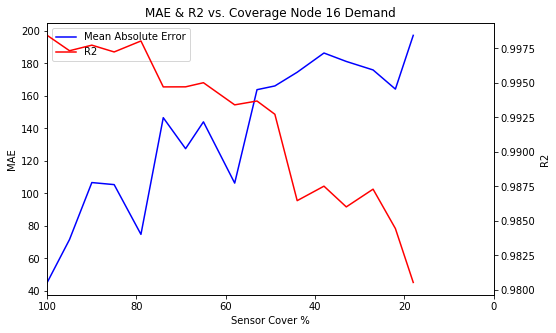

In [13]:
# Create the plot and specify the figure size
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot the first line
ax1.plot(sensors_covered, maximum_MAE, 'b-', label='Mean Absolute Error')
ax1.set_xlabel('Sensor Cover %')
ax1.set_ylabel('MAE')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the second line
ax2.plot(sensors_covered, R2_average, 'r-', label='R2')
ax2.set_ylabel('R2')

# Show legends for both lines
lines = [ax1.get_lines()[0], ax2.get_lines()[0]]
ax1.legend(lines, [line.get_label() for line in lines])

# Show the plot
plt.title("MAE & R2 vs. Coverage Node 16 Demand")
plt.xlim([100, 0])
plt.savefig('/Users/alexellard/Downloads/MAER2Demand.png')
plt.show()

In [10]:
MAE_average = []
RMSE_average = []
R2_average = []
maximum_MAE = []
sensors_covered = []
n_columns_to_drop = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
for n in n_columns_to_drop:
    MAE = []
    RMSE = []
    R2 = []
    for run in range(1,11):
        Y = df[df.columns[92]]
        X = df.drop(columns=['link_29_flow'])
        X['link_29_flow'] = Y
        columns = []
        columns_to_drop = random.sample(list(X.columns), n)
        # Drop the selected columns from the dataframe
        if X.columns[-1] in columns_to_drop:
            columns_to_drop.remove(X.columns[-1])
        X.drop(columns_to_drop, axis=1, inplace=True)
        columns.append(columns_to_drop)
        print(columns)
        print('starting df shape:', X.shape)
        print(f'This is training run {run} and has the shape: ', X.shape)
        print(f'The value of dropped columns is {n}')

        # split into train and test sets
        values = X.values
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
        train, test = train_test_split(scaled, test_size=0.2, random_state=0)

        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]

        #define model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42
        )

        # fit the model on the training data
        model.fit(train_X, train_y)

        # make predictions on the test data
        y_pred = model.predict(test_X)

        test_y = test_y.reshape((len(test_y), 1))
        print('test y shape :', test_y.shape)
        inv_test_y = concatenate((test_y, test_X[:, -X.shape[1]:]), axis=1)
        print('Inv y shape :', inv_test_y.shape)
        test_y_inverse = scaler.inverse_transform(inv_test_y)
        test_y_inverse = test_y_inverse[:,0]

        y_pred = y_pred.reshape((len(y_pred), 1))
        print('y pred shape :', y_pred.shape)
        inv_y_pred = concatenate((y_pred, test_X[:, -X.shape[1]:]), axis=1)
        print('inv y pred :', inv_y_pred.shape)
        y_pred_inverse = scaler.inverse_transform(inv_y_pred)
        y_pred_inverse = y_pred_inverse[:,0]

        # evaluate scaled errors
        mae_inverse = mean_absolute_error(test_y_inverse, y_pred_inverse)
        MAE.append(mae_inverse)
        print(f'Run {run} Mean Absolute Error:', mae_inverse)
        rmse_inverse = sqrt(mean_squared_error(test_y_inverse, y_pred_inverse))
        RMSE.append(rmse_inverse)
        print('RMSE: %.3f' % rmse_inverse)
        r2_inverse = r2_score(test_y_inverse, y_pred_inverse)
        R2.append(r2_inverse)
        print('R^2: %.3f' % r2_inverse)
    percentage_list = round(X.shape[1] / 96 * 100)
    sensors_covered.append(percentage_list)
    MAE_mean = mean(MAE)
    RMSE_mean = mean(RMSE)
    R2_mean = mean(R2)
    max_MAE = max(MAE)
    maximum_MAE.append(max_MAE)
    MAE_average.append(MAE_mean)
    RMSE_average.append(RMSE_mean)
    R2_average.append(R2_mean)
print('Length MAE_average: ', len(MAE_average))
print('Length sensors_covered: ', len(sensors_covered))

[[]]
starting df shape: (87600, 96)
This is training run 1 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 1 Mean Absolute Error: 78.24191457903137
RMSE: 100.787
R^2: 0.995
[[]]
starting df shape: (87600, 96)
This is training run 2 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 2 Mean Absolute Error: 78.24191457903137
RMSE: 100.787
R^2: 0.995
[[]]
starting df shape: (87600, 96)
This is training run 3 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 3 Mean Absolute Error: 78.24191457903137
RMSE: 100.787
R^2: 0.995
[[]]
starting df shape: (87600, 96)
This is training run 4 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 4 Mean Absolute Error: 78.24191457903137
RMSE: 100.787
R^2: 0.995
[[]]
starting df shape: (87600, 96)
This is training run 5 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 5 Mean Absolute Error: 78.24191457903137
RMSE: 100.787
R^2: 0.995
[[]]
starting df shape: (87600, 96)
This is training run 6 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 6 Mean Absolute Error: 78.24191457903137
RMSE: 100.787
R^2: 0.995
[[]]
starting df shape: (87600, 96)
This is training run 7 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 7 Mean Absolute Error: 78.24191457903137
RMSE: 100.787
R^2: 0.995
[[]]
starting df shape: (87600, 96)
This is training run 8 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 8 Mean Absolute Error: 78.24191457903137
RMSE: 100.787
R^2: 0.995
[[]]
starting df shape: (87600, 96)
This is training run 9 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 9 Mean Absolute Error: 78.24191457903137
RMSE: 100.787
R^2: 0.995
[[]]
starting df shape: (87600, 96)
This is training run 10 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 10 Mean Absolute Error: 78.24191457903137
RMSE: 100.787
R^2: 0.995
[['link_12_flow', 'node_17_demand', 'node_20_demand', 'link_10_flow', 'node_14_demand']]
starting df shape: (87600, 91)
This is training run 1 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 1 Mean Absolute Error: 78.37836220985811
RMSE: 100.944
R^2: 0.995
[['node_30_demand', 'link_13_flow', 'node_12_demand', 'node_6_pressure', 'reservoir_pressure']]
starting df shape: (87600, 91)
This is training run 2 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 2 Mean Absolute Error: 78.46926589314248
RMSE: 100.149
R^2: 0.995
[['link_20_flow', 'node_26_demand', 'link_16_flow', 'link_24_flow', 'node_3_demand']]
starting df shape: (87600, 91)
This is training run 3 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 3 Mean Absolute Error: 79.22468101301827
RMSE: 101.673
R^2: 0.995
[['node_2_pressure', 'node_1_demand', 'link_18_flow', 'node_23_demand']]
starting df shape: (87600, 92)
This is training run 4 and has the shape:  (87600, 92)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 92)
y pred shape : (17520, 1)
inv y pred : (17520, 92)
Run 4 Mean Absolute Error: 78.8416642430506
RMSE: 101.111
R^2: 0.995
[['link_8_flow', 'node_8_demand', 'link_19_flow', 'node_23_demand', 'link_2_flow']]
starting df shape: (87600, 91)
This is training run 5 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 5 Mean Absolute Error: 79.17528559825597
RMSE: 101.729
R^2: 0.995
[['link_31_flow', 'node_20_demand', 'node_30_demand', 'node_24_demand', 'link_18_flow']]
starting df shape: (87600, 91)
This is training run 6 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 6 Mean Absolute Error: 79.22057206203672
RMSE: 101.624
R^2: 0.995
[['node_31_pressure', 'link_24_flow', 'reservoir_pressure', 'node_28_demand', 'node_19_demand']]
starting df shape: (87600, 91)
This is training run 7 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 7 Mean Absolute Error: 98.41848399738332
RMSE: 127.085
R^2: 0.993
[['node_4_pressure', 'node_6_pressure', 'node_16_demand', 'reservoir_demand', 'link_17_flow']]
starting df shape: (87600, 91)
This is training run 8 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 8 Mean Absolute Error: 4.830147807108213
RMSE: 6.214
R^2: 0.995
[['node_25_demand', 'node_2_pressure', 'link_14_flow', 'node_9_pressure', 'node_20_demand']]
starting df shape: (87600, 91)
This is training run 9 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 9 Mean Absolute Error: 78.36270208207709
RMSE: 101.867
R^2: 0.995
[['node_3_demand', 'node_20_demand', 'node_7_demand', 'link_31_flow', 'node_2_demand']]
starting df shape: (87600, 91)
This is training run 10 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 10 Mean Absolute Error: 78.7008206022316
RMSE: 101.512
R^2: 0.995
[['node_11_demand', 'link_8_flow', 'node_24_demand', 'node_21_demand', 'link_27_flow', 'link_15_flow', 'link_23_flow', 'link_20_flow', 'node_21_pressure']]
starting df shape: (87600, 87)
This is training run 1 and has the shape:  (87600, 87)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 87)
y pred shape : (17520, 1)
inv y pred : (17520, 87)
Run 1 Mean Absolute Error: 78.61072054194665
RMSE: 101.203
R^2: 0.995
[['node_14_demand', 'link_1_flow', 'reservoir_pressure', 'link_11_flow', 'node_15_pressure', 'node_17_pressure', 'node_26_pressure', 'node_28_demand', 'node_28_pressure', 'link_10_flow']]
starting df shape: (87600, 86)
This is training run 2 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 2 Mean Absolute Error: 97.68014293963367
RMSE: 125.956
R^2: 0.993
[['node_12_pressure', 'node_3_pressure', 'node_26_pressure', 'node_28_pressure', 'link_8_flow', 'node_6_pressure', 'node_12_demand', 'node_18_demand', 'link_28_flow', 'link_2_flow']]
starting df shape: (87600, 86)
This is training run 3 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 3 Mean Absolute Error: 81.02060917396247
RMSE: 103.848
R^2: 0.995
[['node_25_pressure', 'node_3_demand', 'node_25_demand', 'node_26_demand', 'node_10_demand', 'link_32_flow', 'link_9_flow', 'node_15_pressure', 'link_18_flow', 'link_20_flow']]
starting df shape: (87600, 86)
This is training run 4 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 4 Mean Absolute Error: 78.988920322677
RMSE: 101.477
R^2: 0.995
[['node_9_demand', 'link_10_flow', 'node_5_pressure', 'link_17_flow', 'node_7_demand', 'node_3_demand', 'reservoir_pressure', 'node_9_pressure', 'node_4_demand', 'link_3_flow']]
starting df shape: (87600, 86)
This is training run 5 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 5 Mean Absolute Error: 78.67444553789207
RMSE: 101.427
R^2: 0.995
[['node_30_demand', 'node_28_demand', 'node_22_demand', 'node_19_pressure', 'node_13_demand', 'node_3_demand', 'node_23_demand', 'link_13_flow', 'link_28_flow', 'node_11_pressure']]
starting df shape: (87600, 86)
This is training run 6 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 6 Mean Absolute Error: 97.73767248255747
RMSE: 126.017
R^2: 0.993
[['link_12_flow', 'node_5_pressure', 'link_27_flow', 'link_24_flow', 'node_22_demand', 'link_18_flow', 'node_20_demand', 'link_32_flow', 'node_28_pressure', 'link_10_flow']]
starting df shape: (87600, 86)
This is training run 7 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 7 Mean Absolute Error: 78.72664467117556
RMSE: 101.016
R^2: 0.995
[['link_4_flow', 'node_22_pressure', 'link_6_flow', 'link_23_flow', 'link_19_flow', 'node_2_pressure', 'node_28_pressure', 'link_30_flow', 'node_29_demand', 'link_31_flow']]
starting df shape: (87600, 86)
This is training run 8 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 8 Mean Absolute Error: 91.90650748162643
RMSE: 118.087
R^2: 0.994
[['link_15_flow', 'link_26_flow', 'node_17_demand', 'node_24_pressure', 'link_24_flow', 'node_1_demand', 'node_8_pressure', 'node_18_demand', 'node_23_pressure', 'node_30_demand']]
starting df shape: (87600, 86)
This is training run 9 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 9 Mean Absolute Error: 78.84471870824896
RMSE: 101.229
R^2: 0.995
[['node_3_demand', 'link_7_flow', 'link_13_flow', 'node_23_pressure', 'reservoir_pressure', 'node_12_demand', 'link_6_flow', 'node_4_pressure', 'node_26_demand', 'node_15_pressure']]
starting df shape: (87600, 86)
This is training run 10 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 10 Mean Absolute Error: 79.4577959391352
RMSE: 101.642
R^2: 0.995
[['node_27_pressure', 'node_15_pressure', 'node_14_demand', 'node_9_demand', 'node_24_pressure', 'node_8_pressure', 'node_1_demand', 'link_10_flow', 'link_5_flow', 'node_8_demand', 'node_6_pressure', 'link_28_flow', 'node_17_demand', 'node_10_pressure', 'link_17_flow']]
starting df shape: (87600, 81)
This is training run 1 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 1 Mean Absolute Error: 81.34166303081868
RMSE: 104.874
R^2: 0.995
[['link_25_flow', 'reservoir_pressure', 'node_18_pressure', 'link_27_flow', 'node_20_pressure', 'link_21_flow', 'node_1_demand', 'link_13_flow', 'node_21_demand', 'link_2_flow', 'node_28_demand', 'link_16_flow', 'link_11_flow', 'node_26_demand', 'link_19_flow']]
starting df shape: (87600, 81)
This is training run 2 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 2 Mean Absolute Error: 98.29078302369948
RMSE: 127.593
R^2: 0.992
[['node_18_pressure', 'node_28_pressure', 'link_6_flow', 'node_3_demand', 'link_28_flow', 'node_19_pressure', 'link_4_flow', 'node_30_demand', 'node_8_demand', 'link_25_flow', 'link_15_flow', 'link_22_flow', 'node_8_pressure', 'link_8_flow']]
starting df shape: (87600, 82)
This is training run 3 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 3 Mean Absolute Error: 81.34619709443962
RMSE: 104.266
R^2: 0.995
[['node_12_demand', 'node_24_demand', 'link_21_flow', 'link_2_flow', 'node_19_demand', 'node_13_pressure', 'link_22_flow', 'node_30_pressure', 'node_17_demand', 'node_8_pressure', 'link_7_flow', 'node_17_pressure', 'link_28_flow', 'node_31_demand', 'node_13_demand']]
starting df shape: (87600, 81)
This is training run 4 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 4 Mean Absolute Error: 82.92026964314584
RMSE: 107.216
R^2: 0.995
[['node_4_demand', 'node_31_demand', 'node_2_pressure', 'link_5_flow', 'link_25_flow', 'node_20_demand', 'node_25_pressure', 'node_12_pressure', 'link_14_flow', 'node_15_demand', 'node_5_pressure', 'node_13_pressure', 'node_6_demand', 'node_7_pressure', 'node_10_demand']]
starting df shape: (87600, 81)
This is training run 5 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 5 Mean Absolute Error: 80.21664950899472
RMSE: 103.749
R^2: 0.995
[['node_16_demand', 'node_29_pressure', 'node_3_pressure', 'link_23_flow', 'node_7_demand', 'node_18_pressure', 'link_32_flow', 'node_25_pressure', 'node_12_pressure', 'node_11_demand', 'link_17_flow', 'node_31_demand', 'node_20_pressure', 'node_6_demand']]
starting df shape: (87600, 82)
This is training run 6 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 6 Mean Absolute Error: 84.19495102793384
RMSE: 108.366
R^2: 0.995
[['node_5_demand', 'node_21_pressure', 'link_3_flow', 'link_30_flow', 'link_19_flow', 'link_8_flow', 'node_11_demand', 'link_11_flow', 'link_32_flow', 'node_28_pressure', 'node_3_pressure', 'node_31_demand', 'node_5_pressure', 'node_6_demand', 'node_14_pressure']]
starting df shape: (87600, 81)
This is training run 7 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 7 Mean Absolute Error: 87.76172328327614
RMSE: 112.864
R^2: 0.994
[['node_18_pressure', 'link_9_flow', 'link_2_flow', 'link_27_flow', 'node_12_demand', 'node_20_demand', 'node_21_pressure', 'node_5_demand', 'node_25_pressure', 'link_22_flow', 'node_4_demand', 'link_7_flow', 'node_13_demand', 'node_16_demand', 'node_21_demand']]
starting df shape: (87600, 81)
This is training run 8 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 8 Mean Absolute Error: 79.59422858931019
RMSE: 102.332
R^2: 0.995
[['node_4_pressure', 'node_20_pressure', 'node_16_demand', 'link_20_flow', 'reservoir_pressure', 'link_8_flow', 'node_10_pressure', 'node_18_demand', 'link_12_flow', 'node_5_demand', 'link_21_flow', 'node_31_pressure', 'node_13_demand', 'node_26_pressure', 'node_29_pressure']]
starting df shape: (87600, 81)
This is training run 9 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 9 Mean Absolute Error: 78.53747594702322
RMSE: 100.854
R^2: 0.995
[['node_2_demand', 'node_1_pressure', 'node_8_pressure', 'link_17_flow', 'node_10_pressure', 'node_28_demand', 'node_24_pressure', 'node_29_demand', 'link_22_flow', 'link_30_flow', 'node_8_demand', 'link_20_flow', 'link_25_flow', 'node_14_demand', 'node_29_pressure']]
starting df shape: (87600, 81)
This is training run 10 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 10 Mean Absolute Error: 155.69583614515517
RMSE: 204.349
R^2: 0.981
[['node_11_pressure', 'node_1_demand', 'node_25_pressure', 'node_2_pressure', 'node_18_demand', 'link_23_flow', 'node_26_pressure', 'link_4_flow', 'link_12_flow', 'node_6_pressure', 'node_8_pressure', 'link_27_flow', 'node_23_demand', 'node_22_pressure', 'link_24_flow', 'reservoir_pressure', 'node_31_demand', 'link_5_flow', 'reservoir_demand', 'node_2_demand']]
starting df shape: (87600, 76)
This is training run 1 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 1 Mean Absolute Error: 0.7077049594725647
RMSE: 0.915
R^2: 0.995
[['node_13_demand', 'node_23_pressure', 'node_29_pressure', 'link_17_flow', 'node_28_pressure', 'node_18_demand', 'node_4_pressure', 'link_15_flow', 'node_27_pressure', 'node_31_demand', 'node_5_pressure', 'node_6_pressure', 'link_16_flow', 'link_2_flow', 'node_7_demand', 'link_22_flow', 'link_12_flow', 'node_23_demand', 'node_1_demand', 'node_31_pressure']]
starting df shape: (87600, 76)
This is training run 2 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 2 Mean Absolute Error: 79.9818800060308
RMSE: 102.829
R^2: 0.995
[['link_5_flow', 'node_10_pressure', 'node_21_demand', 'node_20_pressure', 'node_5_pressure', 'node_26_pressure', 'node_30_pressure', 'node_20_demand', 'link_27_flow', 'link_31_flow', 'node_1_demand', 'node_1_pressure', 'node_6_demand', 'link_13_flow', 'link_2_flow', 'node_31_pressure', 'link_20_flow', 'node_29_demand', 'node_12_demand']]
starting df shape: (87600, 77)
This is training run 3 and has the shape:  (87600, 77)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)
y pred shape : (17520, 1)
inv y pred : (17520, 77)
Run 3 Mean Absolute Error: 90.93499551406866
RMSE: 116.798
R^2: 0.994
[['node_27_pressure', 'link_9_flow', 'node_11_pressure', 'node_18_pressure', 'node_26_demand', 'node_7_demand', 'link_16_flow', 'link_24_flow', 'node_16_demand', 'link_18_flow', 'node_6_pressure', 'link_14_flow', 'node_28_pressure', 'link_17_flow', 'link_3_flow', 'link_2_flow', 'node_20_pressure', 'node_29_demand', 'link_26_flow', 'node_11_demand']]
starting df shape: (87600, 76)
This is training run 4 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 4 Mean Absolute Error: 91.64412379004773
RMSE: 118.519
R^2: 0.994
[['link_19_flow', 'link_20_flow', 'node_1_demand', 'link_25_flow', 'node_16_demand', 'node_6_pressure', 'link_17_flow', 'link_24_flow', 'link_2_flow', 'node_21_pressure', 'link_31_flow', 'node_1_pressure', 'node_3_demand', 'node_5_pressure', 'node_4_demand', 'node_2_demand', 'node_29_demand', 'node_30_demand', 'node_9_pressure']]
starting df shape: (87600, 77)
This is training run 5 and has the shape:  (87600, 77)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)
y pred shape : (17520, 1)
inv y pred : (17520, 77)
Run 5 Mean Absolute Error: 91.46467871348332
RMSE: 118.315
R^2: 0.994
[['node_1_demand', 'node_2_demand', 'link_2_flow', 'node_27_pressure', 'link_17_flow', 'node_15_pressure', 'node_10_pressure', 'link_27_flow', 'node_22_pressure', 'node_20_pressure', 'link_25_flow', 'node_24_demand', 'node_2_pressure', 'node_14_pressure', 'node_19_demand', 'node_30_pressure', 'link_19_flow', 'link_3_flow', 'node_17_pressure', 'node_10_demand']]
starting df shape: (87600, 76)
This is training run 6 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 6 Mean Absolute Error: 77.63667215353819
RMSE: 99.814
R^2: 0.995
[['node_8_demand', 'link_31_flow', 'node_14_pressure', 'node_5_demand', 'node_2_demand', 'node_3_pressure', 'node_7_pressure', 'node_31_pressure', 'node_18_pressure', 'node_27_demand', 'link_13_flow', 'node_25_pressure', 'link_22_flow', 'node_4_pressure', 'link_12_flow', 'link_11_flow', 'link_4_flow', 'link_32_flow', 'link_8_flow', 'node_23_demand']]
starting df shape: (87600, 76)
This is training run 7 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 7 Mean Absolute Error: 81.87369788487479
RMSE: 104.501
R^2: 0.995
[['node_24_pressure', 'node_5_pressure', 'node_7_pressure', 'node_14_pressure', 'node_2_demand', 'link_13_flow', 'link_21_flow', 'node_9_pressure', 'node_11_pressure', 'node_17_pressure', 'node_2_pressure', 'node_23_demand', 'node_30_demand', 'node_3_demand', 'node_13_pressure', 'node_9_demand', 'link_20_flow', 'link_15_flow', 'node_27_pressure', 'link_17_flow']]
starting df shape: (87600, 76)
This is training run 8 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 8 Mean Absolute Error: 78.76443008083592
RMSE: 100.867
R^2: 0.995
[['link_22_flow', 'node_4_demand', 'reservoir_demand', 'node_20_demand', 'node_26_demand', 'link_18_flow', 'node_31_demand', 'node_24_demand', 'node_10_pressure', 'node_8_pressure', 'link_17_flow', 'node_12_pressure', 'link_14_flow', 'link_15_flow', 'node_8_demand', 'node_3_demand', 'link_26_flow', 'node_16_pressure', 'node_7_pressure', 'node_29_pressure']]
starting df shape: (87600, 76)
This is training run 9 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 9 Mean Absolute Error: 4.879370482159805
RMSE: 6.342
R^2: 0.995
[['node_22_pressure', 'node_3_demand', 'node_18_pressure', 'node_27_pressure', 'link_8_flow', 'link_26_flow', 'link_31_flow', 'link_10_flow', 'node_31_demand', 'link_32_flow', 'node_4_pressure', 'link_28_flow', 'link_19_flow', 'node_29_pressure', 'link_23_flow', 'link_15_flow', 'node_26_pressure', 'node_16_pressure', 'node_21_demand', 'node_30_pressure']]
starting df shape: (87600, 76)
This is training run 10 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 10 Mean Absolute Error: 88.35449362390659
RMSE: 113.749
R^2: 0.994
[['link_15_flow', 'node_26_demand', 'link_28_flow', 'node_13_demand', 'link_8_flow', 'node_1_demand', 'node_9_demand', 'link_19_flow', 'node_1_pressure', 'link_13_flow', 'link_17_flow', 'link_10_flow', 'node_25_demand', 'node_14_pressure', 'link_3_flow', 'node_2_pressure', 'node_2_demand', 'node_19_demand', 'node_4_pressure', 'link_7_flow', 'node_6_demand', 'link_32_flow', 'node_22_pressure', 'link_26_flow', 'link_4_flow']]
starting df shape: (87600, 71)
This is training run 1 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 1 Mean Absolute Error: 80.46641754411668
RMSE: 104.112
R^2: 0.995
[['node_3_demand', 'node_23_pressure', 'node_21_pressure', 'link_22_flow', 'link_28_flow', 'link_9_flow', 'link_13_flow', 'node_12_pressure', 'node_2_pressure', 'link_14_flow', 'link_10_flow', 'reservoir_demand', 'node_13_demand', 'node_21_demand', 'node_24_pressure', 'link_26_flow', 'node_20_demand', 'reservoir_pressure', 'node_27_demand', 'link_15_flow', 'node_4_demand', 'node_18_pressure', 'link_24_flow', 'node_3_pressure', 'node_9_pressure']]
starting df shape: (87600, 71)
This is training run 2 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 2 Mean Absolute Error: 5.318473944980397
RMSE: 6.828
R^2: 0.994
[['reservoir_pressure', 'node_8_pressure', 'node_4_demand', 'link_4_flow', 'link_2_flow', 'node_4_pressure', 'node_17_demand', 'node_26_pressure', 'node_31_pressure', 'node_2_demand', 'node_2_pressure', 'node_21_demand', 'node_28_pressure', 'link_8_flow', 'node_22_pressure', 'node_29_pressure', 'link_30_flow', 'link_22_flow', 'link_26_flow', 'node_15_pressure', 'link_19_flow', 'node_12_pressure', 'link_1_flow', 'link_7_flow', 'node_24_demand']]
starting df shape: (87600, 71)
This is training run 3 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 3 Mean Absolute Error: 81.9841785050418
RMSE: 105.650
R^2: 0.995
[['node_20_demand', 'node_30_demand', 'node_9_pressure', 'link_20_flow', 'link_24_flow', 'node_19_demand', 'link_2_flow', 'link_16_flow', 'node_26_demand', 'reservoir_demand', 'node_8_pressure', 'link_15_flow', 'link_26_flow', 'node_25_pressure', 'node_22_pressure', 'node_2_pressure', 'node_17_pressure', 'node_24_demand', 'link_11_flow', 'node_21_pressure', 'node_19_pressure', 'link_19_flow', 'node_2_demand', 'node_8_demand', 'node_27_pressure']]
starting df shape: (87600, 71)
This is training run 4 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 4 Mean Absolute Error: 4.827430171054112
RMSE: 6.206
R^2: 0.995
[['node_5_pressure', 'node_19_pressure', 'node_4_demand', 'reservoir_pressure', 'node_2_pressure', 'node_26_pressure', 'link_1_flow', 'node_3_pressure', 'node_28_pressure', 'node_21_demand', 'link_8_flow', 'node_27_pressure', 'node_8_demand', 'node_20_demand', 'link_10_flow', 'node_1_demand', 'node_11_pressure', 'link_16_flow', 'link_24_flow', 'link_26_flow', 'node_30_demand', 'node_7_pressure', 'node_27_demand', 'node_18_demand', 'node_11_demand']]
starting df shape: (87600, 71)
This is training run 5 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 5 Mean Absolute Error: 83.13537035150478
RMSE: 106.167
R^2: 0.995
[['node_12_pressure', 'link_9_flow', 'link_2_flow', 'reservoir_demand', 'node_25_pressure', 'link_30_flow', 'node_26_demand', 'node_14_demand', 'node_12_demand', 'node_28_demand', 'link_12_flow', 'link_7_flow', 'link_32_flow', 'node_17_pressure', 'link_27_flow', 'node_11_demand', 'node_5_pressure', 'node_18_demand', 'link_13_flow', 'node_3_pressure', 'node_24_pressure', 'node_6_pressure', 'link_17_flow', 'node_2_demand', 'node_7_pressure']]
starting df shape: (87600, 71)
This is training run 6 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 6 Mean Absolute Error: 6.707444663496866
RMSE: 8.585
R^2: 0.991
[['node_17_demand', 'node_8_demand', 'node_16_pressure', 'node_20_pressure', 'node_30_demand', 'node_22_pressure', 'node_5_demand', 'node_7_demand', 'link_12_flow', 'node_7_pressure', 'node_10_demand', 'node_8_pressure', 'node_14_demand', 'reservoir_demand', 'link_11_flow', 'link_13_flow', 'link_7_flow', 'link_28_flow', 'node_25_demand', 'node_1_pressure', 'node_4_demand', 'node_23_pressure', 'link_2_flow', 'node_3_pressure']]
starting df shape: (87600, 72)
This is training run 7 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 7 Mean Absolute Error: 4.9599802524300465
RMSE: 6.384
R^2: 0.995
[['link_6_flow', 'node_29_pressure', 'reservoir_demand', 'node_7_demand', 'node_8_demand', 'node_13_pressure', 'node_19_pressure', 'node_8_pressure', 'link_14_flow', 'node_6_demand', 'node_9_demand', 'node_26_pressure', 'node_15_demand', 'node_21_pressure', 'node_20_pressure', 'link_13_flow', 'link_22_flow', 'node_2_pressure', 'node_4_pressure', 'node_25_demand', 'node_24_pressure', 'node_1_demand', 'node_6_pressure', 'link_19_flow', 'node_15_pressure']]
starting df shape: (87600, 71)
This is training run 8 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 8 Mean Absolute Error: 4.304485999495199
RMSE: 5.564
R^2: 0.995
[['node_27_demand', 'node_13_pressure', 'node_1_pressure', 'link_22_flow', 'link_26_flow', 'node_18_demand', 'link_27_flow', 'link_7_flow', 'node_18_pressure', 'reservoir_demand', 'node_15_pressure', 'node_7_pressure', 'node_26_pressure', 'node_3_pressure', 'node_23_pressure', 'node_25_pressure', 'node_24_demand', 'link_15_flow', 'link_20_flow', 'node_21_pressure', 'link_19_flow', 'node_8_demand', 'link_3_flow', 'node_29_pressure', 'link_21_flow']]
starting df shape: (87600, 71)
This is training run 9 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 9 Mean Absolute Error: 5.067629575639555
RMSE: 6.493
R^2: 0.995
[['node_14_demand', 'node_13_pressure', 'node_17_pressure', 'node_20_demand', 'link_11_flow', 'node_27_demand', 'node_11_demand', 'link_2_flow', 'node_25_pressure', 'link_27_flow', 'node_3_demand', 'node_19_pressure', 'node_31_pressure', 'node_10_pressure', 'node_8_demand', 'node_21_demand', 'node_14_pressure', 'node_24_demand', 'link_1_flow', 'node_9_pressure', 'node_10_demand', 'node_8_pressure', 'node_24_pressure', 'link_20_flow', 'link_13_flow']]
starting df shape: (87600, 71)
This is training run 10 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 10 Mean Absolute Error: 82.22956201891782
RMSE: 104.844
R^2: 0.995
[['link_11_flow', 'node_12_demand', 'node_6_pressure', 'link_4_flow', 'node_20_demand', 'node_9_pressure', 'node_1_demand', 'link_10_flow', 'node_9_demand', 'link_19_flow', 'link_17_flow', 'node_28_demand', 'node_25_demand', 'node_7_pressure', 'node_22_demand', 'node_26_pressure', 'node_18_pressure', 'node_22_pressure', 'node_23_demand', 'node_8_demand', 'node_31_demand', 'link_6_flow', 'link_1_flow', 'node_2_pressure', 'node_5_pressure', 'link_24_flow', 'node_15_demand', 'link_21_flow', 'node_2_demand', 'node_16_demand']]
starting df shape: (87600, 66)
This is training run 1 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 1 Mean Absolute Error: 97.3283014255231
RMSE: 126.417
R^2: 0.993
[['node_29_demand', 'link_2_flow', 'link_9_flow', 'node_23_demand', 'node_2_demand', 'link_25_flow', 'link_11_flow', 'link_23_flow', 'node_5_pressure', 'node_24_pressure', 'node_31_demand', 'node_13_demand', 'node_11_demand', 'link_32_flow', 'node_10_pressure', 'node_12_pressure', 'node_17_demand', 'node_15_pressure', 'node_16_pressure', 'link_12_flow', 'node_25_demand', 'link_21_flow', 'node_8_demand', 'node_11_pressure', 'node_30_pressure', 'node_4_demand', 'node_29_pressure', 'node_8_pressure', 'reservoir_pressure', 'node_6_pressure']]
starting df shape: (87600, 66)
This is training run 2 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 2 Mean Absolute Error: 97.27841987540457
RMSE: 125.112
R^2: 0.993
[['node_2_pressure', 'node_28_demand', 'node_19_pressure', 'node_16_demand', 'node_20_pressure', 'node_14_pressure', 'node_25_pressure', 'node_8_demand', 'link_9_flow', 'node_5_pressure', 'node_8_pressure', 'reservoir_pressure', 'node_13_demand', 'node_1_pressure', 'node_5_demand', 'node_24_pressure', 'node_2_demand', 'node_6_demand', 'node_15_pressure', 'link_17_flow', 'link_16_flow', 'link_31_flow', 'node_4_pressure', 'link_28_flow', 'node_14_demand', 'link_6_flow', 'node_28_pressure', 'link_2_flow', 'reservoir_demand', 'node_7_pressure']]
starting df shape: (87600, 66)
This is training run 3 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 3 Mean Absolute Error: 6.03455693817302
RMSE: 7.847
R^2: 0.992
[['node_11_pressure', 'link_19_flow', 'node_1_demand', 'link_31_flow', 'node_14_pressure', 'link_15_flow', 'link_3_flow', 'node_15_demand', 'node_29_pressure', 'node_20_demand', 'node_5_pressure', 'node_27_demand', 'node_18_demand', 'reservoir_demand', 'node_29_demand', 'node_4_pressure', 'link_4_flow', 'link_18_flow', 'link_7_flow', 'link_10_flow', 'node_24_pressure', 'link_32_flow', 'node_8_demand', 'node_12_pressure', 'node_30_pressure', 'node_6_demand', 'node_4_demand', 'node_25_demand', 'node_14_demand']]
starting df shape: (87600, 67)
This is training run 4 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 4 Mean Absolute Error: 5.223489536743866
RMSE: 6.698
R^2: 0.993
[['node_26_demand', 'node_22_demand', 'node_16_pressure', 'link_5_flow', 'link_7_flow', 'node_23_demand', 'link_12_flow', 'node_19_demand', 'node_10_demand', 'node_1_pressure', 'node_24_demand', 'node_28_pressure', 'node_23_pressure', 'node_18_demand', 'node_11_pressure', 'node_20_demand', 'node_10_pressure', 'link_11_flow', 'node_17_pressure', 'node_4_demand', 'reservoir_pressure', 'node_21_pressure', 'link_15_flow', 'link_22_flow', 'node_25_demand', 'node_21_demand', 'node_13_pressure', 'link_28_flow', 'link_2_flow']]
starting df shape: (87600, 67)
This is training run 5 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 5 Mean Absolute Error: 81.14378011872913
RMSE: 104.874
R^2: 0.995
[['node_23_pressure', 'node_28_pressure', 'link_5_flow', 'link_24_flow', 'link_27_flow', 'node_13_pressure', 'node_14_demand', 'node_8_demand', 'node_13_demand', 'node_15_pressure', 'node_7_pressure', 'node_12_demand', 'node_24_demand', 'node_31_pressure', 'node_20_pressure', 'node_22_pressure', 'node_26_demand', 'node_3_demand', 'node_30_demand', 'link_8_flow', 'node_6_demand', 'link_11_flow', 'node_18_demand', 'link_6_flow', 'node_4_pressure', 'link_21_flow', 'node_25_demand', 'link_31_flow', 'node_3_pressure']]
starting df shape: (87600, 67)
This is training run 6 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 6 Mean Absolute Error: 78.88892675087465
RMSE: 101.468
R^2: 0.995
[['node_28_pressure', 'node_2_demand', 'link_11_flow', 'link_15_flow', 'link_23_flow', 'node_26_demand', 'node_17_pressure', 'link_5_flow', 'node_3_pressure', 'node_19_demand', 'node_12_pressure', 'node_10_pressure', 'node_24_pressure', 'node_28_demand', 'node_27_pressure', 'node_14_demand', 'node_4_pressure', 'link_4_flow', 'node_6_pressure', 'node_2_pressure', 'link_10_flow', 'node_29_demand', 'node_11_demand', 'reservoir_demand', 'node_15_pressure', 'node_31_pressure', 'node_27_demand', 'node_25_demand', 'node_11_pressure', 'link_28_flow']]
starting df shape: (87600, 66)
This is training run 7 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 7 Mean Absolute Error: 9.619753173005906
RMSE: 12.675
R^2: 0.980
[['link_7_flow', 'node_29_pressure', 'node_21_demand', 'link_12_flow', 'link_26_flow', 'node_7_pressure', 'node_19_pressure', 'node_3_demand', 'link_18_flow', 'link_9_flow', 'link_19_flow', 'node_6_demand', 'link_25_flow', 'node_5_pressure', 'node_27_demand', 'node_9_demand', 'node_16_pressure', 'node_1_demand', 'node_20_demand', 'node_9_pressure', 'link_15_flow', 'link_11_flow', 'node_23_pressure', 'node_29_demand', 'node_18_demand', 'node_30_demand', 'link_30_flow', 'node_10_pressure', 'node_31_pressure', 'link_5_flow']]
starting df shape: (87600, 66)
This is training run 8 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 8 Mean Absolute Error: 94.15913992504548
RMSE: 121.333
R^2: 0.993
[['node_23_demand', 'node_7_pressure', 'link_25_flow', 'reservoir_demand', 'node_26_demand', 'node_25_demand', 'node_16_pressure', 'node_27_demand', 'node_20_pressure', 'link_14_flow', 'node_14_demand', 'link_3_flow', 'node_19_demand', 'node_9_pressure', 'node_10_pressure', 'node_16_demand', 'node_31_demand', 'node_11_pressure', 'node_17_demand', 'link_7_flow', 'node_1_demand', 'node_5_demand', 'node_28_demand', 'node_6_pressure', 'link_1_flow', 'node_7_demand', 'node_9_demand', 'node_29_demand', 'link_27_flow', 'link_19_flow']]
starting df shape: (87600, 66)
This is training run 9 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 9 Mean Absolute Error: 8.794017675808032
RMSE: 11.512
R^2: 0.979
[['node_9_pressure', 'node_16_demand', 'node_5_pressure', 'link_6_flow', 'reservoir_demand', 'reservoir_pressure', 'link_19_flow', 'link_28_flow', 'link_12_flow', 'node_15_demand', 'link_26_flow', 'node_28_demand', 'link_32_flow', 'node_29_pressure', 'node_27_demand', 'node_7_demand', 'link_8_flow', 'node_13_demand', 'node_28_pressure', 'link_15_flow', 'node_20_demand', 'node_15_pressure', 'link_4_flow', 'link_18_flow', 'node_27_pressure', 'link_9_flow', 'node_17_demand', 'node_17_pressure', 'node_30_demand', 'node_18_pressure']]
starting df shape: (87600, 66)
This is training run 10 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 10 Mean Absolute Error: 5.920298297580791
RMSE: 7.636
R^2: 0.993
[['node_14_pressure', 'link_4_flow', 'node_11_pressure', 'node_20_demand', 'link_1_flow', 'link_21_flow', 'node_16_demand', 'node_27_demand', 'node_12_demand', 'node_15_pressure', 'node_28_demand', 'link_9_flow', 'node_9_pressure', 'link_16_flow', 'link_22_flow', 'node_18_demand', 'node_5_pressure', 'reservoir_demand', 'node_29_pressure', 'node_13_pressure', 'node_24_pressure', 'node_31_pressure', 'node_19_pressure', 'link_11_flow', 'link_27_flow', 'link_12_flow', 'node_20_pressure', 'link_20_flow', 'node_14_demand', 'node_10_pressure', 'node_2_demand', 'link_32_flow', 'node_1_pressure', 'link_23_flow', 'node_2_pressure']]
starting df shape: (87600, 61)
This is training run 1 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 1 Mean Absolute Error: 6.121242784651584
RMSE: 7.917
R^2: 0.992
[['link_19_flow', 'link_27_flow', 'node_20_demand', 'node_17_pressure', 'node_15_demand', 'node_14_demand', 'node_18_pressure', 'node_12_demand', 'node_19_demand', 'node_6_pressure', 'node_13_demand', 'link_23_flow', 'link_28_flow', 'link_31_flow', 'link_14_flow', 'link_15_flow', 'node_3_pressure', 'node_10_pressure', 'node_9_pressure', 'node_9_demand', 'link_25_flow', 'link_13_flow', 'node_31_demand', 'node_14_pressure', 'link_2_flow', 'link_16_flow', 'node_29_demand', 'node_31_pressure', 'link_11_flow', 'node_1_pressure', 'node_26_pressure', 'node_26_demand', 'node_24_demand', 'node_8_demand', 'reservoir_demand']]
starting df shape: (87600, 61)
This is training run 2 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 2 Mean Absolute Error: 6.4809497156984195
RMSE: 8.495
R^2: 0.991
[['node_28_demand', 'node_22_demand', 'node_19_demand', 'reservoir_demand', 'node_4_pressure', 'link_15_flow', 'node_31_pressure', 'node_30_demand', 'node_6_pressure', 'node_28_pressure', 'node_23_demand', 'link_6_flow', 'link_2_flow', 'link_10_flow', 'node_6_demand', 'link_23_flow', 'node_25_pressure', 'node_20_pressure', 'node_18_demand', 'node_14_pressure', 'link_11_flow', 'node_3_demand', 'node_5_demand', 'node_10_pressure', 'link_27_flow', 'node_11_pressure', 'node_9_pressure', 'node_12_demand', 'node_16_demand', 'node_21_pressure', 'node_17_pressure', 'node_14_demand', 'link_18_flow', 'node_22_pressure']]
starting df shape: (87600, 62)
This is training run 3 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 3 Mean Absolute Error: 5.93257620249505
RMSE: 7.696
R^2: 0.993
[['link_8_flow', 'node_17_pressure', 'node_25_pressure', 'link_17_flow', 'node_13_pressure', 'link_16_flow', 'link_14_flow', 'link_19_flow', 'node_31_demand', 'link_15_flow', 'node_20_pressure', 'node_16_demand', 'node_10_demand', 'node_4_demand', 'node_30_pressure', 'node_28_demand', 'node_22_demand', 'link_26_flow', 'link_3_flow', 'node_21_demand', 'node_12_demand', 'link_31_flow', 'link_20_flow', 'link_9_flow', 'node_11_demand', 'node_8_demand', 'link_25_flow', 'link_6_flow', 'node_28_pressure', 'link_12_flow', 'node_6_demand', 'link_23_flow', 'node_24_demand', 'link_4_flow']]
starting df shape: (87600, 62)
This is training run 4 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 4 Mean Absolute Error: 100.24783565849877
RMSE: 129.905
R^2: 0.992
[['node_29_demand', 'node_25_pressure', 'node_26_pressure', 'node_10_pressure', 'link_9_flow', 'node_15_pressure', 'node_1_demand', 'node_24_demand', 'node_21_pressure', 'node_8_demand', 'node_26_demand', 'link_4_flow', 'node_20_demand', 'node_4_pressure', 'node_10_demand', 'node_13_demand', 'node_28_demand', 'link_10_flow', 'link_18_flow', 'link_8_flow', 'node_17_demand', 'link_16_flow', 'link_26_flow', 'link_28_flow', 'link_17_flow', 'node_9_demand', 'node_6_demand', 'link_15_flow', 'node_31_pressure', 'link_24_flow', 'node_9_pressure', 'link_25_flow', 'node_11_demand', 'link_1_flow', 'node_23_demand']]
starting df shape: (87600, 61)
This is training run 5 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 5 Mean Absolute Error: 154.68543579023992
RMSE: 202.767
R^2: 0.981
[['node_13_demand', 'node_31_demand', 'link_5_flow', 'link_8_flow', 'node_2_pressure', 'node_23_demand', 'node_1_pressure', 'node_19_pressure', 'node_8_demand', 'link_3_flow', 'link_28_flow', 'link_18_flow', 'link_27_flow', 'node_29_demand', 'node_5_demand', 'link_17_flow', 'link_2_flow', 'node_8_pressure', 'link_13_flow', 'node_27_demand', 'node_28_demand', 'link_4_flow', 'node_5_pressure', 'node_2_demand', 'node_14_pressure', 'node_20_demand', 'node_10_pressure', 'link_14_flow', 'node_1_demand', 'link_26_flow', 'node_24_demand', 'reservoir_pressure', 'node_12_demand', 'node_4_pressure', 'node_27_pressure']]
starting df shape: (87600, 61)
This is training run 6 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 6 Mean Absolute Error: 167.10379904310176
RMSE: 219.379
R^2: 0.978
[['node_21_pressure', 'node_25_pressure', 'link_1_flow', 'node_11_pressure', 'node_1_demand', 'node_29_demand', 'link_23_flow', 'link_22_flow', 'node_4_demand', 'node_30_demand', 'reservoir_demand', 'node_14_demand', 'node_23_pressure', 'node_22_demand', 'node_18_demand', 'node_30_pressure', 'node_16_pressure', 'node_1_pressure', 'node_10_demand', 'node_15_pressure', 'link_12_flow', 'node_3_demand', 'link_11_flow', 'node_25_demand', 'node_28_pressure', 'node_5_pressure', 'node_17_demand', 'link_15_flow', 'node_15_demand', 'reservoir_pressure', 'link_3_flow', 'node_8_demand', 'node_20_pressure', 'node_7_demand', 'node_19_pressure']]
starting df shape: (87600, 61)
This is training run 7 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 7 Mean Absolute Error: 4.962837523932734
RMSE: 6.388
R^2: 0.994
[['node_14_demand', 'node_25_pressure', 'node_12_pressure', 'link_19_flow', 'node_7_demand', 'node_28_pressure', 'node_25_demand', 'node_1_pressure', 'reservoir_demand', 'node_21_pressure', 'node_19_pressure', 'link_17_flow', 'link_22_flow', 'link_32_flow', 'node_9_demand', 'link_21_flow', 'link_23_flow', 'node_30_pressure', 'node_30_demand', 'node_5_pressure', 'node_15_demand', 'link_3_flow', 'node_6_pressure', 'node_18_pressure', 'node_23_demand', 'link_1_flow', 'node_19_demand', 'node_6_demand', 'node_2_pressure', 'node_29_pressure', 'link_9_flow', 'node_20_demand', 'link_18_flow', 'node_28_demand', 'link_14_flow']]
starting df shape: (87600, 61)
This is training run 8 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 8 Mean Absolute Error: 5.9147800419551055
RMSE: 7.629
R^2: 0.993
[['node_7_demand', 'reservoir_demand', 'reservoir_pressure', 'node_13_demand', 'node_19_demand', 'node_14_demand', 'node_3_demand', 'node_26_pressure', 'link_26_flow', 'link_6_flow', 'node_14_pressure', 'link_24_flow', 'node_9_demand', 'node_22_pressure', 'node_13_pressure', 'link_15_flow', 'link_32_flow', 'link_17_flow', 'link_11_flow', 'link_14_flow', 'node_7_pressure', 'node_6_pressure', 'link_22_flow', 'link_19_flow', 'node_11_pressure', 'link_25_flow', 'link_5_flow', 'node_9_pressure', 'node_26_demand', 'node_28_pressure', 'link_9_flow', 'node_15_demand', 'link_13_flow', 'node_8_pressure']]
starting df shape: (87600, 62)
This is training run 9 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 9 Mean Absolute Error: 4.810398336059019
RMSE: 6.288
R^2: 0.995
[['node_29_demand', 'node_10_demand', 'link_4_flow', 'link_9_flow', 'link_30_flow', 'node_15_pressure', 'node_25_pressure', 'link_18_flow', 'node_24_demand', 'node_14_demand', 'link_27_flow', 'node_8_pressure', 'node_18_pressure', 'node_26_demand', 'node_19_pressure', 'link_3_flow', 'link_31_flow', 'node_9_demand', 'node_4_demand', 'node_9_pressure', 'node_11_demand', 'node_13_pressure', 'link_24_flow', 'node_13_demand', 'node_3_pressure', 'node_22_demand', 'node_15_demand', 'reservoir_demand', 'node_11_pressure', 'link_7_flow', 'node_21_pressure', 'node_8_demand', 'link_15_flow', 'link_19_flow']]
starting df shape: (87600, 62)
This is training run 10 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 10 Mean Absolute Error: 5.656549527408325
RMSE: 7.259
R^2: 0.993
[['node_22_demand', 'node_31_pressure', 'node_24_pressure', 'link_16_flow', 'node_21_demand', 'node_23_demand', 'node_28_pressure', 'node_18_pressure', 'node_29_demand', 'node_22_pressure', 'node_30_demand', 'node_25_pressure', 'node_26_demand', 'link_24_flow', 'node_16_pressure', 'link_8_flow', 'link_19_flow', 'node_29_pressure', 'link_1_flow', 'link_31_flow', 'link_26_flow', 'node_10_pressure', 'link_21_flow', 'link_4_flow', 'link_14_flow', 'node_8_demand', 'link_25_flow', 'node_11_pressure', 'node_23_pressure', 'node_7_pressure', 'link_20_flow', 'node_27_pressure', 'node_16_demand', 'node_11_demand', 'reservoir_pressure', 'node_31_demand', 'node_15_pressure', 'node_28_demand', 'node_18_demand', 'node_15_demand']]
starting df shape: (87600, 56)
This is training run 1 and has the shape:  (87600, 56)
The value of dro

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 1 Mean Absolute Error: 154.594969895531
RMSE: 203.224
R^2: 0.981
[['link_16_flow', 'node_2_demand', 'node_17_pressure', 'node_18_demand', 'link_28_flow', 'node_15_pressure', 'node_30_pressure', 'link_18_flow', 'node_14_demand', 'node_19_demand', 'link_13_flow', 'node_26_demand', 'link_19_flow', 'node_16_demand', 'link_24_flow', 'node_26_pressure', 'link_3_flow', 'node_20_demand', 'node_8_pressure', 'node_2_pressure', 'node_29_demand', 'node_11_demand', 'node_8_demand', 'node_24_demand', 'node_18_pressure', 'node_5_demand', 'link_10_flow', 'link_15_flow', 'reservoir_pressure', 'node_30_demand', 'node_13_demand', 'node_1_pressure', 'node_31_demand', 'node_10_demand', 'link_31_flow', 'link_20_flow', 'link_8_flow', 'link_26_flow', 'link_22_flow', 'link_17_flow']]
starting df shape: (87600, 56)
This is training run 2 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 2 Mean Absolute Error: 101.46490005178806
RMSE: 130.598
R^2: 0.992
[['node_28_demand', 'node_26_demand', 'node_19_demand', 'node_11_pressure', 'node_12_pressure', 'link_1_flow', 'node_7_demand', 'link_26_flow', 'node_15_pressure', 'link_27_flow', 'link_21_flow', 'node_10_demand', 'link_16_flow', 'node_16_pressure', 'node_2_pressure', 'node_27_pressure', 'node_29_pressure', 'node_31_demand', 'link_18_flow', 'reservoir_pressure', 'link_30_flow', 'node_22_demand', 'node_16_demand', 'link_23_flow', 'node_5_pressure', 'link_13_flow', 'node_25_pressure', 'link_19_flow', 'node_13_pressure', 'link_25_flow', 'node_14_pressure', 'link_28_flow', 'link_10_flow', 'node_18_demand', 'node_1_demand', 'node_9_pressure', 'node_10_pressure', 'node_17_pressure', 'node_14_demand', 'link_2_flow']]
starting df shape: (87600, 56)
This is training run 3 and has the shape:  (87600, 56)
The value of dropped

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 3 Mean Absolute Error: 113.8608749455744
RMSE: 146.132
R^2: 0.990
[['link_14_flow', 'link_10_flow', 'node_31_demand', 'node_25_demand', 'node_11_pressure', 'link_21_flow', 'link_12_flow', 'node_10_pressure', 'link_27_flow', 'link_19_flow', 'link_4_flow', 'node_16_demand', 'node_30_demand', 'link_25_flow', 'node_29_pressure', 'link_5_flow', 'node_24_demand', 'node_6_pressure', 'node_21_demand', 'node_30_pressure', 'node_11_demand', 'link_26_flow', 'node_3_pressure', 'node_26_pressure', 'link_16_flow', 'link_32_flow', 'reservoir_demand', 'node_16_pressure', 'node_2_demand', 'node_15_demand', 'node_22_pressure', 'link_20_flow', 'link_31_flow', 'node_29_demand', 'reservoir_pressure', 'node_21_pressure', 'node_26_demand', 'node_2_pressure', 'link_1_flow', 'link_24_flow']]
starting df shape: (87600, 56)
This is training run 4 and has the shape:  (87600, 56)
The value of dropped columns 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 4 Mean Absolute Error: 5.8933199779240235
RMSE: 7.598
R^2: 0.993
[['link_14_flow', 'node_15_demand', 'node_12_demand', 'link_5_flow', 'node_3_demand', 'node_19_pressure', 'node_10_demand', 'link_12_flow', 'node_4_demand', 'link_18_flow', 'node_11_demand', 'node_16_demand', 'node_18_pressure', 'reservoir_pressure', 'node_29_pressure', 'node_17_demand', 'link_32_flow', 'node_22_demand', 'node_17_pressure', 'link_31_flow', 'node_14_demand', 'link_1_flow', 'node_27_demand', 'node_28_demand', 'node_25_demand', 'link_16_flow', 'node_20_demand', 'node_7_pressure', 'node_24_pressure', 'link_27_flow', 'node_8_demand', 'node_10_pressure', 'node_26_demand', 'node_1_demand', 'link_23_flow', 'link_28_flow', 'link_2_flow', 'node_5_pressure', 'node_2_demand', 'link_3_flow']]
starting df shape: (87600, 56)
This is training run 5 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 5 Mean Absolute Error: 104.4307953207664
RMSE: 135.209
R^2: 0.992
[['node_29_pressure', 'node_29_demand', 'node_4_demand', 'reservoir_demand', 'node_1_demand', 'node_8_demand', 'link_9_flow', 'node_16_pressure', 'link_19_flow', 'node_18_pressure', 'link_21_flow', 'reservoir_pressure', 'link_18_flow', 'node_14_pressure', 'node_28_pressure', 'link_30_flow', 'node_4_pressure', 'node_27_pressure', 'link_12_flow', 'link_8_flow', 'node_23_demand', 'node_24_demand', 'node_8_pressure', 'node_11_demand', 'node_9_pressure', 'node_30_demand', 'node_22_pressure', 'node_26_demand', 'link_25_flow', 'node_3_demand', 'node_7_pressure', 'link_3_flow', 'link_28_flow', 'link_23_flow', 'node_22_demand', 'link_17_flow', 'node_6_pressure', 'link_10_flow', 'node_25_demand']]
starting df shape: (87600, 57)
This is training run 6 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 6 Mean Absolute Error: 5.560406838886949
RMSE: 7.125
R^2: 0.992
[['node_3_demand', 'link_27_flow', 'node_12_pressure', 'node_29_pressure', 'node_9_demand', 'link_19_flow', 'link_11_flow', 'node_14_pressure', 'node_20_demand', 'link_7_flow', 'node_13_pressure', 'link_22_flow', 'link_31_flow', 'link_8_flow', 'node_11_demand', 'link_28_flow', 'link_32_flow', 'node_1_pressure', 'node_25_pressure', 'link_24_flow', 'node_11_pressure', 'node_15_pressure', 'node_10_demand', 'link_2_flow', 'link_3_flow', 'node_4_pressure', 'link_5_flow', 'node_7_pressure', 'node_6_demand', 'node_19_demand', 'node_8_demand', 'node_6_pressure', 'link_20_flow', 'node_22_demand', 'node_23_pressure', 'node_27_demand', 'node_24_demand', 'node_1_demand', 'node_30_demand']]
starting df shape: (87600, 57)
This is training run 7 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 7 Mean Absolute Error: 86.41181357907104
RMSE: 111.341
R^2: 0.994
[['link_11_flow', 'reservoir_demand', 'link_8_flow', 'node_17_pressure', 'link_23_flow', 'link_4_flow', 'link_26_flow', 'node_17_demand', 'link_12_flow', 'node_6_demand', 'node_18_demand', 'node_3_demand', 'link_3_flow', 'link_2_flow', 'link_7_flow', 'node_23_pressure', 'link_9_flow', 'node_21_pressure', 'node_13_demand', 'node_4_pressure', 'node_14_pressure', 'link_18_flow', 'node_5_pressure', 'node_19_demand', 'node_15_pressure', 'node_2_demand', 'node_9_pressure', 'node_11_demand', 'node_7_pressure', 'node_8_pressure', 'link_5_flow', 'node_3_pressure', 'node_24_pressure', 'link_19_flow', 'node_22_demand', 'node_24_demand', 'node_10_demand', 'node_15_demand', 'link_6_flow', 'node_20_pressure']]
starting df shape: (87600, 56)
This is training run 8 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 8 Mean Absolute Error: 4.76722463142382
RMSE: 6.152
R^2: 0.995
[['node_8_demand', 'node_4_pressure', 'node_30_demand', 'node_5_pressure', 'link_1_flow', 'node_17_demand', 'link_28_flow', 'node_3_demand', 'node_24_demand', 'link_24_flow', 'node_25_demand', 'link_5_flow', 'node_3_pressure', 'node_24_pressure', 'node_6_demand', 'node_16_pressure', 'link_30_flow', 'node_30_pressure', 'link_19_flow', 'link_20_flow', 'node_10_pressure', 'node_11_pressure', 'node_11_demand', 'node_18_pressure', 'node_15_demand', 'node_19_pressure', 'link_15_flow', 'node_8_pressure', 'node_18_demand', 'link_3_flow', 'node_7_demand', 'link_13_flow', 'node_22_pressure', 'node_20_pressure', 'node_13_demand', 'node_31_demand', 'node_23_demand', 'node_26_pressure', 'link_18_flow', 'link_2_flow']]
starting df shape: (87600, 56)
This is training run 9 and has the shape:  (87600, 56)
The value of dropped columns 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 9 Mean Absolute Error: 88.93313775564297
RMSE: 113.223
R^2: 0.994
[['node_28_pressure', 'node_30_demand', 'node_7_pressure', 'node_24_demand', 'node_13_demand', 'link_24_flow', 'reservoir_pressure', 'node_21_demand', 'node_17_demand', 'link_23_flow', 'link_19_flow', 'node_15_demand', 'node_25_demand', 'node_25_pressure', 'link_2_flow', 'node_10_demand', 'node_4_pressure', 'node_16_pressure', 'reservoir_demand', 'node_24_pressure', 'node_31_pressure', 'link_16_flow', 'node_17_pressure', 'node_3_pressure', 'node_20_demand', 'node_11_demand', 'link_20_flow', 'link_6_flow', 'node_20_pressure', 'node_3_demand', 'node_7_demand', 'node_26_demand', 'link_5_flow', 'node_27_demand', 'link_13_flow', 'node_16_demand', 'node_18_pressure', 'node_22_demand', 'node_6_pressure', 'link_31_flow']]
starting df shape: (87600, 56)
This is training run 10 and has the shape:  (87600, 56)
The value of dro

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 10 Mean Absolute Error: 5.071705332594376
RMSE: 6.484
R^2: 0.995
[['node_16_pressure', 'link_13_flow', 'reservoir_pressure', 'node_9_pressure', 'node_17_pressure', 'node_11_demand', 'link_24_flow', 'node_19_demand', 'link_10_flow', 'node_7_demand', 'node_14_pressure', 'node_1_pressure', 'link_1_flow', 'link_23_flow', 'node_23_pressure', 'link_5_flow', 'link_32_flow', 'link_28_flow', 'node_4_demand', 'node_5_pressure', 'node_21_demand', 'node_15_pressure', 'node_8_pressure', 'node_3_demand', 'node_14_demand', 'link_16_flow', 'node_17_demand', 'node_26_pressure', 'node_29_pressure', 'link_7_flow', 'link_27_flow', 'node_25_demand', 'node_28_pressure', 'node_12_pressure', 'link_21_flow', 'node_29_demand', 'node_10_pressure', 'node_10_demand', 'link_19_flow', 'link_2_flow', 'node_8_demand', 'node_27_demand', 'node_19_pressure', 'node_31_pressure']]
starting df shape: (87600, 52)
This i

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 1 Mean Absolute Error: 114.79553516294038
RMSE: 149.860
R^2: 0.990
[['node_29_demand', 'link_5_flow', 'link_8_flow', 'link_21_flow', 'node_28_pressure', 'link_19_flow', 'node_9_demand', 'node_25_pressure', 'node_16_pressure', 'link_30_flow', 'node_20_demand', 'node_25_demand', 'link_11_flow', 'link_6_flow', 'node_31_pressure', 'reservoir_pressure', 'node_11_demand', 'node_3_demand', 'node_19_pressure', 'link_13_flow', 'node_12_pressure', 'node_4_pressure', 'node_14_demand', 'node_17_pressure', 'node_13_demand', 'node_21_pressure', 'node_23_demand', 'link_28_flow', 'node_2_pressure', 'link_23_flow', 'reservoir_demand', 'link_16_flow', 'link_15_flow', 'link_4_flow', 'node_29_pressure', 'node_9_pressure', 'node_30_demand', 'node_6_pressure', 'node_24_pressure', 'node_3_pressure', 'node_18_demand', 'link_24_flow', 'node_26_demand', 'node_28_demand', 'link_27_flow']]
starting df shape:

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 2 Mean Absolute Error: 9.775054141715781
RMSE: 12.762
R^2: 0.980
[['link_14_flow', 'node_19_demand', 'link_31_flow', 'link_3_flow', 'node_18_demand', 'node_16_pressure', 'node_23_pressure', 'link_26_flow', 'link_21_flow', 'link_22_flow', 'reservoir_demand', 'node_20_pressure', 'node_28_demand', 'node_4_pressure', 'node_4_demand', 'node_2_demand', 'node_2_pressure', 'link_1_flow', 'node_13_pressure', 'link_27_flow', 'link_12_flow', 'node_25_pressure', 'node_29_pressure', 'node_14_pressure', 'link_17_flow', 'link_25_flow', 'link_32_flow', 'link_13_flow', 'link_10_flow', 'node_24_demand', 'node_15_pressure', 'link_24_flow', 'link_7_flow', 'link_11_flow', 'node_12_demand', 'node_1_pressure', 'node_7_pressure', 'node_1_demand', 'node_6_demand', 'node_15_demand', 'node_9_pressure', 'node_13_demand', 'node_17_pressure', 'node_3_demand', 'link_18_flow']]
starting df shape: (87600, 51)
Thi

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 3 Mean Absolute Error: 6.03916534999217
RMSE: 7.846
R^2: 0.992
[['link_19_flow', 'node_8_pressure', 'node_31_demand', 'node_1_demand', 'link_17_flow', 'link_9_flow', 'node_16_pressure', 'link_21_flow', 'node_25_demand', 'node_12_pressure', 'link_13_flow', 'node_18_pressure', 'node_19_demand', 'reservoir_pressure', 'link_5_flow', 'node_17_pressure', 'link_14_flow', 'node_9_demand', 'link_11_flow', 'node_21_pressure', 'node_29_demand', 'node_14_pressure', 'node_13_demand', 'node_6_pressure', 'node_17_demand', 'node_2_demand', 'link_18_flow', 'link_28_flow', 'link_4_flow', 'link_10_flow', 'node_10_demand', 'node_19_pressure', 'link_3_flow', 'link_15_flow', 'node_26_pressure', 'node_22_demand', 'node_8_demand', 'node_22_pressure', 'link_7_flow', 'node_1_pressure', 'node_24_pressure', 'link_16_flow', 'node_29_pressure', 'link_1_flow']]
starting df shape: (87600, 52)
This is training ru

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 4 Mean Absolute Error: 105.27612174935942
RMSE: 137.982
R^2: 0.991
[['link_13_flow', 'link_27_flow', 'reservoir_pressure', 'node_5_pressure', 'node_16_demand', 'reservoir_demand', 'node_24_pressure', 'node_18_pressure', 'node_5_demand', 'link_10_flow', 'node_10_pressure', 'node_27_demand', 'node_27_pressure', 'node_17_pressure', 'node_22_demand', 'node_9_pressure', 'node_19_pressure', 'link_1_flow', 'link_24_flow', 'node_31_demand', 'node_2_demand', 'link_17_flow', 'node_12_pressure', 'link_25_flow', 'node_29_pressure', 'link_28_flow', 'link_4_flow', 'link_20_flow', 'node_4_pressure', 'node_1_pressure', 'node_21_pressure', 'node_11_pressure', 'node_13_demand', 'node_28_demand', 'node_21_demand', 'node_9_demand', 'node_11_demand', 'node_31_pressure', 'link_5_flow', 'node_3_demand', 'node_12_demand', 'link_14_flow', 'node_16_pressure', 'node_14_demand', 'node_8_pressure']]
starting 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 5 Mean Absolute Error: 6.2577195883654575
RMSE: 8.186
R^2: 0.992
[['node_1_demand', 'node_19_demand', 'link_20_flow', 'node_3_pressure', 'node_5_demand', 'node_12_demand', 'node_31_demand', 'link_17_flow', 'node_26_pressure', 'node_18_demand', 'node_25_demand', 'link_7_flow', 'link_6_flow', 'node_6_pressure', 'node_25_pressure', 'node_5_pressure', 'node_16_pressure', 'node_28_demand', 'node_20_demand', 'node_17_pressure', 'node_12_pressure', 'node_24_demand', 'node_8_pressure', 'link_16_flow', 'node_2_pressure', 'node_26_demand', 'node_23_demand', 'node_22_pressure', 'node_11_pressure', 'node_22_demand', 'node_7_pressure', 'link_13_flow', 'link_10_flow', 'node_28_pressure', 'node_1_pressure', 'node_7_demand', 'link_19_flow', 'node_9_pressure', 'node_13_pressure', 'reservoir_pressure', 'node_23_pressure', 'node_13_demand', 'node_27_pressure', 'link_1_flow']]
starting df shape: (876

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 6 Mean Absolute Error: 98.95081591593481
RMSE: 128.141
R^2: 0.992
[['node_31_demand', 'node_3_demand', 'link_9_flow', 'node_5_demand', 'node_24_pressure', 'node_2_pressure', 'node_4_pressure', 'link_4_flow', 'node_12_demand', 'node_15_demand', 'link_31_flow', 'link_12_flow', 'node_13_pressure', 'node_27_demand', 'node_19_demand', 'node_28_pressure', 'node_8_demand', 'node_14_pressure', 'link_15_flow', 'node_23_demand', 'link_3_flow', 'node_1_demand', 'link_6_flow', 'link_11_flow', 'node_9_pressure', 'node_29_demand', 'node_6_pressure', 'node_2_demand', 'node_29_pressure', 'link_1_flow', 'node_21_demand', 'link_13_flow', 'node_16_pressure', 'link_23_flow', 'link_17_flow', 'node_11_pressure', 'link_8_flow', 'node_18_demand', 'node_25_pressure', 'node_4_demand', 'node_12_pressure', 'link_5_flow', 'node_3_pressure', 'link_18_flow']]
starting df shape: (87600, 52)
This is training run 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 7 Mean Absolute Error: 95.36189976392541
RMSE: 122.297
R^2: 0.993
[['node_31_pressure', 'link_14_flow', 'link_12_flow', 'node_21_demand', 'link_21_flow', 'node_26_pressure', 'link_27_flow', 'link_25_flow', 'node_17_demand', 'node_22_pressure', 'node_21_pressure', 'node_8_pressure', 'node_30_pressure', 'node_2_demand', 'link_32_flow', 'node_28_demand', 'node_16_demand', 'link_4_flow', 'link_30_flow', 'link_31_flow', 'node_4_demand', 'node_5_pressure', 'node_29_pressure', 'node_5_demand', 'node_23_demand', 'node_7_demand', 'link_28_flow', 'node_6_pressure', 'node_7_pressure', 'link_22_flow', 'node_15_pressure', 'node_17_pressure', 'node_19_demand', 'link_13_flow', 'node_20_pressure', 'node_14_pressure', 'node_1_pressure', 'link_7_flow', 'node_31_demand', 'node_4_pressure', 'node_3_pressure', 'node_20_demand', 'link_3_flow', 'node_25_pressure', 'node_18_demand']]
starting df shape: (

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 8 Mean Absolute Error: 169.25613518422185
RMSE: 221.417
R^2: 0.977
[['node_10_pressure', 'node_1_pressure', 'node_21_demand', 'node_5_pressure', 'node_31_demand', 'node_30_demand', 'link_32_flow', 'link_18_flow', 'node_26_pressure', 'link_10_flow', 'node_11_demand', 'node_7_pressure', 'node_25_demand', 'node_20_demand', 'node_4_pressure', 'node_15_pressure', 'link_14_flow', 'link_23_flow', 'link_9_flow', 'link_11_flow', 'node_22_demand', 'node_24_demand', 'link_5_flow', 'node_7_demand', 'node_29_demand', 'reservoir_pressure', 'node_8_pressure', 'link_25_flow', 'node_2_demand', 'node_24_pressure', 'node_4_demand', 'node_28_pressure', 'node_1_demand', 'node_17_pressure', 'node_6_demand', 'link_6_flow', 'node_8_demand', 'node_19_pressure', 'node_17_demand', 'link_20_flow', 'node_30_pressure', 'link_16_flow', 'node_3_demand', 'node_2_pressure']]
starting df shape: (87600, 52)
This is 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 9 Mean Absolute Error: 98.99468958321496
RMSE: 127.496
R^2: 0.992
[['link_17_flow', 'node_15_demand', 'node_23_demand', 'node_29_pressure', 'link_10_flow', 'node_11_demand', 'node_7_pressure', 'node_1_demand', 'node_21_demand', 'node_30_demand', 'link_5_flow', 'link_1_flow', 'node_6_pressure', 'link_28_flow', 'node_19_pressure', 'node_25_demand', 'node_12_pressure', 'node_23_pressure', 'node_31_demand', 'node_14_pressure', 'link_19_flow', 'node_22_demand', 'node_18_demand', 'node_27_pressure', 'node_31_pressure', 'node_22_pressure', 'node_4_demand', 'link_27_flow', 'node_19_demand', 'node_5_pressure', 'node_29_demand', 'link_4_flow', 'node_9_demand', 'link_22_flow', 'node_4_pressure', 'node_16_pressure', 'node_17_pressure', 'link_20_flow', 'node_25_pressure', 'link_21_flow', 'reservoir_pressure', 'node_15_pressure', 'node_12_demand', 'node_26_demand']]
starting df shape: (87600, 5

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 10 Mean Absolute Error: 101.33492491299563
RMSE: 130.192
R^2: 0.992
[['node_14_pressure', 'node_14_demand', 'node_7_pressure', 'node_24_pressure', 'node_28_pressure', 'node_6_pressure', 'node_19_demand', 'link_8_flow', 'reservoir_demand', 'link_19_flow', 'node_1_pressure', 'node_23_pressure', 'link_6_flow', 'link_23_flow', 'node_19_pressure', 'node_11_pressure', 'link_24_flow', 'link_20_flow', 'link_21_flow', 'link_18_flow', 'node_1_demand', 'node_2_demand', 'node_3_pressure', 'link_22_flow', 'node_16_demand', 'node_29_demand', 'link_9_flow', 'node_27_demand', 'node_26_pressure', 'node_9_pressure', 'link_25_flow', 'link_10_flow', 'link_16_flow', 'node_27_pressure', 'node_8_pressure', 'node_13_pressure', 'link_5_flow', 'node_12_pressure', 'node_22_pressure', 'link_28_flow', 'node_2_pressure', 'link_26_flow', 'link_7_flow', 'node_25_demand', 'link_13_flow', 'node_3_demand', 'node_16

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 1 Mean Absolute Error: 5.099398941767133
RMSE: 6.653
R^2: 0.990
[['node_8_pressure', 'link_28_flow', 'link_31_flow', 'node_29_pressure', 'node_25_pressure', 'node_25_demand', 'link_13_flow', 'node_3_pressure', 'node_24_pressure', 'link_9_flow', 'node_11_demand', 'link_24_flow', 'link_11_flow', 'node_12_pressure', 'link_32_flow', 'node_30_pressure', 'node_10_pressure', 'node_19_pressure', 'node_4_demand', 'link_17_flow', 'node_11_pressure', 'node_8_demand', 'link_10_flow', 'node_27_pressure', 'link_26_flow', 'node_27_demand', 'node_9_pressure', 'node_6_demand', 'node_2_demand', 'link_8_flow', 'link_18_flow', 'link_30_flow', 'link_23_flow', 'reservoir_demand', 'node_1_pressure', 'link_7_flow', 'node_19_demand', 'node_4_pressure', 'node_23_demand', 'node_23_pressure', 'link_15_flow', 'node_28_demand', 'node_13_demand', 'node_31_demand', 'node_13_pressure', 'node_12_demand', 'node_15_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 2 Mean Absolute Error: 9.64413799322223
RMSE: 12.568
R^2: 0.980
[['link_1_flow', 'link_21_flow', 'node_6_demand', 'link_10_flow', 'link_18_flow', 'node_2_demand', 'node_7_pressure', 'node_19_demand', 'node_11_demand', 'link_28_flow', 'node_5_pressure', 'link_2_flow', 'node_28_pressure', 'node_29_demand', 'node_28_demand', 'link_25_flow', 'node_27_pressure', 'node_26_pressure', 'node_6_pressure', 'link_8_flow', 'link_3_flow', 'node_22_demand', 'node_24_demand', 'link_24_flow', 'node_1_pressure', 'node_17_pressure', 'node_18_demand', 'link_22_flow', 'node_17_demand', 'node_13_demand', 'link_27_flow', 'reservoir_pressure', 'node_14_pressure', 'link_20_flow', 'link_16_flow', 'node_23_pressure', 'node_31_demand', 'node_2_pressure', 'node_8_pressure', 'link_17_flow', 'node_11_pressure', 'node_12_demand', 'node_4_pressure', 'node_19_pressure', 'node_31_pressure', 'link_31_flow', 'node_9_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 3 Mean Absolute Error: 158.91270372123748
RMSE: 207.633
R^2: 0.980
[['node_18_pressure', 'link_18_flow', 'node_26_pressure', 'node_26_demand', 'node_20_pressure', 'link_22_flow', 'node_21_demand', 'node_17_pressure', 'link_31_flow', 'node_28_demand', 'link_8_flow', 'link_20_flow', 'link_15_flow', 'link_16_flow', 'node_31_demand', 'node_11_demand', 'node_30_demand', 'node_9_demand', 'node_7_pressure', 'node_8_demand', 'node_27_demand', 'link_9_flow', 'node_15_pressure', 'link_13_flow', 'node_2_demand', 'node_5_demand', 'node_29_pressure', 'node_28_pressure', 'link_1_flow', 'link_10_flow', 'link_3_flow', 'link_17_flow', 'link_4_flow', 'node_6_pressure', 'node_1_pressure', 'node_10_demand', 'node_23_demand', 'node_19_demand', 'node_20_demand', 'link_30_flow', 'node_23_pressure', 'node_14_demand', 'node_29_demand', 'node_4_demand', 'node_5_pressure', 'node_11_pressure', 'node_22_deman

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 4 Mean Absolute Error: 165.0271931298342
RMSE: 219.544
R^2: 0.978
[['node_4_demand', 'link_4_flow', 'node_7_demand', 'node_6_pressure', 'link_2_flow', 'node_27_demand', 'link_12_flow', 'node_7_pressure', 'reservoir_pressure', 'link_16_flow', 'node_18_demand', 'node_12_pressure', 'node_15_demand', 'node_29_demand', 'node_27_pressure', 'link_6_flow', 'node_25_demand', 'link_18_flow', 'link_28_flow', 'link_27_flow', 'link_20_flow', 'node_10_demand', 'node_2_demand', 'link_21_flow', 'node_29_pressure', 'node_1_demand', 'node_24_pressure', 'link_9_flow', 'link_8_flow', 'node_31_pressure', 'node_5_demand', 'link_26_flow', 'node_3_demand', 'link_14_flow', 'node_12_demand', 'reservoir_demand', 'node_16_pressure', 'link_31_flow', 'node_11_demand', 'node_8_pressure', 'node_6_demand', 'node_17_pressure', 'link_1_flow', 'node_15_pressure', 'node_19_pressure', 'link_17_flow', 'node_22_demand',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 5 Mean Absolute Error: 3.5069150558171205
RMSE: 4.569
R^2: 0.990
[['node_19_pressure', 'node_31_pressure', 'link_12_flow', 'link_9_flow', 'link_32_flow', 'node_1_pressure', 'node_8_demand', 'node_17_pressure', 'node_19_demand', 'node_25_pressure', 'node_29_demand', 'node_28_demand', 'node_4_demand', 'link_10_flow', 'node_20_pressure', 'node_9_demand', 'link_28_flow', 'link_22_flow', 'link_30_flow', 'node_24_pressure', 'node_13_demand', 'node_11_pressure', 'node_10_pressure', 'node_15_pressure', 'node_12_demand', 'node_6_pressure', 'link_1_flow', 'link_26_flow', 'link_5_flow', 'link_20_flow', 'node_10_demand', 'link_11_flow', 'node_5_pressure', 'node_26_pressure', 'node_7_demand', 'node_31_demand', 'node_3_pressure', 'link_16_flow', 'node_8_pressure', 'node_29_pressure', 'node_21_pressure', 'node_27_pressure', 'link_13_flow', 'reservoir_pressure', 'node_2_pressure', 'link_19_flow',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 6 Mean Absolute Error: 9.984952083405567
RMSE: 13.013
R^2: 0.979
[['node_21_demand', 'link_14_flow', 'reservoir_pressure', 'link_4_flow', 'node_25_demand', 'node_6_demand', 'link_27_flow', 'link_16_flow', 'node_26_pressure', 'link_24_flow', 'node_31_pressure', 'node_1_demand', 'link_17_flow', 'link_25_flow', 'node_5_pressure', 'node_24_pressure', 'link_18_flow', 'link_13_flow', 'node_5_demand', 'node_29_demand', 'link_30_flow', 'node_30_demand', 'node_15_pressure', 'reservoir_demand', 'node_28_demand', 'node_15_demand', 'link_11_flow', 'node_19_pressure', 'node_31_demand', 'node_2_demand', 'node_17_demand', 'node_7_pressure', 'node_2_pressure', 'node_19_demand', 'link_7_flow', 'node_16_pressure', 'link_20_flow', 'link_31_flow', 'node_23_pressure', 'link_28_flow', 'node_24_demand', 'node_13_pressure', 'node_18_pressure', 'node_8_pressure', 'node_26_demand', 'node_22_demand', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 7 Mean Absolute Error: 1.558279369204828
RMSE: 2.049
R^2: 0.975
[['node_31_demand', 'link_10_flow', 'node_7_demand', 'node_9_demand', 'link_7_flow', 'node_3_pressure', 'node_26_demand', 'node_7_pressure', 'node_29_demand', 'node_19_pressure', 'link_27_flow', 'link_30_flow', 'node_6_demand', 'node_20_demand', 'link_20_flow', 'node_22_demand', 'node_31_pressure', 'node_23_demand', 'node_11_demand', 'node_5_pressure', 'node_1_pressure', 'node_10_demand', 'link_2_flow', 'node_23_pressure', 'link_11_flow', 'link_21_flow', 'link_24_flow', 'link_5_flow', 'node_3_demand', 'link_6_flow', 'link_28_flow', 'link_14_flow', 'link_25_flow', 'node_16_demand', 'node_9_pressure', 'node_8_demand', 'node_25_pressure', 'node_15_pressure', 'node_6_pressure', 'node_2_pressure', 'link_8_flow', 'link_3_flow', 'link_19_flow', 'node_17_pressure', 'node_24_demand', 'node_24_pressure', 'node_10_pressure', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 8 Mean Absolute Error: 105.27751797164542
RMSE: 137.259
R^2: 0.991
[['node_21_demand', 'link_3_flow', 'node_23_pressure', 'node_2_pressure', 'node_13_demand', 'link_5_flow', 'node_25_demand', 'node_30_pressure', 'node_15_pressure', 'link_30_flow', 'node_1_pressure', 'node_5_demand', 'node_6_pressure', 'node_28_demand', 'link_7_flow', 'link_10_flow', 'node_17_demand', 'node_22_pressure', 'link_1_flow', 'link_32_flow', 'node_28_pressure', 'node_31_pressure', 'link_4_flow', 'node_29_demand', 'node_10_demand', 'node_6_demand', 'node_24_pressure', 'link_21_flow', 'link_17_flow', 'link_15_flow', 'node_23_demand', 'node_10_pressure', 'link_31_flow', 'node_9_pressure', 'node_12_demand', 'node_3_demand', 'node_1_demand', 'node_19_pressure', 'node_9_demand', 'link_25_flow', 'node_27_pressure', 'node_27_demand', 'node_4_pressure', 'link_22_flow', 'node_17_pressure', 'node_3_pressure', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 9 Mean Absolute Error: 161.29270751755934
RMSE: 212.266
R^2: 0.979
[['link_25_flow', 'link_24_flow', 'node_16_demand', 'node_13_pressure', 'node_14_demand', 'node_30_demand', 'node_12_demand', 'link_13_flow', 'node_13_demand', 'node_6_demand', 'node_29_demand', 'link_16_flow', 'link_27_flow', 'node_2_pressure', 'node_4_pressure', 'node_1_demand', 'link_1_flow', 'link_19_flow', 'node_3_demand', 'node_24_demand', 'node_27_demand', 'node_28_pressure', 'node_17_demand', 'link_7_flow', 'link_12_flow', 'link_28_flow', 'node_27_pressure', 'node_20_pressure', 'node_14_pressure', 'link_15_flow', 'node_25_pressure', 'link_18_flow', 'node_9_pressure', 'link_3_flow', 'node_16_pressure', 'node_23_pressure', 'reservoir_demand', 'node_7_pressure', 'node_11_demand', 'node_20_demand', 'node_1_pressure', 'node_22_demand', 'node_11_pressure', 'node_31_demand', 'node_10_pressure', 'link_20_flow', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 10 Mean Absolute Error: 6.164079573319791
RMSE: 8.035
R^2: 0.990
[['node_10_pressure', 'link_21_flow', 'link_9_flow', 'link_17_flow', 'reservoir_pressure', 'link_3_flow', 'node_27_demand', 'link_11_flow', 'node_20_pressure', 'node_21_pressure', 'node_13_demand', 'node_16_pressure', 'node_5_demand', 'link_20_flow', 'node_20_demand', 'link_25_flow', 'node_2_demand', 'node_4_pressure', 'link_8_flow', 'link_16_flow', 'link_5_flow', 'node_9_demand', 'node_27_pressure', 'node_18_pressure', 'node_1_demand', 'node_26_pressure', 'node_17_demand', 'link_10_flow', 'node_7_pressure', 'link_23_flow', 'node_11_demand', 'node_31_demand', 'node_8_pressure', 'link_18_flow', 'link_12_flow', 'node_17_pressure', 'link_2_flow', 'node_12_demand', 'node_16_demand', 'node_7_demand', 'link_7_flow', 'link_32_flow', 'node_14_pressure', 'node_26_demand', 'node_21_demand', 'node_29_pressure', 'node_6_demand',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 1 Mean Absolute Error: 95.15101032257077
RMSE: 121.954
R^2: 0.993
[['link_12_flow', 'node_14_pressure', 'link_10_flow', 'node_18_demand', 'link_22_flow', 'node_20_demand', 'node_21_pressure', 'node_11_demand', 'node_16_pressure', 'node_28_pressure', 'node_4_pressure', 'link_8_flow', 'node_26_demand', 'node_30_pressure', 'node_9_pressure', 'link_18_flow', 'node_27_pressure', 'link_4_flow', 'node_6_pressure', 'link_20_flow', 'node_31_demand', 'node_14_demand', 'node_1_demand', 'node_5_demand', 'node_12_demand', 'node_15_pressure', 'node_3_demand', 'node_22_pressure', 'link_31_flow', 'node_23_pressure', 'link_19_flow', 'node_17_pressure', 'link_28_flow', 'node_29_pressure', 'link_5_flow', 'reservoir_pressure', 'node_11_pressure', 'link_14_flow', 'node_27_demand', 'link_16_flow', 'node_24_demand', 'node_6_demand', 'link_32_flow', 'link_25_flow', 'node_17_demand', 'node_8_demand', 'lin

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 2 Mean Absolute Error: 5.093410306765609
RMSE: 6.562
R^2: 0.993
[['node_4_demand', 'node_20_demand', 'node_16_demand', 'reservoir_pressure', 'node_26_demand', 'link_5_flow', 'node_18_pressure', 'link_25_flow', 'node_31_pressure', 'node_29_pressure', 'node_15_demand', 'node_30_pressure', 'node_24_pressure', 'node_2_demand', 'node_25_demand', 'node_25_pressure', 'link_11_flow', 'node_3_demand', 'node_20_pressure', 'link_13_flow', 'node_29_demand', 'link_31_flow', 'link_30_flow', 'node_3_pressure', 'node_18_demand', 'node_22_pressure', 'node_9_demand', 'link_1_flow', 'node_7_pressure', 'link_22_flow', 'node_10_pressure', 'node_17_demand', 'node_6_pressure', 'node_5_pressure', 'link_8_flow', 'node_17_pressure', 'node_28_demand', 'link_20_flow', 'link_14_flow', 'node_8_pressure', 'link_9_flow', 'node_13_pressure', 'node_9_pressure', 'link_17_flow', 'node_10_demand', 'link_24_flow', 'li

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 3 Mean Absolute Error: 169.80975472500876
RMSE: 222.116
R^2: 0.977
[['link_27_flow', 'link_24_flow', 'reservoir_demand', 'link_30_flow', 'link_4_flow', 'node_22_demand', 'node_12_pressure', 'node_17_pressure', 'node_12_demand', 'link_15_flow', 'node_17_demand', 'link_18_flow', 'node_23_demand', 'link_9_flow', 'node_29_demand', 'link_17_flow', 'node_15_demand', 'node_9_pressure', 'link_1_flow', 'node_6_demand', 'node_11_demand', 'node_7_demand', 'link_28_flow', 'node_5_demand', 'node_19_demand', 'node_6_pressure', 'node_24_demand', 'link_10_flow', 'node_3_pressure', 'link_23_flow', 'link_5_flow', 'node_15_pressure', 'node_31_demand', 'link_26_flow', 'node_29_pressure', 'node_19_pressure', 'node_1_demand', 'node_27_demand', 'link_32_flow', 'node_7_pressure', 'link_7_flow', 'node_5_pressure', 'node_11_pressure', 'node_21_demand', 'node_8_demand', 'link_31_flow', 'node_23_pressure', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 4 Mean Absolute Error: 6.913038016946349
RMSE: 8.925
R^2: 0.988
[['link_21_flow', 'reservoir_demand', 'node_16_pressure', 'link_6_flow', 'node_25_pressure', 'link_8_flow', 'link_7_flow', 'node_6_demand', 'node_10_demand', 'node_30_pressure', 'node_9_demand', 'link_23_flow', 'node_5_pressure', 'node_8_pressure', 'node_26_pressure', 'link_10_flow', 'node_4_demand', 'node_17_demand', 'node_11_demand', 'link_16_flow', 'node_22_pressure', 'link_22_flow', 'link_9_flow', 'link_5_flow', 'node_23_pressure', 'node_9_pressure', 'link_18_flow', 'link_14_flow', 'node_4_pressure', 'node_31_pressure', 'node_16_demand', 'link_13_flow', 'link_12_flow', 'node_10_pressure', 'node_3_pressure', 'reservoir_pressure', 'node_14_demand', 'link_17_flow', 'node_2_pressure', 'node_5_demand', 'node_21_demand', 'link_32_flow', 'node_24_pressure', 'node_26_demand', 'link_20_flow', 'node_15_pressure', 'node_1_pr

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 5 Mean Absolute Error: 5.739468584813893
RMSE: 7.405
R^2: 0.993
[['node_3_demand', 'link_25_flow', 'node_15_pressure', 'node_11_pressure', 'link_4_flow', 'node_13_pressure', 'node_8_demand', 'link_15_flow', 'node_29_demand', 'node_21_pressure', 'node_30_demand', 'node_5_pressure', 'node_27_demand', 'node_11_demand', 'link_9_flow', 'link_22_flow', 'node_27_pressure', 'link_19_flow', 'node_5_demand', 'node_7_demand', 'node_12_demand', 'node_2_pressure', 'node_9_pressure', 'node_20_pressure', 'node_16_demand', 'node_12_pressure', 'link_31_flow', 'link_14_flow', 'link_8_flow', 'link_1_flow', 'node_19_pressure', 'link_30_flow', 'node_22_pressure', 'node_6_demand', 'node_4_demand', 'node_17_pressure', 'node_14_pressure', 'node_26_pressure', 'link_5_flow', 'link_10_flow', 'node_29_pressure', 'node_6_pressure', 'node_7_pressure', 'node_16_pressure', 'node_30_pressure', 'node_2_demand', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 6 Mean Absolute Error: 167.9302606745329
RMSE: 221.505
R^2: 0.977
[['node_21_demand', 'node_27_pressure', 'node_11_pressure', 'node_3_pressure', 'node_6_pressure', 'link_10_flow', 'link_16_flow', 'node_24_demand', 'node_28_demand', 'node_14_demand', 'link_4_flow', 'link_7_flow', 'node_4_demand', 'node_13_demand', 'node_28_pressure', 'link_6_flow', 'link_18_flow', 'link_5_flow', 'node_18_pressure', 'node_9_pressure', 'link_1_flow', 'link_21_flow', 'node_6_demand', 'link_12_flow', 'node_1_pressure', 'link_27_flow', 'node_27_demand', 'link_24_flow', 'node_15_pressure', 'node_5_pressure', 'node_25_pressure', 'link_8_flow', 'node_12_pressure', 'node_12_demand', 'reservoir_demand', 'link_22_flow', 'link_30_flow', 'node_10_demand', 'link_26_flow', 'node_31_pressure', 'node_22_pressure', 'node_20_demand', 'node_29_pressure', 'link_20_flow', 'node_2_pressure', 'node_30_demand', 'link_23_fl

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 7 Mean Absolute Error: 9.98284369136781
RMSE: 13.098
R^2: 0.979
[['node_17_pressure', 'node_23_demand', 'node_10_demand', 'node_20_demand', 'node_4_demand', 'node_3_demand', 'node_10_pressure', 'node_7_pressure', 'node_13_demand', 'node_5_pressure', 'link_16_flow', 'node_22_demand', 'node_25_pressure', 'link_22_flow', 'node_19_pressure', 'node_8_pressure', 'link_23_flow', 'node_1_demand', 'link_8_flow', 'node_11_pressure', 'node_24_demand', 'link_20_flow', 'link_6_flow', 'node_27_pressure', 'node_26_pressure', 'node_26_demand', 'node_7_demand', 'link_14_flow', 'node_4_pressure', 'node_13_pressure', 'reservoir_demand', 'link_28_flow', 'node_29_pressure', 'node_2_pressure', 'node_21_demand', 'node_28_demand', 'node_24_pressure', 'link_11_flow', 'link_31_flow', 'link_32_flow', 'node_8_demand', 'link_12_flow', 'link_7_flow', 'node_30_pressure', 'link_1_flow', 'node_17_demand', 'node_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 8 Mean Absolute Error: 5.523872708078932
RMSE: 7.140
R^2: 0.992
[['node_21_demand', 'node_27_demand', 'node_18_pressure', 'link_24_flow', 'link_19_flow', 'node_14_pressure', 'node_8_pressure', 'node_19_demand', 'link_1_flow', 'node_3_demand', 'link_23_flow', 'node_5_pressure', 'node_2_demand', 'link_6_flow', 'link_32_flow', 'node_6_demand', 'link_26_flow', 'node_13_pressure', 'link_3_flow', 'link_12_flow', 'node_28_pressure', 'node_16_pressure', 'link_22_flow', 'node_16_demand', 'node_24_demand', 'node_23_demand', 'node_4_pressure', 'node_29_pressure', 'link_25_flow', 'node_1_demand', 'node_29_demand', 'node_8_demand', 'node_18_demand', 'node_25_pressure', 'link_31_flow', 'node_30_pressure', 'link_15_flow', 'node_6_pressure', 'link_13_flow', 'node_17_demand', 'node_9_demand', 'node_11_pressure', 'link_21_flow', 'node_24_pressure', 'node_26_demand', 'node_19_pressure', 'link_11_flo

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 9 Mean Absolute Error: 116.6055763459736
RMSE: 152.034
R^2: 0.989
[['node_26_pressure', 'node_11_demand', 'node_25_demand', 'node_14_pressure', 'node_8_demand', 'link_21_flow', 'link_26_flow', 'link_2_flow', 'link_8_flow', 'node_10_demand', 'node_18_demand', 'node_24_pressure', 'link_18_flow', 'node_4_pressure', 'node_5_demand', 'link_7_flow', 'node_15_demand', 'node_30_demand', 'link_27_flow', 'node_21_demand', 'node_2_demand', 'node_27_demand', 'node_25_pressure', 'link_22_flow', 'node_27_pressure', 'node_7_demand', 'link_17_flow', 'node_9_pressure', 'reservoir_demand', 'node_21_pressure', 'link_19_flow', 'link_24_flow', 'node_9_demand', 'node_10_pressure', 'node_20_demand', 'node_13_demand', 'node_18_pressure', 'link_16_flow', 'link_4_flow', 'node_1_demand', 'node_31_pressure', 'node_22_demand', 'node_28_demand', 'node_8_pressure', 'node_14_demand', 'link_28_flow', 'node_17_pre

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 10 Mean Absolute Error: 1.0464335129158953
RMSE: 1.341
R^2: 0.989
[['node_4_demand', 'node_10_demand', 'node_29_demand', 'link_11_flow', 'node_14_demand', 'node_24_pressure', 'node_14_pressure', 'link_18_flow', 'node_16_demand', 'link_10_flow', 'node_30_demand', 'node_28_pressure', 'node_26_pressure', 'node_6_demand', 'node_1_pressure', 'node_21_pressure', 'node_17_demand', 'node_5_pressure', 'node_19_demand', 'node_30_pressure', 'node_1_demand', 'node_28_demand', 'node_22_pressure', 'node_15_demand', 'node_11_pressure', 'node_9_demand', 'link_8_flow', 'node_8_pressure', 'node_23_pressure', 'node_4_pressure', 'link_32_flow', 'node_13_pressure', 'link_23_flow', 'link_30_flow', 'node_3_pressure', 'link_1_flow', 'node_18_pressure', 'node_25_pressure', 'node_7_pressure', 'link_5_flow', 'node_17_pressure', 'node_16_pressure', 'link_17_flow', 'link_9_flow', 'link_16_flow', 'node_2_press

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 1 Mean Absolute Error: 156.77971411800135
RMSE: 206.186
R^2: 0.980
[['node_7_pressure', 'node_30_pressure', 'link_5_flow', 'node_15_demand', 'node_11_pressure', 'node_29_pressure', 'link_15_flow', 'node_11_demand', 'link_6_flow', 'node_28_demand', 'node_22_pressure', 'node_4_pressure', 'node_9_demand', 'link_4_flow', 'link_20_flow', 'link_27_flow', 'link_28_flow', 'link_13_flow', 'node_16_demand', 'node_2_demand', 'node_23_demand', 'link_2_flow', 'node_31_demand', 'node_16_pressure', 'node_18_demand', 'node_31_pressure', 'node_12_demand', 'reservoir_pressure', 'node_21_demand', 'link_26_flow', 'node_15_pressure', 'node_8_demand', 'link_1_flow', 'node_1_pressure', 'node_18_pressure', 'node_1_demand', 'node_10_demand', 'link_19_flow', 'node_25_demand', 'link_10_flow', 'node_3_pressure', 'node_20_demand', 'link_11_flow', 'link_32_flow', 'node_17_pressure', 'node_10_pressure', 'node_6

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 2 Mean Absolute Error: 1.4414818459630825
RMSE: 1.873
R^2: 0.979
[['node_5_pressure', 'node_4_pressure', 'node_21_pressure', 'node_26_pressure', 'node_22_demand', 'link_20_flow', 'link_13_flow', 'link_25_flow', 'node_23_demand', 'node_7_pressure', 'node_1_pressure', 'node_8_pressure', 'link_4_flow', 'node_8_demand', 'link_23_flow', 'node_14_demand', 'node_3_demand', 'node_24_pressure', 'node_7_demand', 'node_14_pressure', 'node_5_demand', 'node_28_demand', 'link_28_flow', 'link_18_flow', 'link_30_flow', 'node_15_pressure', 'node_1_demand', 'link_19_flow', 'node_6_demand', 'node_29_pressure', 'node_19_demand', 'link_6_flow', 'node_16_demand', 'link_10_flow', 'node_25_demand', 'link_26_flow', 'link_2_flow', 'node_9_demand', 'reservoir_pressure', 'node_25_pressure', 'node_22_pressure', 'link_9_flow', 'node_2_pressure', 'node_3_pressure', 'link_17_flow', 'node_20_demand', 'reservoir_d

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 3 Mean Absolute Error: 6.362153912656928
RMSE: 8.174
R^2: 0.990
[['node_6_demand', 'node_5_pressure', 'link_15_flow', 'link_14_flow', 'node_9_demand', 'link_25_flow', 'node_19_pressure', 'node_23_pressure', 'node_10_pressure', 'node_22_pressure', 'node_8_demand', 'node_4_demand', 'node_9_pressure', 'node_12_demand', 'node_25_pressure', 'reservoir_pressure', 'node_23_demand', 'node_8_pressure', 'node_31_pressure', 'node_28_demand', 'link_17_flow', 'node_3_demand', 'node_1_demand', 'link_24_flow', 'node_26_demand', 'link_26_flow', 'link_10_flow', 'node_20_pressure', 'node_21_pressure', 'node_27_pressure', 'link_31_flow', 'node_30_pressure', 'link_2_flow', 'node_13_demand', 'link_3_flow', 'node_24_pressure', 'node_6_pressure', 'node_4_pressure', 'node_11_demand', 'node_1_pressure', 'node_5_demand', 'link_22_flow', 'link_7_flow', 'link_20_flow', 'node_13_pressure', 'link_18_flow', 'li

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 4 Mean Absolute Error: 155.932262181362
RMSE: 204.470
R^2: 0.981
[['link_11_flow', 'link_9_flow', 'node_24_demand', 'node_3_pressure', 'node_4_pressure', 'node_28_demand', 'reservoir_demand', 'node_22_pressure', 'node_11_pressure', 'node_14_demand', 'link_13_flow', 'node_21_demand', 'node_22_demand', 'node_14_pressure', 'link_10_flow', 'node_13_pressure', 'link_17_flow', 'node_7_pressure', 'link_19_flow', 'node_12_demand', 'node_8_demand', 'node_17_demand', 'node_19_pressure', 'node_15_demand', 'link_8_flow', 'link_15_flow', 'link_12_flow', 'node_3_demand', 'node_30_demand', 'link_24_flow', 'node_20_demand', 'node_1_pressure', 'node_29_demand', 'node_25_demand', 'node_23_demand', 'node_6_demand', 'node_1_demand', 'node_8_pressure', 'node_20_pressure', 'link_23_flow', 'link_27_flow', 'node_9_demand', 'link_7_flow', 'node_9_pressure', 'link_18_flow', 'node_28_pressure', 'link_22_flo

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 5 Mean Absolute Error: 9.118194786088925
RMSE: 11.937
R^2: 0.978
[['node_27_pressure', 'link_25_flow', 'node_23_pressure', 'link_27_flow', 'node_2_pressure', 'link_16_flow', 'link_13_flow', 'node_13_pressure', 'node_26_pressure', 'link_28_flow', 'node_1_pressure', 'node_5_pressure', 'node_17_demand', 'node_18_pressure', 'node_14_demand', 'node_31_demand', 'node_27_demand', 'node_20_demand', 'node_4_pressure', 'link_10_flow', 'link_14_flow', 'link_31_flow', 'node_8_demand', 'link_7_flow', 'link_20_flow', 'node_20_pressure', 'link_1_flow', 'node_23_demand', 'link_22_flow', 'node_14_pressure', 'node_30_demand', 'node_3_pressure', 'node_12_demand', 'node_19_demand', 'link_9_flow', 'node_11_pressure', 'node_4_demand', 'node_21_pressure', 'node_1_demand', 'reservoir_demand', 'node_30_pressure', 'link_3_flow', 'link_26_flow', 'node_17_pressure', 'node_5_demand', 'node_25_demand', 'link_8

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 6 Mean Absolute Error: 6.677442184037133
RMSE: 8.719
R^2: 0.988
[['node_6_pressure', 'node_12_pressure', 'node_16_demand', 'node_2_demand', 'node_17_pressure', 'node_23_demand', 'link_13_flow', 'node_25_pressure', 'link_32_flow', 'node_18_pressure', 'node_1_pressure', 'node_8_demand', 'node_13_pressure', 'node_12_demand', 'link_25_flow', 'reservoir_pressure', 'link_19_flow', 'link_3_flow', 'node_4_demand', 'node_9_demand', 'node_29_pressure', 'node_8_pressure', 'node_26_pressure', 'reservoir_demand', 'link_10_flow', 'link_26_flow', 'link_1_flow', 'node_3_pressure', 'node_14_demand', 'node_14_pressure', 'link_4_flow', 'node_21_pressure', 'node_15_demand', 'node_23_pressure', 'link_21_flow', 'link_12_flow', 'node_24_pressure', 'node_28_demand', 'node_19_demand', 'link_9_flow', 'link_28_flow', 'node_10_demand', 'link_17_flow', 'link_14_flow', 'node_7_demand', 'node_13_demand', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 7 Mean Absolute Error: 1.0170169541182583
RMSE: 1.309
R^2: 0.990
[['node_21_pressure', 'link_20_flow', 'link_30_flow', 'reservoir_demand', 'node_26_demand', 'node_17_pressure', 'node_2_pressure', 'link_9_flow', 'node_1_pressure', 'link_16_flow', 'link_7_flow', 'node_24_demand', 'node_29_demand', 'node_21_demand', 'node_19_pressure', 'node_29_pressure', 'node_7_pressure', 'node_10_pressure', 'node_14_pressure', 'node_11_demand', 'node_12_demand', 'node_30_pressure', 'node_28_demand', 'link_26_flow', 'node_24_pressure', 'link_25_flow', 'node_27_pressure', 'node_3_pressure', 'node_1_demand', 'node_28_pressure', 'node_30_demand', 'node_7_demand', 'link_8_flow', 'node_18_pressure', 'node_31_demand', 'link_4_flow', 'node_27_demand', 'node_8_demand', 'link_6_flow', 'node_14_demand', 'node_16_pressure', 'link_24_flow', 'node_23_pressure', 'node_6_demand', 'node_23_demand', 'node_20_pressu

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 8 Mean Absolute Error: 9.450604891868895
RMSE: 12.544
R^2: 0.975
[['link_20_flow', 'node_10_demand', 'node_29_demand', 'node_3_pressure', 'reservoir_pressure', 'node_2_pressure', 'link_14_flow', 'reservoir_demand', 'link_11_flow', 'link_24_flow', 'node_14_demand', 'link_18_flow', 'node_6_pressure', 'node_21_demand', 'node_8_pressure', 'node_19_pressure', 'link_6_flow', 'node_4_demand', 'node_11_demand', 'link_30_flow', 'link_27_flow', 'node_16_demand', 'link_22_flow', 'node_22_demand', 'link_10_flow', 'node_30_pressure', 'node_22_pressure', 'node_24_pressure', 'node_1_demand', 'link_2_flow', 'node_9_demand', 'link_31_flow', 'link_12_flow', 'node_20_pressure', 'node_29_pressure', 'link_17_flow', 'link_1_flow', 'node_20_demand', 'node_12_demand', 'link_15_flow', 'node_23_pressure', 'node_5_pressure', 'node_2_demand', 'node_17_pressure', 'node_28_pressure', 'node_17_demand', 'link_23

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 9 Mean Absolute Error: 5.678230069491961
RMSE: 7.406
R^2: 0.993
[['link_30_flow', 'node_23_pressure', 'node_15_pressure', 'node_19_demand', 'link_22_flow', 'node_3_pressure', 'node_26_pressure', 'link_21_flow', 'node_7_demand', 'node_9_pressure', 'node_23_demand', 'link_5_flow', 'node_16_pressure', 'node_20_pressure', 'link_11_flow', 'node_9_demand', 'node_10_pressure', 'link_28_flow', 'node_17_demand', 'node_7_pressure', 'node_25_pressure', 'node_8_pressure', 'node_17_pressure', 'node_16_demand', 'node_5_demand', 'node_12_demand', 'node_22_demand', 'link_12_flow', 'node_20_demand', 'node_27_pressure', 'node_13_demand', 'node_25_demand', 'node_11_pressure', 'link_17_flow', 'node_14_pressure', 'node_3_demand', 'link_15_flow', 'link_14_flow', 'link_13_flow', 'link_24_flow', 'node_1_pressure', 'node_2_pressure', 'link_7_flow', 'node_30_pressure', 'node_24_demand', 'node_21_demand', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 10 Mean Absolute Error: 4.069419039665426
RMSE: 5.268
R^2: 0.993
[['node_18_demand', 'node_28_demand', 'link_16_flow', 'node_23_demand', 'node_10_demand', 'node_26_demand', 'node_14_demand', 'node_31_pressure', 'node_9_pressure', 'node_26_pressure', 'node_7_pressure', 'link_20_flow', 'link_11_flow', 'link_27_flow', 'node_13_pressure', 'link_31_flow', 'node_31_demand', 'link_4_flow', 'node_21_pressure', 'node_16_pressure', 'node_3_pressure', 'node_12_demand', 'link_19_flow', 'node_16_demand', 'node_17_demand', 'node_19_demand', 'node_22_demand', 'link_23_flow', 'reservoir_pressure', 'node_15_pressure', 'node_10_pressure', 'node_19_pressure', 'link_15_flow', 'link_18_flow', 'link_6_flow', 'link_32_flow', 'node_2_pressure', 'link_14_flow', 'node_4_pressure', 'node_17_pressure', 'node_15_demand', 'node_12_pressure', 'link_17_flow', 'link_28_flow', 'node_11_demand', 'node_14_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 1 Mean Absolute Error: 6.371563194161409
RMSE: 8.271
R^2: 0.992
[['link_25_flow', 'link_30_flow', 'node_21_demand', 'node_18_pressure', 'node_25_pressure', 'node_30_demand', 'node_24_pressure', 'node_17_demand', 'link_5_flow', 'link_1_flow', 'node_9_pressure', 'node_28_pressure', 'node_22_pressure', 'node_12_demand', 'node_15_pressure', 'link_11_flow', 'node_16_pressure', 'link_23_flow', 'node_6_demand', 'node_21_pressure', 'link_16_flow', 'node_25_demand', 'link_9_flow', 'link_3_flow', 'node_29_demand', 'node_29_pressure', 'link_2_flow', 'link_27_flow', 'node_2_demand', 'node_18_demand', 'node_11_demand', 'link_31_flow', 'node_30_pressure', 'node_19_pressure', 'node_11_pressure', 'link_15_flow', 'reservoir_pressure', 'link_32_flow', 'link_6_flow', 'node_8_demand', 'link_8_flow', 'node_24_demand', 'node_20_demand', 'link_24_flow', 'node_10_pressure', 'link_10_flow', 'node_16_deman

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 2 Mean Absolute Error: 5.772743559583819
RMSE: 7.385
R^2: 0.993
[['node_22_demand', 'node_7_demand', 'node_23_pressure', 'node_8_demand', 'node_5_pressure', 'link_25_flow', 'link_5_flow', 'node_16_demand', 'node_15_pressure', 'node_14_pressure', 'node_6_pressure', 'link_31_flow', 'link_15_flow', 'node_31_pressure', 'link_1_flow', 'node_14_demand', 'node_3_pressure', 'node_24_demand', 'node_28_pressure', 'node_29_demand', 'node_2_pressure', 'link_21_flow', 'node_4_demand', 'node_19_demand', 'node_19_pressure', 'node_31_demand', 'reservoir_pressure', 'link_20_flow', 'link_24_flow', 'node_5_demand', 'link_10_flow', 'node_26_pressure', 'link_28_flow', 'node_9_demand', 'node_10_pressure', 'node_4_pressure', 'node_23_demand', 'node_17_demand', 'node_21_pressure', 'node_12_pressure', 'node_25_demand', 'node_1_demand', 'node_21_demand', 'link_22_flow', 'node_20_pressure', 'node_2_demand',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 3 Mean Absolute Error: 159.06045389822896
RMSE: 208.297
R^2: 0.980
[['node_21_demand', 'node_17_demand', 'link_30_flow', 'node_8_pressure', 'node_20_pressure', 'node_29_demand', 'node_25_pressure', 'node_1_pressure', 'link_1_flow', 'link_2_flow', 'node_10_pressure', 'node_27_demand', 'link_10_flow', 'node_21_pressure', 'node_30_pressure', 'node_12_demand', 'link_28_flow', 'link_20_flow', 'reservoir_pressure', 'node_3_demand', 'link_25_flow', 'node_2_demand', 'link_9_flow', 'link_12_flow', 'node_26_demand', 'node_31_pressure', 'node_11_demand', 'node_11_pressure', 'node_9_pressure', 'node_3_pressure', 'node_31_demand', 'link_14_flow', 'node_6_pressure', 'link_31_flow', 'node_4_pressure', 'link_19_flow', 'link_8_flow', 'link_32_flow', 'node_29_pressure', 'node_15_demand', 'node_8_demand', 'node_16_demand', 'node_5_demand', 'link_11_flow', 'node_12_pressure', 'node_2_pressure', 'link

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 4 Mean Absolute Error: 10.820245875512082
RMSE: 14.173
R^2: 0.975
[['node_13_pressure', 'node_9_demand', 'link_17_flow', 'node_20_demand', 'node_9_pressure', 'link_9_flow', 'link_32_flow', 'node_28_demand', 'node_24_pressure', 'node_31_pressure', 'node_16_pressure', 'link_12_flow', 'node_8_demand', 'link_3_flow', 'node_3_pressure', 'link_15_flow', 'node_10_demand', 'node_26_demand', 'node_19_demand', 'node_21_demand', 'link_26_flow', 'link_20_flow', 'link_1_flow', 'node_18_demand', 'link_11_flow', 'node_12_demand', 'node_25_pressure', 'node_19_pressure', 'node_23_demand', 'node_26_pressure', 'node_25_demand', 'node_22_pressure', 'node_13_demand', 'link_8_flow', 'reservoir_demand', 'link_13_flow', 'link_25_flow', 'node_15_pressure', 'node_2_pressure', 'node_5_demand', 'node_4_pressure', 'node_27_demand', 'node_29_demand', 'reservoir_pressure', 'node_30_pressure', 'node_7_demand', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 5 Mean Absolute Error: 9.87030779778345
RMSE: 12.932
R^2: 0.979
[['node_26_demand', 'node_4_demand', 'link_23_flow', 'node_27_demand', 'node_1_demand', 'node_26_pressure', 'node_22_pressure', 'link_20_flow', 'node_20_demand', 'node_25_demand', 'node_21_demand', 'node_9_pressure', 'node_13_pressure', 'node_8_pressure', 'node_17_pressure', 'node_23_pressure', 'link_18_flow', 'node_29_pressure', 'link_27_flow', 'link_30_flow', 'node_19_pressure', 'node_13_demand', 'node_2_demand', 'node_30_pressure', 'node_11_pressure', 'link_11_flow', 'node_10_demand', 'node_7_demand', 'link_7_flow', 'node_24_demand', 'node_28_demand', 'link_12_flow', 'node_18_pressure', 'node_16_pressure', 'node_8_demand', 'node_31_demand', 'link_19_flow', 'node_15_demand', 'link_21_flow', 'link_15_flow', 'node_10_pressure', 'node_22_demand', 'link_31_flow', 'node_3_pressure', 'node_27_pressure', 'node_20_pressure'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 6 Mean Absolute Error: 175.98821557157655
RMSE: 232.958
R^2: 0.975
[['node_15_demand', 'link_26_flow', 'link_32_flow', 'link_24_flow', 'node_5_pressure', 'node_23_pressure', 'link_3_flow', 'link_19_flow', 'reservoir_demand', 'link_5_flow', 'node_12_pressure', 'node_25_demand', 'node_18_pressure', 'node_31_demand', 'node_16_demand', 'node_21_demand', 'link_7_flow', 'node_4_demand', 'link_10_flow', 'node_6_pressure', 'link_16_flow', 'node_24_pressure', 'node_7_pressure', 'node_11_pressure', 'node_3_pressure', 'node_13_pressure', 'node_25_pressure', 'node_23_demand', 'node_21_pressure', 'node_8_demand', 'node_17_pressure', 'node_26_demand', 'node_14_demand', 'node_5_demand', 'link_4_flow', 'node_12_demand', 'node_8_pressure', 'link_25_flow', 'node_22_demand', 'link_30_flow', 'link_12_flow', 'node_2_demand', 'node_30_pressure', 'node_19_pressure', 'node_18_demand', 'node_31_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 7 Mean Absolute Error: 5.515522938593202
RMSE: 7.125
R^2: 0.994
[['node_8_demand', 'node_6_pressure', 'node_18_pressure', 'node_4_pressure', 'link_28_flow', 'link_31_flow', 'node_5_demand', 'node_23_demand', 'node_24_demand', 'node_30_demand', 'node_10_pressure', 'link_2_flow', 'link_10_flow', 'node_28_demand', 'node_3_demand', 'node_16_pressure', 'node_11_pressure', 'node_16_demand', 'link_30_flow', 'node_19_demand', 'node_31_pressure', 'node_2_demand', 'node_7_demand', 'link_14_flow', 'node_24_pressure', 'node_27_demand', 'node_17_pressure', 'link_32_flow', 'link_25_flow', 'node_20_pressure', 'node_3_pressure', 'link_21_flow', 'node_2_pressure', 'link_19_flow', 'node_9_pressure', 'node_21_pressure', 'link_6_flow', 'node_26_pressure', 'node_19_pressure', 'node_25_demand', 'node_22_pressure', 'node_18_demand', 'node_7_pressure', 'reservoir_demand', 'link_8_flow', 'link_3_flow', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 8 Mean Absolute Error: 10.482985773370281
RMSE: 13.769
R^2: 0.977
[['node_12_demand', 'node_4_demand', 'node_27_demand', 'link_15_flow', 'node_9_demand', 'node_6_pressure', 'node_12_pressure', 'node_10_demand', 'node_3_demand', 'node_29_pressure', 'link_2_flow', 'node_13_demand', 'node_13_pressure', 'node_23_demand', 'node_14_demand', 'link_21_flow', 'node_29_demand', 'node_5_pressure', 'node_7_pressure', 'node_15_pressure', 'node_8_pressure', 'link_3_flow', 'node_20_pressure', 'link_9_flow', 'node_2_demand', 'node_16_demand', 'node_19_demand', 'link_19_flow', 'link_17_flow', 'node_6_demand', 'node_21_demand', 'link_11_flow', 'node_5_demand', 'link_30_flow', 'node_24_pressure', 'link_13_flow', 'link_10_flow', 'link_26_flow', 'node_15_demand', 'node_23_pressure', 'node_28_pressure', 'node_19_pressure', 'node_1_pressure', 'link_28_flow', 'reservoir_pressure', 'node_27_pressure', 'li

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 9 Mean Absolute Error: 11.074881147695322
RMSE: 14.646
R^2: 0.973
[['link_24_flow', 'node_12_pressure', 'node_31_pressure', 'node_18_demand', 'node_2_demand', 'link_17_flow', 'node_27_demand', 'link_32_flow', 'link_7_flow', 'node_30_pressure', 'link_22_flow', 'link_11_flow', 'node_21_pressure', 'node_12_demand', 'link_8_flow', 'node_15_demand', 'node_25_pressure', 'link_13_flow', 'node_14_demand', 'link_30_flow', 'node_4_demand', 'reservoir_pressure', 'node_11_pressure', 'node_31_demand', 'node_28_pressure', 'link_18_flow', 'node_19_pressure', 'link_3_flow', 'node_26_demand', 'node_24_demand', 'node_13_pressure', 'node_13_demand', 'node_6_pressure', 'node_11_demand', 'node_10_demand', 'node_14_pressure', 'link_15_flow', 'link_28_flow', 'node_29_pressure', 'node_19_demand', 'node_22_demand', 'node_25_demand', 'node_2_pressure', 'link_20_flow', 'node_20_demand', 'reservoir_demand', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 10 Mean Absolute Error: 6.707872316537246
RMSE: 8.743
R^2: 0.991
[['node_15_demand', 'node_31_pressure', 'link_3_flow', 'node_24_demand', 'node_13_demand', 'link_9_flow', 'node_2_demand', 'node_28_demand', 'node_1_pressure', 'link_5_flow', 'node_11_pressure', 'node_2_pressure', 'node_5_pressure', 'link_13_flow', 'link_7_flow', 'node_4_pressure', 'node_20_demand', 'node_12_demand', 'node_17_demand', 'node_16_pressure', 'link_21_flow', 'node_22_demand', 'node_26_pressure', 'node_3_pressure', 'node_23_pressure', 'link_6_flow', 'node_8_pressure', 'link_22_flow', 'link_14_flow', 'node_5_demand', 'link_1_flow', 'node_21_pressure', 'node_10_pressure', 'node_18_demand', 'link_27_flow', 'link_24_flow', 'node_7_pressure', 'link_2_flow', 'node_6_demand', 'node_14_pressure', 'node_18_pressure', 'link_20_flow', 'node_15_pressure', 'node_9_demand', 'link_18_flow', 'link_12_flow', 'node_27_press

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 1 Mean Absolute Error: 4.993254006396825
RMSE: 6.386
R^2: 0.990
[['node_23_demand', 'node_17_demand', 'node_11_demand', 'link_28_flow', 'node_17_pressure', 'node_9_demand', 'node_26_pressure', 'node_29_demand', 'node_31_pressure', 'link_6_flow', 'reservoir_pressure', 'link_3_flow', 'link_31_flow', 'node_20_demand', 'node_15_demand', 'node_1_demand', 'node_13_demand', 'node_8_demand', 'node_25_pressure', 'node_14_pressure', 'link_24_flow', 'link_20_flow', 'node_4_pressure', 'node_27_demand', 'node_24_pressure', 'node_23_pressure', 'node_14_demand', 'node_5_pressure', 'node_16_pressure', 'node_21_pressure', 'link_21_flow', 'node_12_pressure', 'node_2_pressure', 'node_19_demand', 'link_8_flow', 'link_25_flow', 'node_8_pressure', 'node_5_demand', 'node_30_demand', 'node_18_pressure', 'node_31_demand', 'node_16_demand', 'node_28_pressure', 'link_2_flow', 'link_16_flow', 'node_10_pressu

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 2 Mean Absolute Error: 173.57023887378296
RMSE: 227.779
R^2: 0.976
[['node_13_demand', 'node_14_demand', 'node_29_pressure', 'link_32_flow', 'node_3_pressure', 'link_6_flow', 'link_27_flow', 'link_28_flow', 'link_17_flow', 'link_14_flow', 'node_27_pressure', 'node_6_demand', 'link_18_flow', 'node_26_pressure', 'node_23_demand', 'node_2_demand', 'node_25_demand', 'node_4_pressure', 'node_3_demand', 'node_10_demand', 'node_19_demand', 'node_21_demand', 'link_20_flow', 'node_8_demand', 'node_25_pressure', 'node_23_pressure', 'node_29_demand', 'link_12_flow', 'node_28_demand', 'link_26_flow', 'reservoir_pressure', 'link_19_flow', 'node_10_pressure', 'link_24_flow', 'node_24_pressure', 'link_8_flow', 'node_21_pressure', 'node_24_demand', 'node_14_pressure', 'link_23_flow', 'node_15_pressure', 'node_4_demand', 'node_1_pressure', 'link_25_flow', 'node_12_demand', 'link_31_flow', 'node_20

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 3 Mean Absolute Error: 171.8441534574758
RMSE: 223.184
R^2: 0.977
[['link_9_flow', 'link_20_flow', 'node_6_pressure', 'link_14_flow', 'node_4_pressure', 'node_9_pressure', 'node_19_demand', 'node_29_demand', 'node_12_demand', 'node_20_pressure', 'link_27_flow', 'node_14_demand', 'node_30_pressure', 'node_6_demand', 'node_14_pressure', 'link_8_flow', 'node_11_pressure', 'node_22_pressure', 'node_13_pressure', 'node_22_demand', 'node_27_pressure', 'node_31_pressure', 'node_31_demand', 'link_18_flow', 'link_25_flow', 'node_24_pressure', 'node_8_demand', 'node_5_pressure', 'node_17_demand', 'node_21_pressure', 'node_15_demand', 'node_2_pressure', 'node_20_demand', 'link_31_flow', 'node_5_demand', 'node_18_demand', 'link_28_flow', 'node_12_pressure', 'link_17_flow', 'link_6_flow', 'link_5_flow', 'node_7_demand', 'node_28_pressure', 'node_28_demand', 'node_21_demand', 'node_11_demand', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 4 Mean Absolute Error: 178.4442681776987
RMSE: 234.051
R^2: 0.975
[['link_19_flow', 'node_16_pressure', 'node_12_pressure', 'node_16_demand', 'node_17_pressure', 'node_27_demand', 'reservoir_pressure', 'link_12_flow', 'link_20_flow', 'link_30_flow', 'node_30_demand', 'node_17_demand', 'node_10_pressure', 'node_4_demand', 'node_15_demand', 'node_5_demand', 'node_14_demand', 'node_19_demand', 'node_9_demand', 'node_22_demand', 'link_7_flow', 'node_24_pressure', 'node_2_pressure', 'link_27_flow', 'link_25_flow', 'node_2_demand', 'node_31_pressure', 'link_32_flow', 'link_14_flow', 'node_23_pressure', 'node_6_pressure', 'node_14_pressure', 'node_4_pressure', 'link_10_flow', 'node_18_demand', 'node_31_demand', 'link_8_flow', 'link_22_flow', 'node_28_pressure', 'node_13_demand', 'node_23_demand', 'node_6_demand', 'link_4_flow', 'link_17_flow', 'node_21_pressure', 'link_24_flow', 'node_24

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 5 Mean Absolute Error: 11.584838682135493
RMSE: 15.183
R^2: 0.972
[['node_7_demand', 'link_14_flow', 'node_22_pressure', 'node_8_pressure', 'node_15_pressure', 'link_13_flow', 'link_27_flow', 'node_28_pressure', 'link_3_flow', 'node_27_pressure', 'node_10_pressure', 'node_28_demand', 'link_30_flow', 'link_8_flow', 'node_18_demand', 'node_23_demand', 'node_13_demand', 'node_5_demand', 'node_17_demand', 'node_26_demand', 'link_17_flow', 'link_12_flow', 'node_30_demand', 'link_19_flow', 'link_5_flow', 'link_16_flow', 'link_10_flow', 'node_18_pressure', 'node_5_pressure', 'link_20_flow', 'node_30_pressure', 'node_22_demand', 'node_7_pressure', 'node_14_pressure', 'link_9_flow', 'node_9_demand', 'node_29_pressure', 'link_21_flow', 'node_25_pressure', 'link_7_flow', 'link_24_flow', 'node_4_demand', 'node_26_pressure', 'node_1_pressure', 'link_31_flow', 'link_11_flow', 'node_10_demand', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 6 Mean Absolute Error: 1.4520622921010398
RMSE: 1.957
R^2: 0.977
[['link_2_flow', 'node_24_demand', 'node_4_demand', 'node_30_demand', 'node_27_demand', 'link_21_flow', 'node_19_demand', 'node_21_pressure', 'node_26_demand', 'node_3_pressure', 'node_17_demand', 'node_1_pressure', 'node_25_demand', 'node_31_pressure', 'node_22_pressure', 'link_5_flow', 'link_27_flow', 'link_30_flow', 'node_14_pressure', 'link_7_flow', 'node_13_demand', 'node_17_pressure', 'node_28_pressure', 'node_20_pressure', 'link_24_flow', 'link_14_flow', 'link_10_flow', 'node_28_demand', 'node_4_pressure', 'node_15_demand', 'node_31_demand', 'node_16_demand', 'node_20_demand', 'node_1_demand', 'node_13_pressure', 'node_18_demand', 'link_1_flow', 'link_25_flow', 'node_6_pressure', 'link_15_flow', 'link_4_flow', 'link_18_flow', 'node_27_pressure', 'node_8_demand', 'node_15_pressure', 'link_23_flow', 'node_5_pres

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 7 Mean Absolute Error: 1.0810984618676032
RMSE: 1.381
R^2: 0.989
[['node_3_demand', 'node_20_demand', 'node_5_pressure', 'link_21_flow', 'node_24_pressure', 'node_16_pressure', 'link_8_flow', 'link_18_flow', 'node_22_demand', 'node_22_pressure', 'link_24_flow', 'node_17_pressure', 'node_7_pressure', 'node_19_demand', 'node_6_demand', 'node_11_demand', 'node_31_pressure', 'node_3_pressure', 'node_2_demand', 'node_26_demand', 'link_22_flow', 'node_9_pressure', 'node_29_pressure', 'link_16_flow', 'link_20_flow', 'link_10_flow', 'link_11_flow', 'node_13_demand', 'link_26_flow', 'node_9_demand', 'link_30_flow', 'node_8_demand', 'node_12_demand', 'node_30_demand', 'link_23_flow', 'node_28_demand', 'node_4_demand', 'link_32_flow', 'node_16_demand', 'node_1_pressure', 'link_31_flow', 'node_13_pressure', 'link_4_flow', 'node_30_pressure', 'node_15_demand', 'node_1_demand', 'link_3_flow', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 8 Mean Absolute Error: 150.59520000253227
RMSE: 199.040
R^2: 0.982
[['node_28_demand', 'node_21_pressure', 'node_8_pressure', 'link_3_flow', 'link_17_flow', 'link_26_flow', 'node_25_pressure', 'link_22_flow', 'node_4_demand', 'node_18_demand', 'node_9_demand', 'reservoir_demand', 'node_17_pressure', 'node_8_demand', 'node_15_pressure', 'node_13_demand', 'node_29_pressure', 'node_14_demand', 'link_4_flow', 'link_2_flow', 'link_18_flow', 'link_28_flow', 'link_6_flow', 'link_13_flow', 'node_28_pressure', 'node_27_pressure', 'node_24_pressure', 'node_30_demand', 'link_30_flow', 'node_5_pressure', 'node_2_pressure', 'link_16_flow', 'node_6_demand', 'node_31_pressure', 'link_9_flow', 'link_19_flow', 'link_7_flow', 'link_24_flow', 'link_12_flow', 'link_32_flow', 'link_15_flow', 'node_16_demand', 'node_4_pressure', 'node_7_demand', 'link_1_flow', 'node_15_demand', 'node_12_demand', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 9 Mean Absolute Error: 7.560366303155275
RMSE: 9.757
R^2: 0.988
[['node_24_demand', 'link_3_flow', 'node_19_demand', 'node_21_demand', 'node_7_pressure', 'node_16_pressure', 'node_20_demand', 'node_15_demand', 'node_25_demand', 'link_4_flow', 'node_24_pressure', 'link_26_flow', 'node_2_pressure', 'node_27_demand', 'node_28_demand', 'node_19_pressure', 'node_18_pressure', 'node_6_pressure', 'link_30_flow', 'node_10_demand', 'node_13_demand', 'node_3_pressure', 'link_24_flow', 'node_20_pressure', 'node_29_pressure', 'node_26_demand', 'link_25_flow', 'node_12_demand', 'node_17_demand', 'node_28_pressure', 'node_14_demand', 'link_12_flow', 'link_7_flow', 'node_23_demand', 'link_1_flow', 'node_16_demand', 'node_3_demand', 'node_9_pressure', 'node_5_pressure', 'node_1_pressure', 'node_14_pressure', 'link_16_flow', 'node_9_demand', 'link_27_flow', 'node_6_demand', 'link_19_flow', 'node_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 10 Mean Absolute Error: 111.93151397731202
RMSE: 143.094
R^2: 0.991
[['node_4_demand', 'node_28_pressure', 'link_9_flow', 'link_14_flow', 'node_16_pressure', 'node_12_pressure', 'node_30_pressure', 'link_16_flow', 'node_22_pressure', 'node_15_pressure', 'link_7_flow', 'link_27_flow', 'node_29_demand', 'node_9_pressure', 'node_27_pressure', 'node_25_demand', 'node_20_demand', 'link_18_flow', 'link_25_flow', 'node_2_demand', 'node_18_demand', 'node_4_pressure', 'node_16_demand', 'link_26_flow', 'link_5_flow', 'node_10_demand', 'node_2_pressure', 'reservoir_pressure', 'node_21_pressure', 'node_9_demand', 'node_15_demand', 'node_31_demand', 'link_23_flow', 'node_31_pressure', 'node_20_pressure', 'link_15_flow', 'node_26_demand', 'node_11_demand', 'node_27_demand', 'link_32_flow', 'node_17_demand', 'link_19_flow', 'node_6_pressure', 'node_11_pressure', 'link_20_flow', 'node_22_demand',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 1 Mean Absolute Error: 1.5442061260575297
RMSE: 1.998
R^2: 0.976
[['node_6_pressure', 'node_31_demand', 'node_2_pressure', 'link_7_flow', 'node_20_pressure', 'node_25_demand', 'node_21_demand', 'node_24_pressure', 'node_8_demand', 'link_30_flow', 'link_28_flow', 'node_3_demand', 'link_9_flow', 'node_8_pressure', 'node_30_demand', 'reservoir_pressure', 'node_15_pressure', 'node_13_pressure', 'node_6_demand', 'node_22_pressure', 'node_16_pressure', 'node_28_demand', 'node_14_demand', 'node_26_pressure', 'node_7_demand', 'node_10_demand', 'node_18_demand', 'node_26_demand', 'node_19_demand', 'link_27_flow', 'node_14_pressure', 'node_9_pressure', 'node_29_demand', 'node_27_pressure', 'link_26_flow', 'node_12_demand', 'node_19_pressure', 'link_22_flow', 'node_31_pressure', 'reservoir_demand', 'link_2_flow', 'node_4_demand', 'node_30_pressure', 'link_6_flow', 'node_11_demand', 'link_23_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 2 Mean Absolute Error: 9.7728860003344
RMSE: 12.914
R^2: 0.974
[['node_24_demand', 'link_5_flow', 'node_10_pressure', 'node_17_demand', 'node_31_demand', 'node_18_demand', 'node_14_pressure', 'link_32_flow', 'link_18_flow', 'node_3_pressure', 'node_23_demand', 'node_8_demand', 'link_13_flow', 'node_6_demand', 'node_17_pressure', 'link_10_flow', 'link_8_flow', 'node_8_pressure', 'node_20_pressure', 'node_6_pressure', 'link_3_flow', 'link_20_flow', 'node_28_demand', 'node_26_demand', 'link_11_flow', 'node_22_pressure', 'link_24_flow', 'node_15_demand', 'node_1_pressure', 'node_9_demand', 'node_10_demand', 'link_16_flow', 'node_31_pressure', 'link_25_flow', 'node_12_demand', 'reservoir_demand', 'node_25_demand', 'link_27_flow', 'link_15_flow', 'node_2_pressure', 'link_12_flow', 'link_14_flow', 'link_1_flow', 'node_28_pressure', 'node_11_pressure', 'node_21_demand', 'node_13_pressure'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 3 Mean Absolute Error: 1.602959315194659
RMSE: 2.104
R^2: 0.974
[['node_26_demand', 'link_32_flow', 'link_25_flow', 'link_1_flow', 'link_9_flow', 'link_13_flow', 'node_17_demand', 'link_12_flow', 'link_21_flow', 'link_16_flow', 'node_25_demand', 'node_14_demand', 'node_22_pressure', 'node_13_pressure', 'node_24_demand', 'node_27_demand', 'link_4_flow', 'node_3_demand', 'node_28_demand', 'node_1_pressure', 'node_10_demand', 'link_15_flow', 'node_18_pressure', 'node_29_demand', 'node_23_demand', 'node_25_pressure', 'node_19_demand', 'link_30_flow', 'node_7_pressure', 'node_16_pressure', 'node_10_pressure', 'node_21_pressure', 'link_10_flow', 'node_4_demand', 'link_28_flow', 'node_15_pressure', 'link_7_flow', 'link_23_flow', 'link_5_flow', 'link_3_flow', 'node_5_pressure', 'link_2_flow', 'node_21_demand', 'reservoir_demand', 'link_31_flow', 'node_8_demand', 'node_9_demand', 'node_26_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 4 Mean Absolute Error: 11.145645235054298
RMSE: 14.697
R^2: 0.973
[['node_31_demand', 'link_14_flow', 'reservoir_pressure', 'node_6_pressure', 'node_20_demand', 'node_25_pressure', 'node_11_pressure', 'link_32_flow', 'link_12_flow', 'node_8_demand', 'node_5_pressure', 'node_12_demand', 'node_20_pressure', 'link_4_flow', 'node_22_demand', 'node_30_pressure', 'node_3_demand', 'link_20_flow', 'link_3_flow', 'node_1_demand', 'node_2_pressure', 'link_9_flow', 'node_23_pressure', 'node_26_pressure', 'link_19_flow', 'node_4_pressure', 'link_21_flow', 'node_17_pressure', 'link_13_flow', 'link_5_flow', 'node_11_demand', 'node_14_pressure', 'link_1_flow', 'node_24_demand', 'node_30_demand', 'link_7_flow', 'node_2_demand', 'node_19_pressure', 'node_17_demand', 'link_27_flow', 'node_5_demand', 'node_12_pressure', 'link_8_flow', 'link_11_flow', 'link_31_flow', 'node_29_pressure', 'link_10_flow

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 5 Mean Absolute Error: 175.57732521057125
RMSE: 234.334
R^2: 0.975
[['node_26_demand', 'reservoir_demand', 'node_14_pressure', 'node_3_demand', 'link_23_flow', 'node_15_demand', 'node_7_pressure', 'node_2_demand', 'node_12_pressure', 'node_16_demand', 'link_6_flow', 'node_4_pressure', 'link_4_flow', 'link_28_flow', 'node_11_pressure', 'link_22_flow', 'link_14_flow', 'node_10_demand', 'node_24_pressure', 'node_28_demand', 'node_3_pressure', 'node_7_demand', 'node_27_demand', 'link_18_flow', 'node_19_demand', 'link_32_flow', 'node_21_pressure', 'node_10_pressure', 'link_13_flow', 'node_1_pressure', 'node_18_demand', 'node_31_demand', 'node_6_demand', 'node_14_demand', 'node_1_demand', 'node_20_demand', 'node_20_pressure', 'link_1_flow', 'link_25_flow', 'node_6_pressure', 'link_7_flow', 'node_8_demand', 'link_19_flow', 'link_24_flow', 'node_5_demand', 'link_8_flow', 'node_11_demand',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 6 Mean Absolute Error: 7.995827239623216
RMSE: 10.384
R^2: 0.975
[['node_15_demand', 'link_18_flow', 'link_21_flow', 'reservoir_pressure', 'link_9_flow', 'node_15_pressure', 'link_20_flow', 'node_31_demand', 'link_1_flow', 'node_4_demand', 'node_28_demand', 'node_14_pressure', 'node_5_demand', 'link_30_flow', 'link_19_flow', 'node_2_pressure', 'node_23_pressure', 'link_6_flow', 'link_4_flow', 'link_27_flow', 'link_25_flow', 'node_21_demand', 'node_3_demand', 'node_27_pressure', 'link_17_flow', 'node_11_pressure', 'node_9_demand', 'node_1_pressure', 'node_17_demand', 'node_17_pressure', 'node_27_demand', 'link_10_flow', 'node_6_demand', 'node_8_demand', 'node_24_pressure', 'link_16_flow', 'link_15_flow', 'node_25_demand', 'link_22_flow', 'link_5_flow', 'node_1_demand', 'link_23_flow', 'node_19_pressure', 'link_2_flow', 'node_31_pressure', 'link_14_flow', 'node_20_pressure', 'node_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 7 Mean Absolute Error: 9.2270492271683
RMSE: 12.085
R^2: 0.977
[['node_20_demand', 'link_26_flow', 'reservoir_demand', 'node_19_demand', 'node_18_demand', 'link_14_flow', 'link_21_flow', 'node_24_pressure', 'node_16_demand', 'link_15_flow', 'link_9_flow', 'node_1_demand', 'node_5_demand', 'node_29_demand', 'node_2_pressure', 'link_27_flow', 'link_8_flow', 'node_9_pressure', 'node_14_demand', 'node_21_demand', 'node_2_demand', 'node_10_demand', 'node_9_demand', 'link_5_flow', 'link_24_flow', 'node_15_pressure', 'node_19_pressure', 'link_32_flow', 'node_12_pressure', 'node_31_pressure', 'node_8_demand', 'node_10_pressure', 'node_3_pressure', 'node_17_pressure', 'link_30_flow', 'node_27_pressure', 'node_28_demand', 'node_22_pressure', 'node_18_pressure', 'node_11_pressure', 'link_19_flow', 'node_13_pressure', 'node_22_demand', 'node_20_pressure', 'node_6_demand', 'reservoir_pressure'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 8 Mean Absolute Error: 6.59534897120848
RMSE: 8.651
R^2: 0.972
[['node_8_pressure', 'node_1_demand', 'link_1_flow', 'node_20_pressure', 'node_29_pressure', 'link_17_flow', 'node_20_demand', 'link_7_flow', 'link_10_flow', 'node_31_pressure', 'node_2_pressure', 'link_25_flow', 'link_26_flow', 'link_19_flow', 'node_9_pressure', 'node_28_pressure', 'link_20_flow', 'node_15_demand', 'link_30_flow', 'link_22_flow', 'node_14_pressure', 'reservoir_pressure', 'node_13_pressure', 'link_31_flow', 'node_12_pressure', 'node_31_demand', 'link_15_flow', 'node_18_demand', 'node_16_demand', 'node_21_pressure', 'node_30_demand', 'node_23_pressure', 'node_21_demand', 'node_13_demand', 'node_22_pressure', 'node_10_pressure', 'node_7_demand', 'node_17_demand', 'node_26_pressure', 'node_15_pressure', 'node_3_pressure', 'node_9_demand', 'node_19_demand', 'link_9_flow', 'node_1_pressure', 'node_24_pressu

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 9 Mean Absolute Error: 13.780201976633233
RMSE: 17.978
R^2: 0.981
[['node_5_pressure', 'node_6_demand', 'node_17_demand', 'link_4_flow', 'node_14_demand', 'node_4_pressure', 'node_8_demand', 'node_15_pressure', 'node_31_demand', 'link_15_flow', 'link_18_flow', 'node_24_demand', 'reservoir_demand', 'node_2_demand', 'node_22_demand', 'node_23_demand', 'link_3_flow', 'node_12_demand', 'link_24_flow', 'node_9_demand', 'node_18_demand', 'node_6_pressure', 'link_25_flow', 'link_17_flow', 'link_7_flow', 'node_29_demand', 'link_27_flow', 'link_32_flow', 'node_25_demand', 'node_11_demand', 'node_1_demand', 'node_18_pressure', 'node_7_demand', 'node_1_pressure', 'link_1_flow', 'node_4_demand', 'link_26_flow', 'link_31_flow', 'node_22_pressure', 'node_21_demand', 'link_14_flow', 'node_9_pressure', 'link_2_flow', 'node_26_demand', 'reservoir_pressure', 'node_30_demand', 'link_20_flow', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 10 Mean Absolute Error: 10.08647935859961
RMSE: 13.055
R^2: 0.977
[['node_24_pressure', 'link_16_flow', 'link_18_flow', 'node_26_pressure', 'link_4_flow', 'link_11_flow', 'node_23_demand', 'reservoir_demand', 'link_20_flow', 'node_5_demand', 'reservoir_pressure', 'link_14_flow', 'link_10_flow', 'link_32_flow', 'node_20_demand', 'node_27_demand', 'link_9_flow', 'node_2_pressure', 'node_12_pressure', 'link_22_flow', 'node_1_demand', 'node_14_demand', 'node_19_pressure', 'node_10_demand', 'node_23_pressure', 'node_21_demand', 'node_26_demand', 'node_7_pressure', 'node_4_demand', 'node_16_pressure', 'link_17_flow', 'node_22_pressure', 'node_8_pressure', 'node_15_pressure', 'link_1_flow', 'node_18_demand', 'node_8_demand', 'link_28_flow', 'node_19_demand', 'link_27_flow', 'node_1_pressure', 'link_15_flow', 'node_2_demand', 'node_11_demand', 'node_18_pressure', 'link_30_flow', 'link_24_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 1 Mean Absolute Error: 4.8595682958576765
RMSE: 6.512
R^2: 0.984
[['link_9_flow', 'link_1_flow', 'node_4_pressure', 'node_26_demand', 'node_12_pressure', 'node_9_pressure', 'node_25_pressure', 'link_21_flow', 'reservoir_pressure', 'node_20_pressure', 'node_9_demand', 'node_20_demand', 'node_7_pressure', 'node_13_pressure', 'node_18_demand', 'reservoir_demand', 'link_32_flow', 'link_24_flow', 'node_7_demand', 'node_19_demand', 'link_17_flow', 'node_10_pressure', 'link_27_flow', 'node_30_demand', 'node_24_demand', 'link_20_flow', 'node_27_demand', 'node_23_pressure', 'node_2_pressure', 'node_27_pressure', 'node_21_demand', 'node_3_demand', 'node_15_demand', 'link_7_flow', 'node_29_demand', 'link_8_flow', 'node_10_demand', 'node_8_pressure', 'node_22_demand', 'link_15_flow', 'node_17_pressure', 'node_15_pressure', 'node_29_pressure', 'node_21_pressure', 'node_31_demand', 'node_18_pre

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 2 Mean Absolute Error: 15.26278303637447
RMSE: 19.855
R^2: 0.977
[['node_30_pressure', 'node_18_demand', 'link_30_flow', 'link_27_flow', 'node_15_pressure', 'node_6_demand', 'link_18_flow', 'link_21_flow', 'node_5_demand', 'node_23_pressure', 'node_18_pressure', 'link_11_flow', 'node_7_pressure', 'link_24_flow', 'node_4_pressure', 'node_20_demand', 'node_22_demand', 'link_2_flow', 'node_17_pressure', 'link_32_flow', 'link_3_flow', 'node_28_demand', 'node_25_pressure', 'link_8_flow', 'node_21_pressure', 'node_7_demand', 'node_13_demand', 'node_26_pressure', 'reservoir_pressure', 'link_1_flow', 'node_10_demand', 'node_11_pressure', 'link_22_flow', 'node_2_pressure', 'link_23_flow', 'link_4_flow', 'node_30_demand', 'node_4_demand', 'node_10_pressure', 'node_8_demand', 'node_21_demand', 'node_2_demand', 'node_11_demand', 'node_3_demand', 'node_31_pressure', 'link_20_flow', 'node_22_pr

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 3 Mean Absolute Error: 2.997814432088642
RMSE: 3.898
R^2: 0.975
[['link_20_flow', 'node_7_demand', 'node_4_pressure', 'link_2_flow', 'link_31_flow', 'link_12_flow', 'link_16_flow', 'link_1_flow', 'node_12_pressure', 'node_6_pressure', 'node_5_pressure', 'node_2_pressure', 'node_19_pressure', 'node_15_demand', 'node_28_pressure', 'link_22_flow', 'link_4_flow', 'node_4_demand', 'link_5_flow', 'link_11_flow', 'link_21_flow', 'node_30_pressure', 'node_28_demand', 'node_18_demand', 'reservoir_demand', 'link_19_flow', 'node_19_demand', 'node_17_demand', 'node_30_demand', 'node_23_demand', 'node_29_demand', 'link_17_flow', 'link_24_flow', 'node_11_demand', 'link_6_flow', 'node_7_pressure', 'node_5_demand', 'node_14_pressure', 'link_13_flow', 'node_2_demand', 'node_20_demand', 'link_32_flow', 'node_31_pressure', 'node_16_pressure', 'node_24_pressure', 'link_15_flow', 'node_10_demand', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 4 Mean Absolute Error: 5.715493147503023
RMSE: 7.450
R^2: 0.977
[['node_23_pressure', 'node_28_demand', 'link_11_flow', 'node_28_pressure', 'node_10_pressure', 'node_14_demand', 'node_10_demand', 'link_28_flow', 'node_15_pressure', 'link_16_flow', 'node_30_pressure', 'link_12_flow', 'link_31_flow', 'node_12_pressure', 'node_3_pressure', 'node_1_demand', 'node_2_pressure', 'link_3_flow', 'node_29_pressure', 'node_11_pressure', 'node_18_pressure', 'link_32_flow', 'node_4_pressure', 'node_13_pressure', 'link_5_flow', 'node_21_demand', 'node_19_demand', 'link_10_flow', 'node_3_demand', 'node_31_demand', 'node_27_demand', 'link_19_flow', 'reservoir_pressure', 'node_18_demand', 'node_24_pressure', 'node_16_demand', 'node_19_pressure', 'link_9_flow', 'node_6_demand', 'node_7_pressure', 'node_22_pressure', 'link_21_flow', 'link_8_flow', 'node_2_demand', 'link_20_flow', 'node_6_pressure', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 5 Mean Absolute Error: 177.0832751017237
RMSE: 230.695
R^2: 0.975
[['link_17_flow', 'link_13_flow', 'node_29_demand', 'node_24_pressure', 'link_3_flow', 'node_27_pressure', 'node_15_demand', 'node_20_demand', 'node_18_demand', 'link_32_flow', 'node_6_demand', 'link_1_flow', 'node_22_pressure', 'link_10_flow', 'node_25_demand', 'node_12_pressure', 'link_12_flow', 'node_6_pressure', 'node_14_demand', 'node_17_pressure', 'node_22_demand', 'node_26_demand', 'node_21_pressure', 'link_23_flow', 'link_14_flow', 'link_19_flow', 'node_5_demand', 'link_4_flow', 'link_15_flow', 'link_20_flow', 'link_22_flow', 'node_14_pressure', 'node_12_demand', 'node_15_pressure', 'link_5_flow', 'node_11_pressure', 'node_28_pressure', 'node_19_demand', 'link_11_flow', 'link_2_flow', 'node_7_pressure', 'link_24_flow', 'node_29_pressure', 'link_26_flow', 'node_17_demand', 'link_7_flow', 'node_28_demand', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 6 Mean Absolute Error: 11.44706127350665
RMSE: 15.135
R^2: 0.972
[['node_4_pressure', 'node_7_pressure', 'link_10_flow', 'node_14_pressure', 'link_7_flow', 'node_31_pressure', 'link_15_flow', 'node_7_demand', 'link_16_flow', 'node_6_demand', 'node_24_demand', 'node_11_pressure', 'node_24_pressure', 'node_30_pressure', 'link_13_flow', 'node_3_demand', 'link_21_flow', 'link_28_flow', 'node_3_pressure', 'node_29_pressure', 'link_26_flow', 'node_2_demand', 'node_16_demand', 'node_18_demand', 'link_2_flow', 'node_13_demand', 'link_24_flow', 'node_9_pressure', 'node_10_pressure', 'node_23_pressure', 'link_32_flow', 'node_29_demand', 'node_12_demand', 'node_4_demand', 'link_4_flow', 'node_23_demand', 'link_25_flow', 'node_17_demand', 'link_31_flow', 'node_17_pressure', 'node_1_demand', 'node_5_demand', 'link_27_flow', 'node_25_pressure', 'link_18_flow', 'node_28_demand', 'node_22_demand'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 7 Mean Absolute Error: 6.584637236064834
RMSE: 8.616
R^2: 0.975
[['reservoir_pressure', 'node_14_pressure', 'link_17_flow', 'link_19_flow', 'node_28_pressure', 'node_17_demand', 'node_19_pressure', 'node_9_demand', 'node_4_pressure', 'node_20_demand', 'link_14_flow', 'node_1_demand', 'link_6_flow', 'node_5_pressure', 'node_6_pressure', 'link_7_flow', 'node_21_demand', 'node_16_demand', 'link_27_flow', 'link_10_flow', 'node_12_pressure', 'link_20_flow', 'node_15_pressure', 'node_27_demand', 'link_28_flow', 'node_10_pressure', 'node_25_demand', 'node_31_demand', 'link_5_flow', 'link_15_flow', 'node_30_demand', 'link_12_flow', 'link_3_flow', 'link_26_flow', 'link_13_flow', 'node_27_pressure', 'node_10_demand', 'node_6_demand', 'node_24_demand', 'node_24_pressure', 'link_2_flow', 'link_31_flow', 'link_18_flow', 'link_32_flow', 'link_8_flow', 'node_4_demand', 'node_8_demand', 'link_23_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 8 Mean Absolute Error: 1.683563664626177
RMSE: 2.224
R^2: 0.971
[['node_18_pressure', 'node_13_pressure', 'node_19_pressure', 'node_16_pressure', 'link_6_flow', 'node_23_pressure', 'link_4_flow', 'node_17_pressure', 'node_27_pressure', 'node_29_pressure', 'node_30_demand', 'link_19_flow', 'link_1_flow', 'node_2_pressure', 'link_10_flow', 'node_10_pressure', 'link_8_flow', 'node_14_pressure', 'node_11_demand', 'node_31_demand', 'link_9_flow', 'link_2_flow', 'node_27_demand', 'node_24_demand', 'node_1_pressure', 'node_2_demand', 'node_26_pressure', 'link_5_flow', 'node_28_demand', 'node_17_demand', 'node_4_demand', 'node_15_pressure', 'node_22_pressure', 'link_15_flow', 'node_25_pressure', 'node_3_demand', 'node_6_pressure', 'node_19_demand', 'node_20_pressure', 'node_29_demand', 'node_16_demand', 'node_31_pressure', 'link_18_flow', 'node_12_pressure', 'link_3_flow', 'link_28_flow',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 16)
y pred shape : (17520, 1)
inv y pred : (17520, 16)
Run 9 Mean Absolute Error: 6.060177183801588
RMSE: 8.032
R^2: 0.973
[['link_7_flow', 'link_28_flow', 'node_30_demand', 'node_11_demand', 'node_28_demand', 'node_7_pressure', 'node_24_pressure', 'node_19_pressure', 'node_9_demand', 'node_31_pressure', 'node_26_demand', 'node_12_demand', 'node_6_demand', 'link_32_flow', 'link_15_flow', 'node_8_pressure', 'node_27_demand', 'node_9_pressure', 'link_3_flow', 'node_31_demand', 'link_10_flow', 'node_25_demand', 'node_19_demand', 'link_20_flow', 'node_22_demand', 'link_19_flow', 'node_15_pressure', 'link_5_flow', 'node_17_demand', 'node_13_pressure', 'node_17_pressure', 'node_23_pressure', 'reservoir_pressure', 'node_23_demand', 'node_14_pressure', 'link_17_flow', 'node_14_demand', 'node_21_pressure', 'node_20_demand', 'node_3_pressure', 'node_16_demand', 'node_26_pressure', 'reservoir_demand', 'node_15_demand', 'link_23_flow', 'node_2_demand

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 16)
y pred shape : (17520, 1)
inv y pred : (17520, 16)
Run 10 Mean Absolute Error: 7.833024797945806
RMSE: 10.177
R^2: 0.976
Length MAE_average:  17
Length sensors_covered:  17


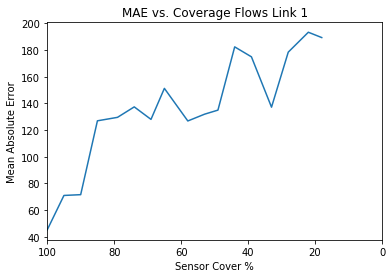

In [4]:
#run this after cell above finishes training 
plt.plot(sensors_covered, maximum_MAE)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Flows Link 1")
plt.xlim([100, 0])
#plt.savefig('/Users/alexellard/Downloads/Link1FlowsMax.png')
plt.show()